#### In this notebook, I have attempted to do the EDA, Feature selection, Clustering, and model building to predict the salary to be offered to a new candidate. This project was a part of my certification course and the data was sourced by them.

##### The use cases of this project could be:-

1.   Estimating a competitive and a fair salary to be offered to the candidate by minimizing human judgement 
2.   Understanding the parameters that affect the remuneration across various profiles
3. Assessing the similar kind of profiles in an unbiased way





In [177]:
from google.colab import drive

In [178]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,precision_recall_curve
import statsmodels.formula.api as sm
from xgboost import XGBClassifier
import datetime
from datetime import *
import lightgbm as lgbm
from sklearn.metrics import log_loss
raw_text = u"\u20B9"

In [180]:
#The data was given by Great Learning capstone team
df = pd.read_csv('/content/gdrive/MyDrive/Capstone - HR /expected_ctc.csv')

In [181]:
#Looking at the shape of the dataset
df.shape

(25000, 29)

In [182]:
#Dropping IDX and Applicant_ID columns
df.drop(columns=["IDX","Applicant_ID"],axis=1,inplace=True)

In [183]:
#Datatypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total_Experience                   25000 non-null  int64  
 1   Total_Experience_in_field_applied  25000 non-null  int64  
 2   Department                         22222 non-null  object 
 3   Role                               24037 non-null  object 
 4   Industry                           24092 non-null  object 
 5   Organization                       24092 non-null  object 
 6   Designation                        21871 non-null  object 
 7   Education                          25000 non-null  object 
 8   Graduation_Specialization          18820 non-null  object 
 9   University_Grad                    18820 non-null  object 
 10  Passing_Year_Of_Graduation         18820 non-null  float64
 11  PG_Specialization                  17308 non-null  obj

In [184]:
#Renaming of some columns for the ease of comprehension
df.rename(columns={"Total_Experience_in_field_applied":"Relevant_experience","Curent_location":"Current_location"},inplace=True)

In [185]:
#Changing the unique values of Inhand_Offer column from Yes and No to 0 and 1
df["Inhand_Offer"]=df["Inhand_Offer"].map({'N':0,'Y':1})

In [186]:
#Separating out the categorical and numerical columns
cat_col = df.select_dtypes(exclude=['int','float']).columns.tolist()
cont_col = df.select_dtypes(include=['int','float']).columns.tolist()
print("Number of categorical columns in the dataset are : {} \nNumber of numerical columns in the dataset are : {}".format(len(cat_col),len(cont_col)))

Number of categorical columns in the dataset are : 15 
Number of numerical columns in the dataset are : 12


In [187]:
#Number of unique values in the categorical features of the dataset
def num_unique_values(df):
    data = []
    for i in df.columns:
         data.append(df[i].nunique())
    s=pd.DataFrame({"Name of column":df.columns,"Number of unique values":data})
    return s.sort_values(by="Number of unique values",ascending=False)

In [188]:
num_unique_values(df[cat_col])

Name of column  Number of unique values
1                        Role                       24
4                 Designation                       18
3                Organization                       16
12            Curent_Location                       15
13         Preferred_location                       15
7             University_Grad                       13
9               University_PG                       13
11             University_PHD                       13
0                  Department                       12
2                    Industry                       11
6   Graduation_Specialization                       11
8           PG_Specialization                       11
10         PHD_Specialization                       11
14      Last_Appraisal_Rating                        5
5                   Education                        4

#### Descriptive Statistics

In [189]:
df.describe(include='all').T

count unique          top  freq       mean  \
Total_Experience           25000.00    NaN          NaN   NaN      12.49   
Relevant_experience        25000.00    NaN          NaN   NaN       6.26   
Department                    22222     12    Marketing  2379        NaN   
Role                          24037     24       Others  2248        NaN   
Industry                      24092     11     Training  2237        NaN   
Organization                  24092     16            M  1574        NaN   
Designation                   21871     18           HR  1648        NaN   
Education                     25000      4           PG  6326        NaN   
Graduation_Specialization     18820     11    Chemistry  1785        NaN   
University_Grad               18820     13  Bhubaneswar  1510        NaN   
Passing_Year_Of_Graduation 18820.00    NaN          NaN   NaN    2002.19   
PG_Specialization             17308     11  Mathematics  1800        NaN   
University_PG                 17308     13  Bhubaneswar  1377        NaN   
Passing_Year_Of_PG         17308.00    NaN          NaN   NaN    2005.15   
PHD_Specialization            13119     11       Others  1545        NaN   
University_PHD                13119     13      Kolkata  1069        NaN   
Passing_Year_Of_PHD        13119.00    NaN          NaN   NaN    2007.40   
Curent_Location               25000     15    Bangalore  1742        NaN   
Preferred_location            25000     15       Kanpur  1720        NaN   
Current_CTC                25000.00    NaN          NaN   NaN 1760945.38   
Inhand_Offer               25000.00    NaN          NaN   NaN       0.30   
Last_Appraisal_Rating         24092      5            B  5501        NaN   
No_Of_Companies_worked     25000.00    NaN          NaN   NaN       3.48   
Number_of_Publications     25000.00    NaN          NaN   NaN       4.09   
Certifications             25000.00    NaN          NaN   NaN       0.77   
International_degree_any   25000.00    NaN          NaN   NaN       0.08   
Expected_CTC               25000.00    NaN          NaN   NaN 2250154.51   

                                  std       min        25%        50%  \
Total_Experience                 7.47      0.00       6.00      12.00   
Relevant_experience              5.82      0.00       1.00       5.00   
Department                        NaN       NaN        NaN        NaN   
Role                              NaN       NaN        NaN        NaN   
Industry                          NaN       NaN        NaN        NaN   
Organization                      NaN       NaN        NaN        NaN   
Designation                       NaN       NaN        NaN        NaN   
Education                         NaN       NaN        NaN        NaN   
Graduation_Specialization         NaN       NaN        NaN        NaN   
University_Grad                   NaN       NaN        NaN        NaN   
Passing_Year_Of_Graduation       8.32   1986.00    1996.00    2002.00   
PG_Specialization                 NaN       NaN        NaN        NaN   
University_PG                     NaN       NaN        NaN        NaN   
Passing_Year_Of_PG               9.02   1988.00    1997.00    2006.00   
PHD_Specialization                NaN       NaN        NaN        NaN   
University_PHD                    NaN       NaN        NaN        NaN   
Passing_Year_Of_PHD              7.49   1995.00    2001.00    2007.00   
Curent_Location                   NaN       NaN        NaN        NaN   
Preferred_location                NaN       NaN        NaN        NaN   
Current_CTC                 920212.51      0.00 1027311.50 1802567.50   
Inhand_Offer                     0.46      0.00       0.00       0.00   
Last_Appraisal_Rating             NaN       NaN        NaN        NaN   
No_Of_Companies_worked           1.69      0.00       2.00       3.00   
Number_of_Publications           2.61      0.00       2.00       4.00   
Certifications                   1.20      0.00       0.00       0.00   
Int

In [190]:
#Inferences from descriptive statistics(need to be validated using visualization):
#1: Outliers are evident in Current CTC, Relevant experience
#2: Not many candidates have done certifications as less than 75% of candidates have done only 1 certifications
#3: Most of the values in passing year of Graduation,Post Graduation, and PHD are null values
#4: Current CTC and Expected CTC are left-skewed distribution. Total experience and Relevant experience are almost symmetric

##### Null values analysis



In [191]:
#Null values in each of the columns
df.isnull().sum()

Total_Experience                  0
Relevant_experience               0
Department                     2778
Role                            963
Industry                        908
Organization                    908
Designation                    3129
Education                         0
Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
Curent_Location                   0
Preferred_location                0
Current_CTC                       0
Inhand_Offer                      0
Last_Appraisal_Rating           908
No_Of_Companies_worked            0
Number_of_Publications            0
Certifications                    0
International_degree_any          0
Expected_CTC                      0
dtype: int64

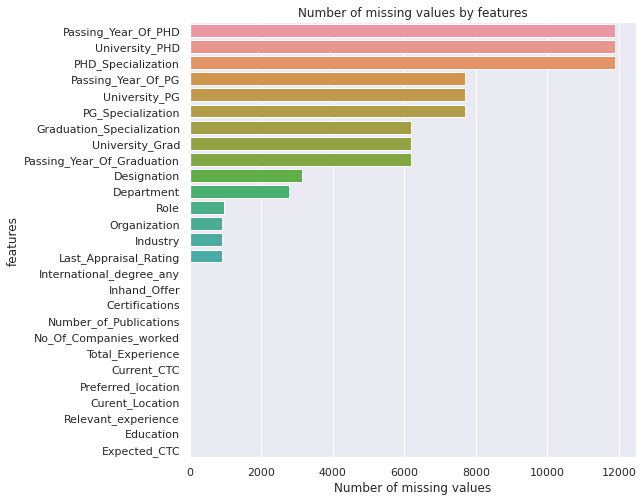

In [192]:
#Visually assessing null values
plt.figure(figsize=(8,8))
sns.barplot(x=df.isnull().sum().values,y=df.isnull().sum().index,order=df.isnull().sum().reset_index().sort_values(by=0,ascending=False)["index"])
plt.title('Number of missing values by features')
plt.xlabel('Number of missing values')
plt.ylabel('features')
plt.show()

In [193]:
null_value_features=list(df.isnull().sum()[df.isnull().sum()!=0].index)

In [194]:
perc_null=(df[null_value_features].isnull().sum()/df.shape[0])*100

In [195]:
perc_null=pd.DataFrame(perc_null)

In [196]:
perc_null

0
Department                 11.11
Role                        3.85
Industry                    3.63
Organization                3.63
Designation                12.52
Graduation_Specialization  24.72
University_Grad            24.72
Passing_Year_Of_Graduation 24.72
PG_Specialization          30.77
University_PG              30.77
Passing_Year_Of_PG         30.77
PHD_Specialization         47.52
University_PHD             47.52
Passing_Year_Of_PHD        47.52
Last_Appraisal_Rating       3.63

In [197]:
perc_null.sort_values(by=0,ascending=False)[0].values

array([47.524, 47.524, 47.524, 30.768, 30.768, 30.768, 24.72 , 24.72 ,
       24.72 , 12.516, 11.112,  3.852,  3.632,  3.632,  3.632])

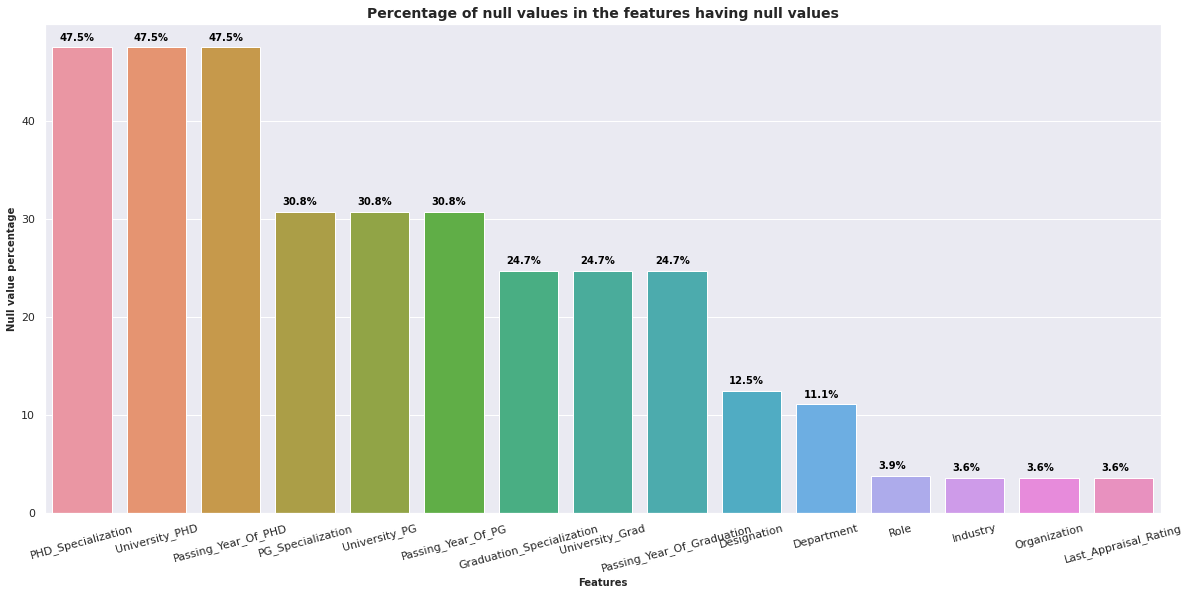

In [198]:
plt.figure(figsize=(20,9))
sns.barplot(x=perc_null.index,y=perc_null[0],order=perc_null.sort_values(by=0,ascending=False).index)
for (i,j) in enumerate(perc_null.sort_values(by=0,ascending=False)[0].values):
    plt.text(x=i-0.3,y=j+0.7,s="{:.1f}%".format(j),color="black",fontsize=10,fontweight="bold")
plt.xticks(rotation=15)
plt.title('Percentage of null values in the features having null values',fontdict={'fontsize':14,'weight':'bold'})
plt.xlabel('Features',fontdict={'fontsize':10,'weight':'bold'})
plt.ylabel('Null value percentage',fontdict={'fontsize':10,'weight':'bold'})
plt.show()

# Exploratory Data Analysis

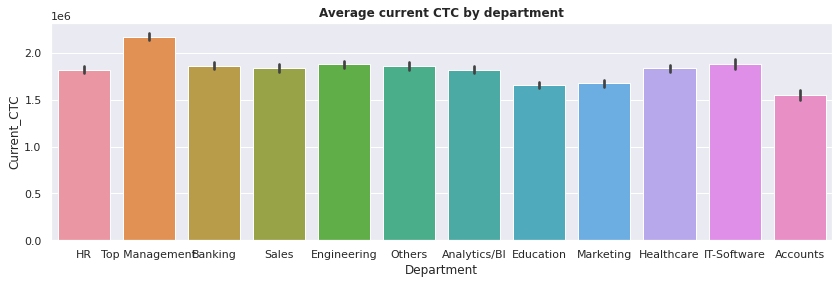

In [199]:
plt.figure(figsize=(14,4))
p=sns.barplot(x=df["Department"],y=df["Current_CTC"],estimator=np.mean)
p.set_title("Average current CTC by department",fontdict={'weight':'bold'})
plt.show()

In [200]:
data = df.copy()

In [201]:
#Here I have binned the Total experience feature into different intervals to do an analysis according to how job postings need the experience be
data["Total_Experience_range"]=pd.cut(data["Total_Experience"],bins=[0,2,6,11,16,21,25],
                              labels=['0-1','2-5','6-10','11-15','16-20','21-25'])

In [202]:
r1=range(data["Total_Experience_range"].nunique())

In [203]:
v1 = sorted(data["Total_Experience_range"].value_counts(1).values*100)
v1

[8.085671592229787,
 15.822679727710442,
 15.926448613647684,
 19.882118545575295,
 20.05229951851237,
 20.230782002324425]

In [204]:
v2 = sorted(data["Total_Experience_range"].value_counts())
v2

[1948, 3812, 3837, 4790, 4831, 4874]

In [205]:
data.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Total_Experience_range'],
      dtype='object')

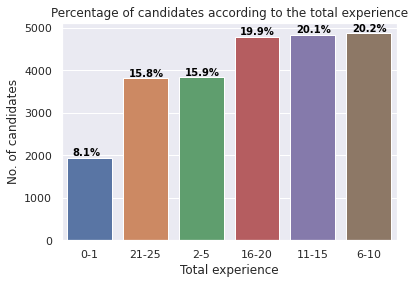

In [206]:
sns.countplot(x=data["Total_Experience_range"],order=data["Total_Experience_range"].value_counts().sort_values().index)
for (i,j,k) in zip(r1,v1,v2):
      plt.text(x=i-0.3,y=k+46,s="{:.1f}%".format(j),color="black",fontsize=10,fontweight="bold")
plt.ylabel('No. of candidates')
plt.xlabel('Total experience')
plt.title("Percentage of candidates according to the total experience")
plt.show()

In [207]:
print(df["Total_Experience"].describe())

print("Skewness in total experience is {} :".format(df["Total_Experience"].skew()))

count   25000.00
mean       12.49
std         7.47
min         0.00
25%         6.00
50%        12.00
75%        19.00
max        25.00
Name: Total_Experience, dtype: float64
Skewness in total experience is 0.0041087183649387215 :


In [208]:
#Doing the same binning with relevant experience
df["Relevant_experience"].unique()

array([ 0, 14, 12,  8,  5,  3,  1, 11,  7, 15, 10,  9,  4,  6,  2, 20, 16,
       25, 13, 19, 21, 22, 23, 17, 18, 24])

In [209]:
data["Relevant_experience_range"]=pd.cut(data["Relevant_experience"],bins=[0,2,6,11,16,21,25],
                              labels=['0-1','2-5','6-10','11-15','16-20','21-25'])

In [210]:
r2=range(data["Relevant_experience_range"].nunique())
r2

range(0, 6)

In [211]:
v3 = sorted(data["Relevant_experience_range"].value_counts(1).values*100)
v3

[1.7538923278934533,
 6.903020071281185,
 13.984243106359031,
 23.063215156631024,
 23.438379290939785,
 30.85725004689552]

In [212]:
v4 = sorted(data["Relevant_experience_range"].value_counts())
v4

[374, 1472, 2982, 4918, 4998, 6580]

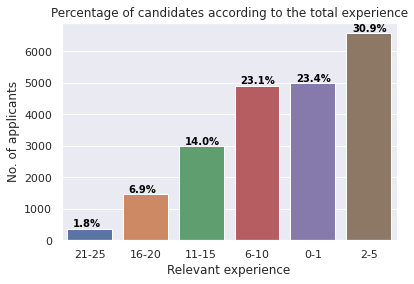

In [213]:
sns.countplot(x=data["Relevant_experience_range"],order=data["Relevant_experience_range"].value_counts().sort_values().index)
for (i,j,k) in zip(r2,v3,v4):
      plt.text(x=i-0.3,y=k+46,s="{:.1f}%".format(j),color="black",fontsize=10,fontweight="bold")
plt.ylabel('No. of applicants')
plt.xlabel('Relevant experience')
plt.title("Percentage of candidates according to the total experience")
plt.show()

In [214]:
#Cross-tabulation to analyse the proportion of relevant experience out of total experience
pd.set_option('display.float_format', lambda x: '{:.2f}%'.format(x))
data2 = pd.crosstab(index=data["Total_Experience_range"],columns=data["Relevant_experience_range"],normalize="index")*100
data2

Relevant_experience_range     0-1    2-5   6-10  11-15  16-20  21-25
Total_Experience_range                                              
0-1                       100.00%  0.00%  0.00%  0.00%  0.00%  0.00%
2-5                        47.81% 52.19%  0.00%  0.00%  0.00%  0.00%
6-10                       22.31% 47.25% 30.45%  0.00%  0.00%  0.00%
11-15                      13.86% 29.27% 35.67% 21.19%  0.00%  0.00%
16-20                      10.38% 21.51% 25.49% 27.24% 15.37%  0.00%
21-25                       8.64% 16.37% 22.25% 21.43% 21.10% 10.22%

In [215]:
data2.to_csv('data2.csv')

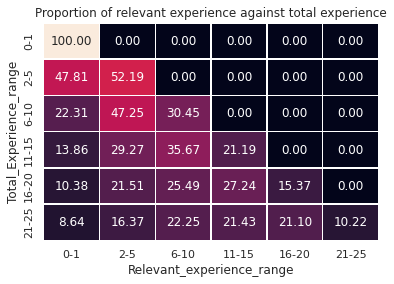

In [216]:
p=sns.heatmap(data2,annot=True,fmt='.2f',mask=np.triu(data2,+1),cbar=False,lw=0.5)
p.set_title('Proportion of relevant experience against total experience')
plt.show()

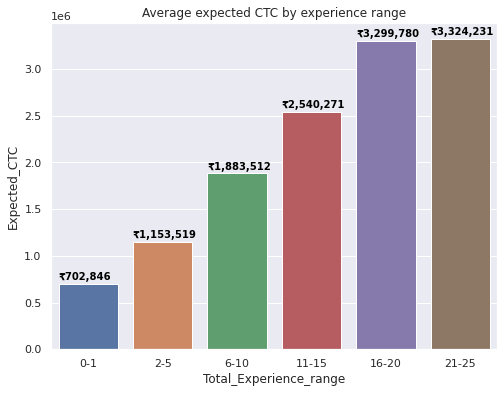

In [217]:
#Average expected CTC by total experience range
d1=data.groupby("Total_Experience_range").agg({"Expected_CTC":"mean"})["Expected_CTC"]
plt.figure(figsize=(8,6))
sns.barplot(x="Total_Experience_range",y="Expected_CTC",data=data,ci=False)
for (i,j) in enumerate(d1):
      plt.text(x=i-0.4,y=j+40000,s="{}{:,.0f}".format(raw_text,j),color="black",fontsize=10,fontweight="bold")
plt.title("Average expected CTC by experience range")
plt.show()

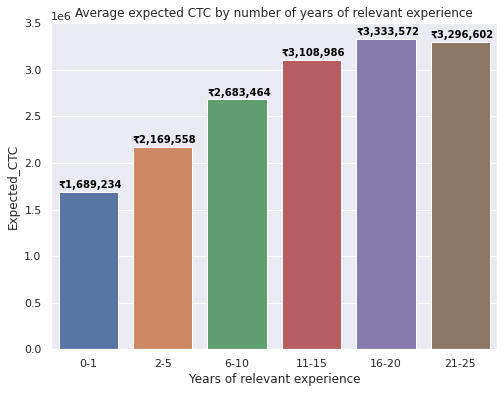

In [218]:
#Average expected CTC by relevant experience
d2 = data.groupby("Relevant_experience_range").agg({"Expected_CTC":"mean"})["Expected_CTC"]
plt.figure(figsize=(8,6))
sns.barplot(x="Relevant_experience_range",y="Expected_CTC",data=data,ci=False)
for (i,j) in enumerate(d2):
      plt.text(x=i-0.4,y=j+40000,s="{}{:,.0f}".format(raw_text,j),color="black",fontsize=10,fontweight="bold")
plt.title("Average expected CTC by number of years of relevant experience")
plt.xlabel("Years of relevant experience")
plt.show()

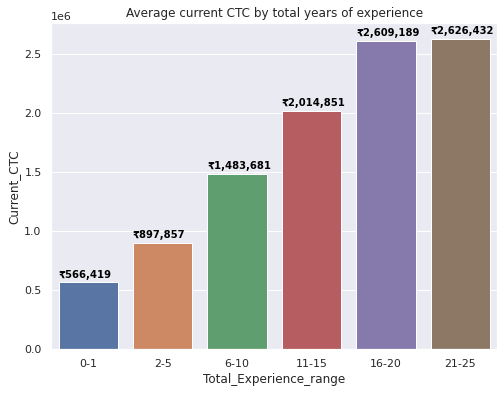

In [219]:
#Average current CTC by total years of experience
d3=data.groupby("Total_Experience_range").agg({"Current_CTC":"mean"})["Current_CTC"]
plt.figure(figsize=(8,6))
sns.barplot(x="Total_Experience_range",y="Current_CTC",data=data,ci=False)
for (i,j) in enumerate(d3):
      plt.text(x=i-0.4,y=j+40000,s="{}{:,.0f}".format(raw_text,j),color="black",fontsize=10,fontweight="bold")
plt.title("Average current CTC by total years of experience")
plt.show()

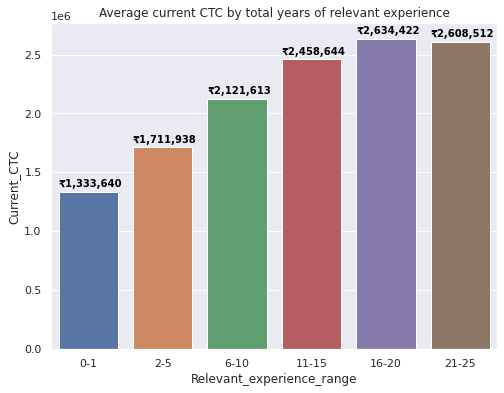

In [220]:
#Average current CTC by total years of relevant experience
d4=data.groupby("Relevant_experience_range").agg({"Current_CTC":"mean"})["Current_CTC"]
plt.figure(figsize=(8,6))
sns.barplot(x="Relevant_experience_range",y="Current_CTC",data=data,ci=False)
for (i,j) in enumerate(d4):
      plt.text(x=i-0.4,y=j+40000,s="{}{:,.0f}".format(raw_text,j),color="black",fontsize=10,fontweight="bold")
plt.title("Average current CTC by total years of relevant experience")
plt.show()

In [221]:
#Value counts of the industry feature
df.Industry.value_counts(dropna=False)

Training      2237
IT            2228
Insurance     2219
BFSI          2207
Automobile    2202
Analytics     2201
Retail        2195
Telecom       2190
Aviation      2183
FMCG          2180
Others        2050
NaN            908
Name: Industry, dtype: int64

In [222]:
#Value counts of the department feature
df["Department"].value_counts(dropna=False)

NaN               2778
Marketing         2379
Analytics/BI      2096
Healthcare        2062
Others            2041
Sales             1991
HR                1988
Banking           1952
Education         1948
Engineering       1937
Top Management    1632
Accounts          1118
IT-Software       1078
Name: Department, dtype: int64

In [223]:
def dist_qq_and_box_plot(df,cont):
    import statsmodels.api as SM1
    fig,axes=plt.subplots(nrows=len(df[cont].columns),ncols=3,figsize=(15,30))
    m=0
    for i in df[cont].columns:
        n=0
        sns.distplot(df[i],ax=axes[m][n])
        axes[m][n].set_title("Distribution plot of "+str(i))
        n+=1
        SM1.qqplot(df[i],ax=axes[m][n],line="s")
        axes[m][n].set_title("QQ plot of "+str(i))
        n+=1
        sns.boxplot(df[i],ax=axes[m][n])
        axes[m][n].set_title("Box plot of "+str(i))
        m+=1
    plt.tight_layout()

In [224]:
df5 = df.copy()

In [225]:
df5.dropna(inplace=True)

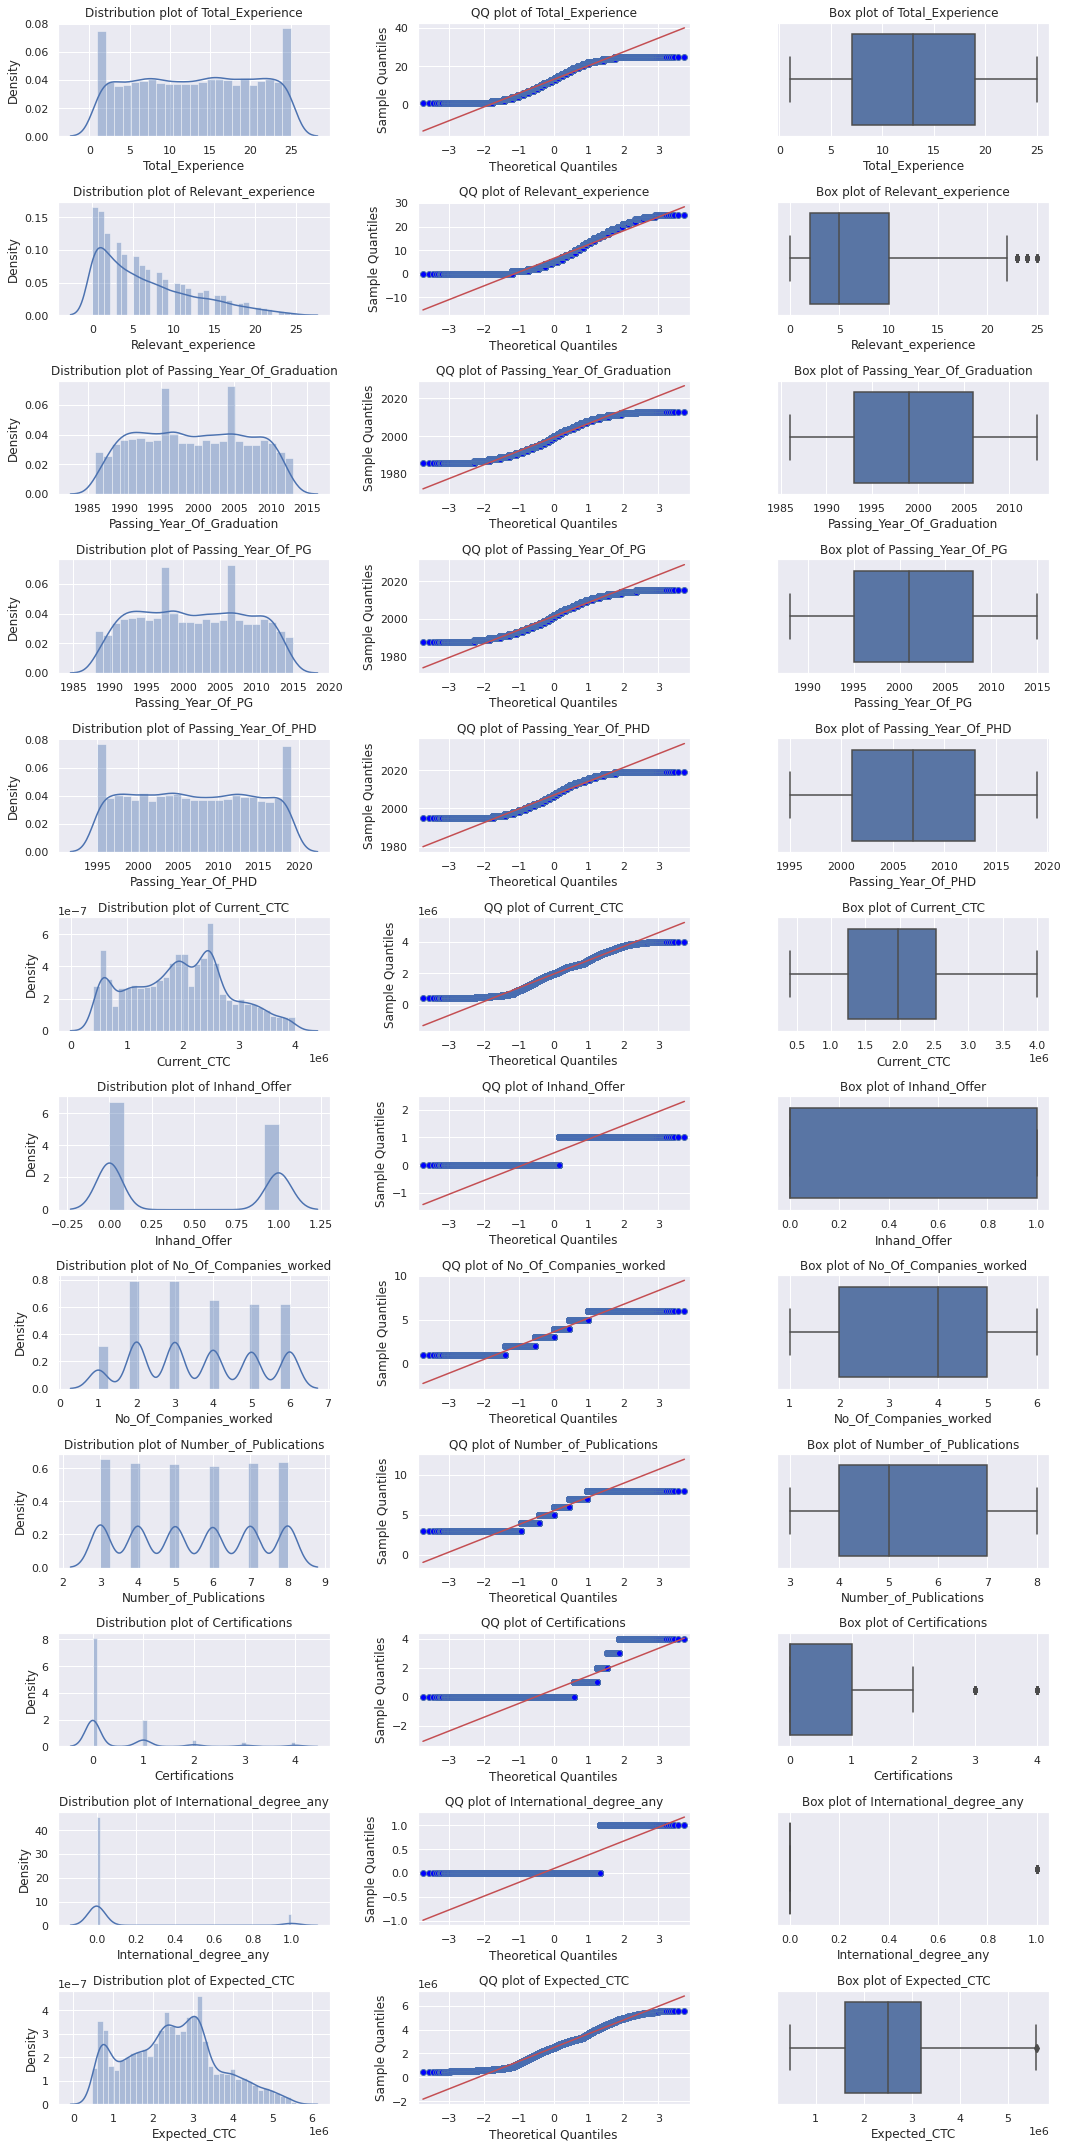

In [226]:
#Analysing the distribution of each of the numerical feature
dist_qq_and_box_plot(df5,cont_col)

In [227]:
p = df.copy()
p.isnull().sum()[p.isnull().sum()!=0]

Department                     2778
Role                            963
Industry                        908
Organization                    908
Designation                    3129
Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
Last_Appraisal_Rating           908
dtype: int64

In [228]:
# Countplot and Boxplot of Department,Role,Industry, and Organization

In [229]:
#Function to get the countplots of all the levels in the categorical features
def count_plot(df,col):
  """
  Count plot of all the levels in the categorical features
  df : Dataframe for which this information is needed
  col : Column name
  
  """
  plt.figure(figsize=(17,4))
  p=df[col].value_counts().values
  r=df[col].value_counts(1)*100
  sns.countplot(x=df[col],order=r.index)
  for (i,j) in enumerate(r.values):
    plt.text(x=i-0.3,y=0.7+p[i],s="{:.1f}%".format(j),color="black",fontsize=10,fontweight="bold")
  plt.title("Count of the different levels of "+str(col))
  #plt.title("Count of the applicants with current location as : {}".format(data1["Curent_Location"].unique()[0]))
  plt.xticks(rotation=30)

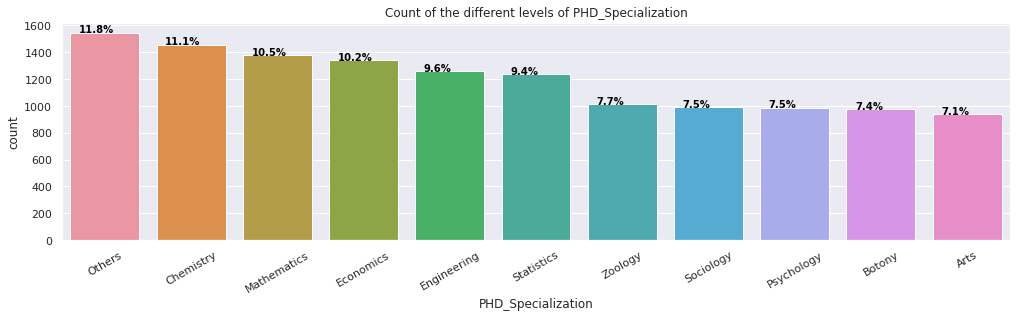

In [230]:
count_plot(df,cat_col[10])

In [231]:
#Function to get the distribution of current CTC across different levels of the categorical features
def cat_plot(df,col):
  #plt.figure(figsize=(40,4))
  #p=df[col].value_counts().values
  #r=df[col].value_counts(1)*100
  sns.catplot(x=col,y='Current_CTC',data=df,kind='box')
  plt.title("Boxplot of current CTC with "+str(col))
  sns.set(font_scale=1.0)
  plt.xticks(rotation=30)

In [232]:
#Function to get the distribution of expected CTC across different levels of the categorical features
def cat_plot1(df,col):
  #plt.figure(figsize=(40,4))
  #p=df[col].value_counts().values
  #r=df[col].value_counts(1)*100
  sns.catplot(x=col,y='Expected_CTC',data=df,kind='box')
  plt.title("Boxplot of expected CTC with "+str(col))
  sns.set(font_scale=1.0)
  plt.xticks(rotation=20)

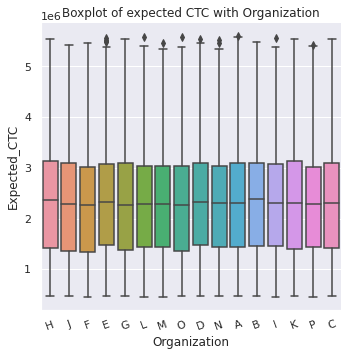

In [233]:
cat_plot1(df,cat_col[3])

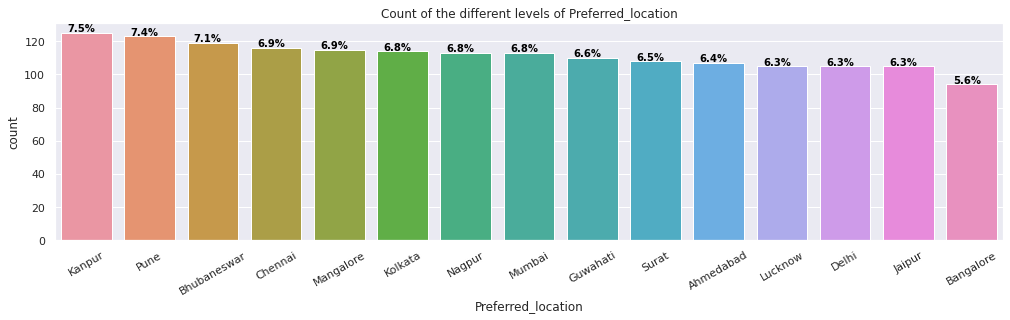

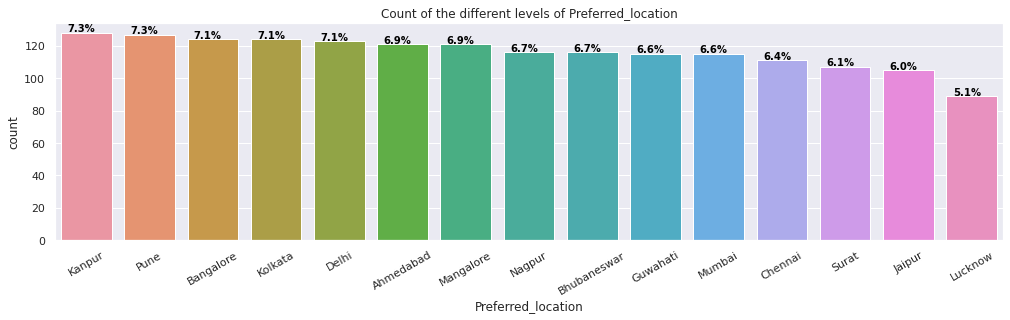

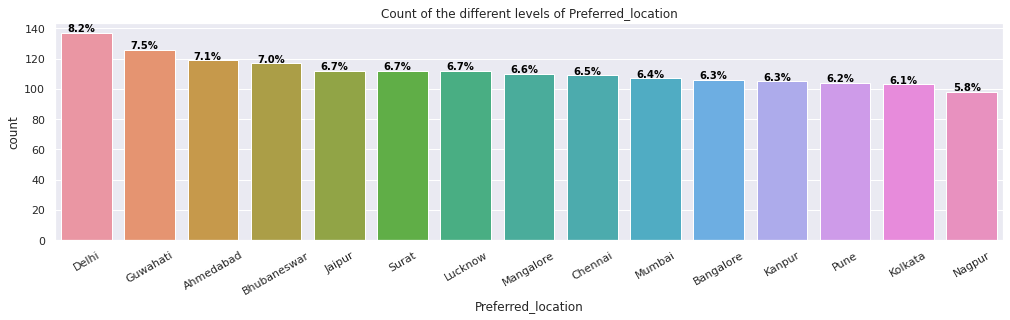

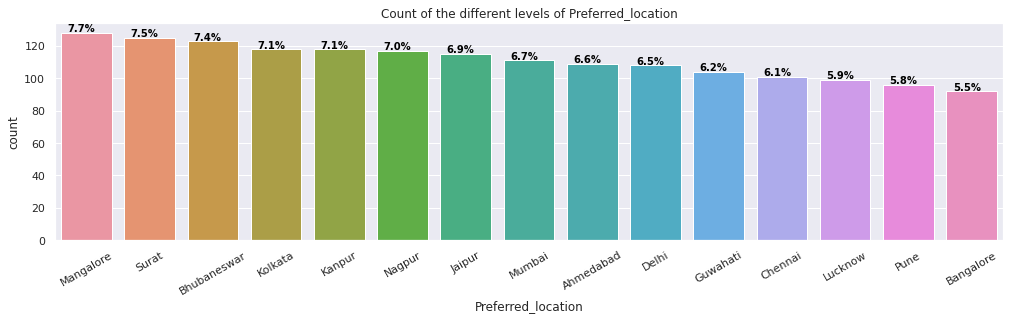

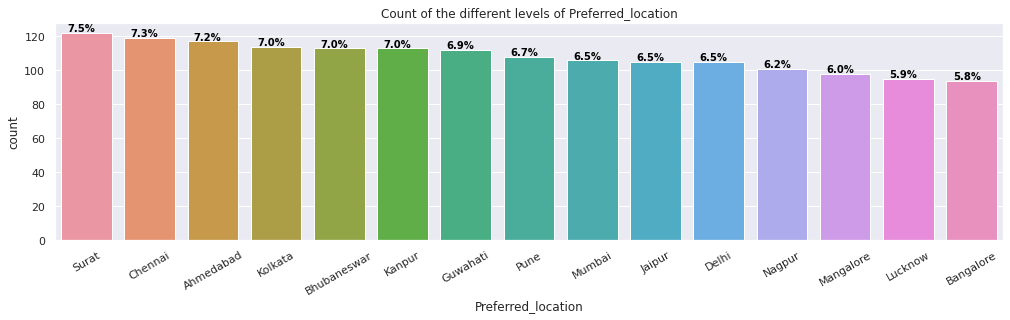

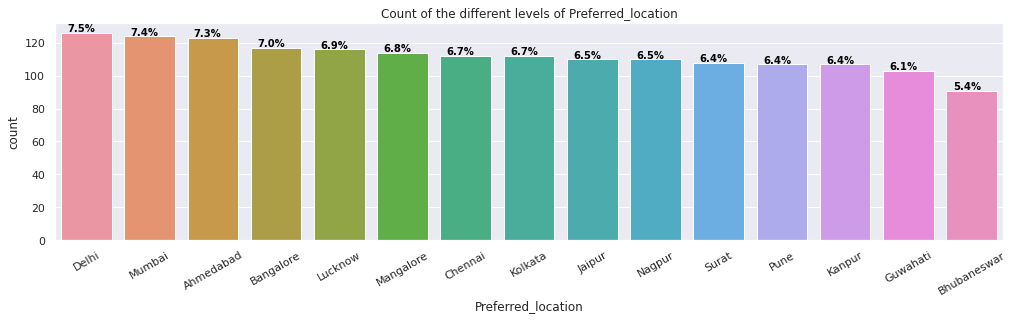

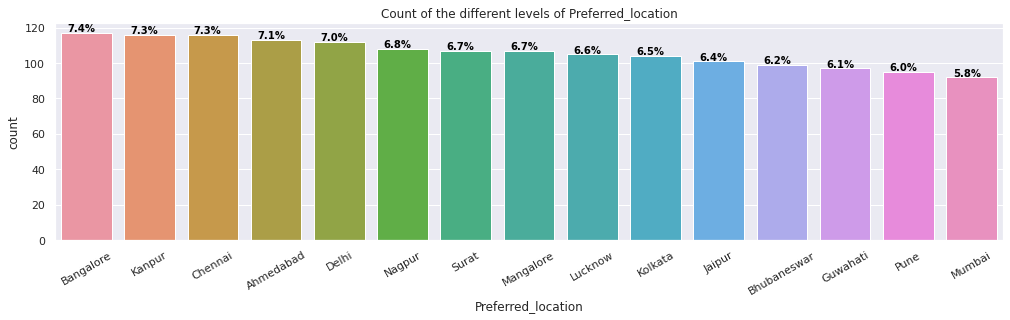

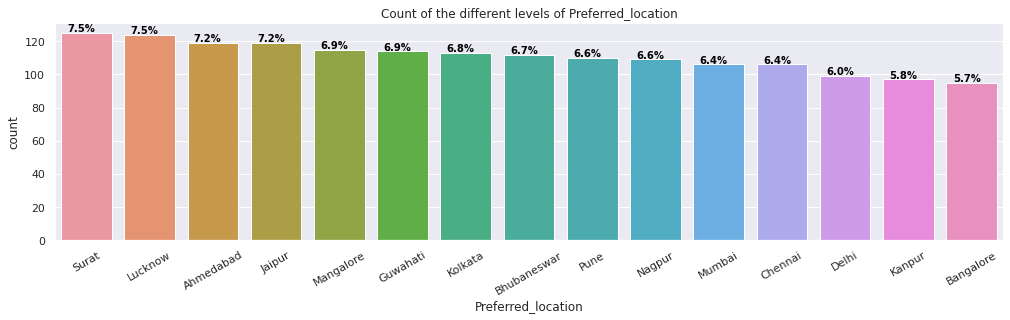

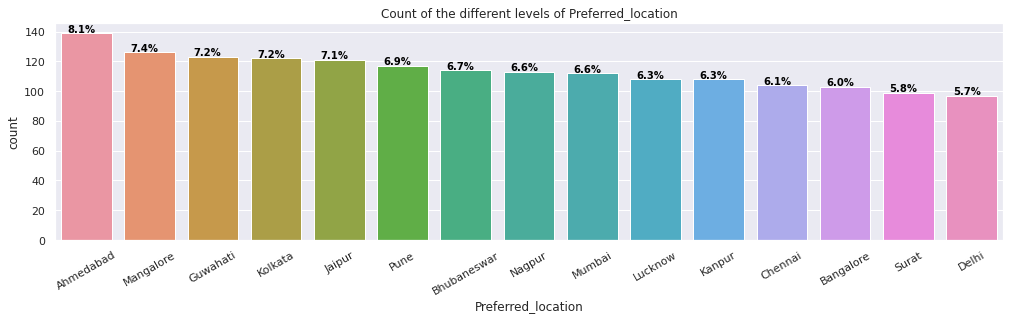

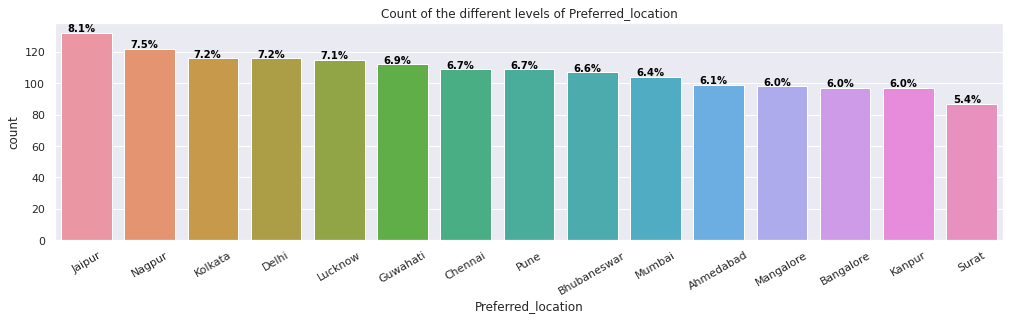

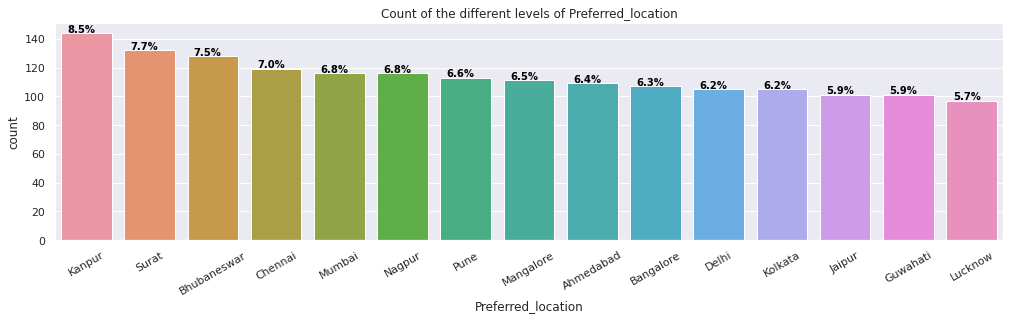

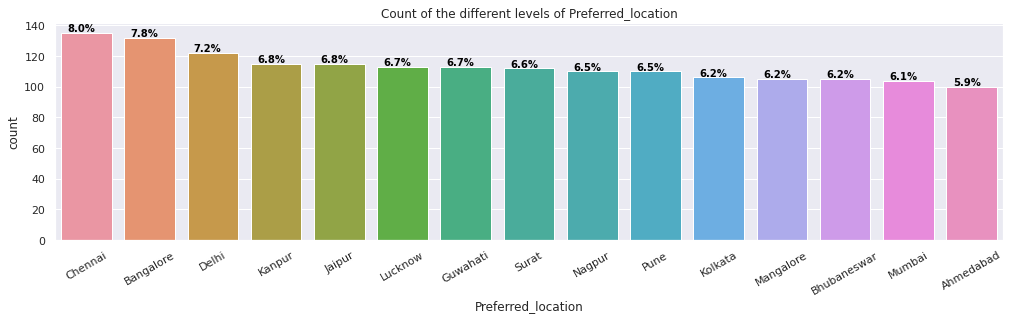

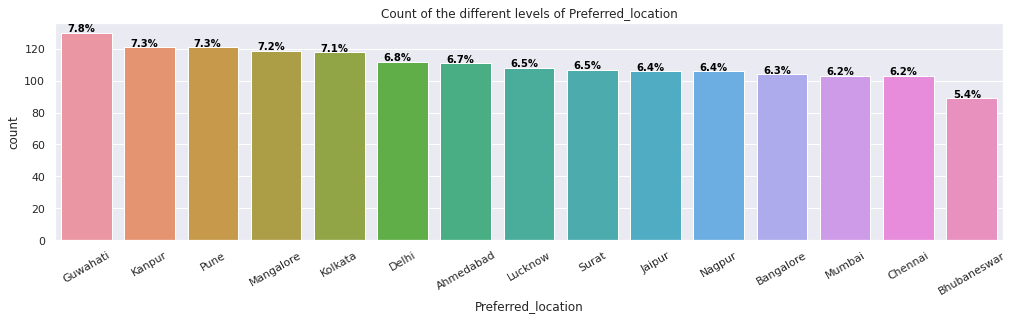

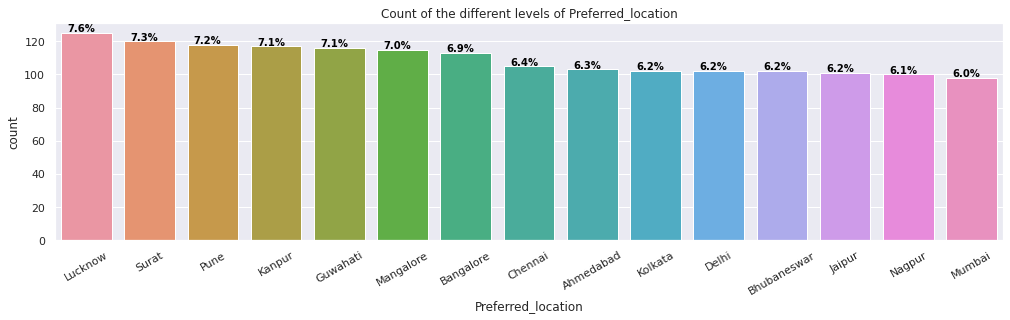

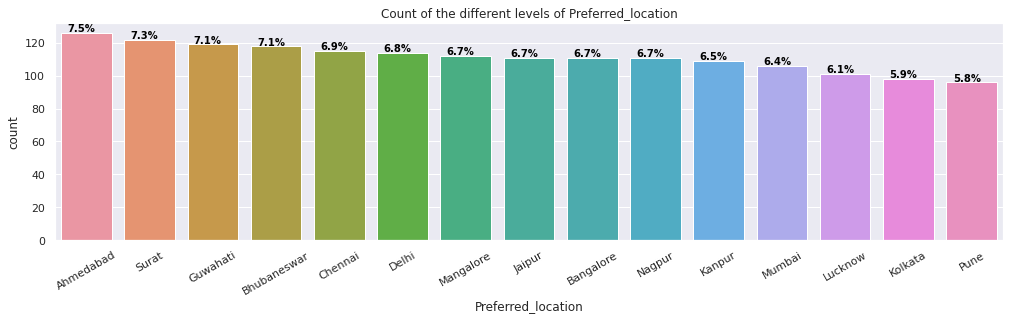

In [234]:
#Count plot of the different levels of preferred location against every current location
l1 = df["Curent_Location"].unique().tolist()
for i in l1:
  data1 = df.loc[df["Curent_Location"]==i]
  count_plot(data1,cat_col[13])

In [235]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.loc[df["Inhand_Offer"]=='N',"Current_CTC"].describe()

count   0.00
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Current_CTC, dtype: float64

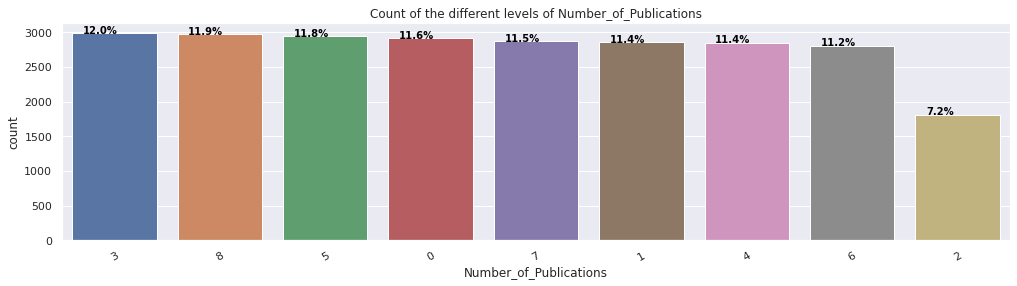

In [236]:
#Count plot of the different levels of Number of publications
count_plot(df,'Number_of_Publications')

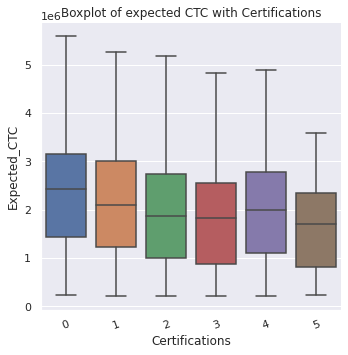

In [237]:
#Distribution of expected CTC against certifications
cat_plot1(df,'Certifications')

##### Missing value imputation begins here!

In [238]:
df.isnull().sum()

Total_Experience                  0
Relevant_experience               0
Department                     2778
Role                            963
Industry                        908
Organization                    908
Designation                    3129
Education                         0
Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
Curent_Location                   0
Preferred_location                0
Current_CTC                       0
Inhand_Offer                      0
Last_Appraisal_Rating           908
No_Of_Companies_worked            0
Number_of_Publications            0
Certifications                    0
International_degree_any          0
Expected_CTC                      0
dtype: int64

###### On investigating the reason of missing values in Role, Designation, Industry, Organization, and Department. It was found that these columns have missing values for each of the records for which the total experience is 0 i.e. the candidate is fresher.

In [239]:
df.loc[df["Department"].isna()==True,["Total_Experience","Relevant_experience","Role","Industry","Organization","Designation"]].head()

Total_Experience  Relevant_experience               Role   Industry  \
0                  0                    0                NaN        NaN   
13                 0                    0                NaN        NaN   
30                 4                    4   Bio statistician     Others   
32                12                    0  Senior Researcher       BFSI   
40                 9                    8  Senior Researcher  Insurance   

   Organization        Designation  
0           NaN                NaN  
13          NaN                NaN  
30            O    Medical Officer  
32            N  Marketing Manager  
40            M         Sr.Manager

In [240]:
#filt1=((df["Total_Experience"]==0)&(df["Relevant_experience"]==0))
filt1=((df["Total_Experience"]==0))
W=df.loc[filt1,["Role","Industry","Organization","Designation","Department"]]

In [241]:
W

Role Industry Organization Designation Department
0      NaN      NaN          NaN         NaN        NaN
13     NaN      NaN          NaN         NaN        NaN
140    NaN      NaN          NaN         NaN        NaN
150    NaN      NaN          NaN         NaN        NaN
176    NaN      NaN          NaN         NaN        NaN
181    NaN      NaN          NaN         NaN        NaN
206    NaN      NaN          NaN         NaN        NaN
281    NaN      NaN          NaN         NaN        NaN
311    NaN      NaN          NaN         NaN        NaN
356    NaN      NaN          NaN         NaN        NaN
392    NaN      NaN          NaN         NaN        NaN
442    NaN      NaN          NaN         NaN        NaN
446    NaN      NaN          NaN         NaN        NaN
455    NaN      NaN          NaN         NaN        NaN
488    NaN      NaN          NaN         NaN        NaN
556    NaN      NaN          NaN         NaN        NaN
588    NaN      NaN          NaN         NaN        NaN
589    NaN      NaN          NaN         NaN        NaN
622    NaN      NaN          NaN         NaN        NaN
637    NaN      NaN          NaN         NaN        NaN
664    NaN      NaN          NaN         NaN        NaN
672    NaN      NaN          NaN         NaN        NaN
709    NaN      NaN          NaN         NaN        NaN
717    NaN      NaN          NaN         NaN        NaN
734    NaN      NaN          NaN         NaN        NaN
796    NaN      NaN          NaN         NaN        NaN
815    NaN      NaN          NaN         NaN        NaN
825    NaN      NaN          NaN         NaN        NaN
831    NaN      NaN          NaN         NaN        NaN
857    NaN      NaN          NaN         NaN        NaN
901    NaN      NaN          NaN         NaN        NaN
972    NaN      NaN          NaN         NaN        NaN
983    NaN      NaN          NaN         NaN        NaN
1038   NaN      NaN          NaN         NaN        NaN
1054   NaN      NaN          NaN         NaN        NaN
1095   NaN      NaN          NaN         NaN        NaN
1106   NaN      NaN          NaN         NaN        NaN
1129   NaN      NaN          NaN         NaN        NaN
1153   NaN      NaN          NaN         NaN        NaN
1186   NaN      NaN          NaN         NaN        NaN
1224   NaN      NaN          NaN         NaN        NaN
1228   NaN      NaN          NaN         NaN        NaN
1251   NaN      NaN          NaN         NaN        NaN
1304   NaN      NaN          NaN         NaN        NaN
1308   NaN      NaN          NaN         NaN        NaN
1325   NaN      NaN          NaN         NaN        NaN
1338   NaN      NaN          NaN         NaN        NaN
1403   NaN      NaN          NaN         NaN        NaN
1409   NaN      NaN          NaN         NaN        NaN
1450   NaN      NaN          NaN         NaN        NaN
1553   NaN      NaN          NaN         NaN        NaN
1598   NaN      NaN          NaN         NaN        NaN
1623   NaN      NaN          NaN         NaN        NaN
1634   NaN      NaN          NaN         NaN        NaN
1706   NaN      NaN          NaN         NaN        NaN
1737   NaN      NaN          NaN         NaN        NaN
1739   NaN      NaN          NaN         NaN        NaN
1748   NaN      NaN          NaN         NaN        NaN
1755   NaN      NaN          NaN         NaN        NaN
1805   NaN      NaN          NaN         NaN        NaN
1814   NaN      NaN          NaN         NaN        NaN
1856   NaN      NaN          NaN         NaN        NaN
1913   NaN      NaN          NaN         NaN        NaN
1918   NaN      NaN          NaN         NaN        NaN
1961   NaN      NaN          NaN         NaN        NaN
1974   NaN      NaN          NaN         NaN        NaN
2007   NaN      NaN          NaN         NaN        NaN
2056   NaN      NaN          NaN         NaN        NaN
2063   NaN      NaN          NaN         NaN        NaN
2064   NaN      NaN          NaN         NaN        NaN
2075   NaN      NaN          N

In [242]:
#Imputing fresher in place of missing values which satisfy the below condition
for i in ["Department","Role","Industry","Organization","Designation"]:
  df[i]=np.where(df["Total_Experience"]==0,'Fresher',df[i])

In [243]:
#It was noticed that last_appraisal_rating column also has missing values for the records where candidate has 0 total experience

In [244]:
filt = ((df["Last_Appraisal_Rating"].isna()==True) & (df["Department"]=="Fresher") & (df["Role"]=="Fresher") & (df["Industry"]=="Fresher") & (df["Organization"]=="Fresher") & (df["Designation"]=="Fresher"))
df.loc[filt,["Department","Role","Industry","Organization","Designation"]].shape

(908, 5)

In [245]:
df["Last_Appraisal_Rating"]=np.where(filt,"Fresher",df["Last_Appraisal_Rating"])

In [246]:
df.isnull().sum()[df.isnull().sum()!=0]

Department                     1870
Role                             55
Designation                    2221
Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
dtype: int64

In [247]:
df["Department_missing"]=np.where(df["Department"].isna(),1,0)
df["Role_missing"]=np.where(df["Role"].isna(),1,0)

In [248]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Department_missing',
       'Role_missing'],
      dtype='object')

In [249]:
p = df.copy()
p.isnull().sum()[p.isnull().sum()!=0]

Department                     1870
Role                             55
Designation                    2221
Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
dtype: int64

In [250]:
df["Designation_missing"]=np.where(df["Designation"].isna(),1,0)

In [251]:
data_Designation_missing = df.loc[df["Designation_missing"]==1,["Role","Industry","Organization","Department"]]
data_Role_missing = df.loc[df["Role_missing"]==1,["Designation","Industry","Organization","Department"]]
data_Department_missing = df.loc[df["Department_missing"]==1,["Role","Industry","Organization","Designation"]]

In [252]:
def countplot_1(data):
  fig,axes = plt.subplots(4,1,figsize=(25,15))
  for (i,j) in enumerate(data.columns):
    sns.countplot(x=j,data=data,ax=axes[i],order=data[j].value_counts().index)
    for (a,b) in enumerate(data[j].value_counts()):
        axes[i].text(x=a-0.3,y=b+0.7,s=b,color="black",fontsize=10,fontweight="bold")


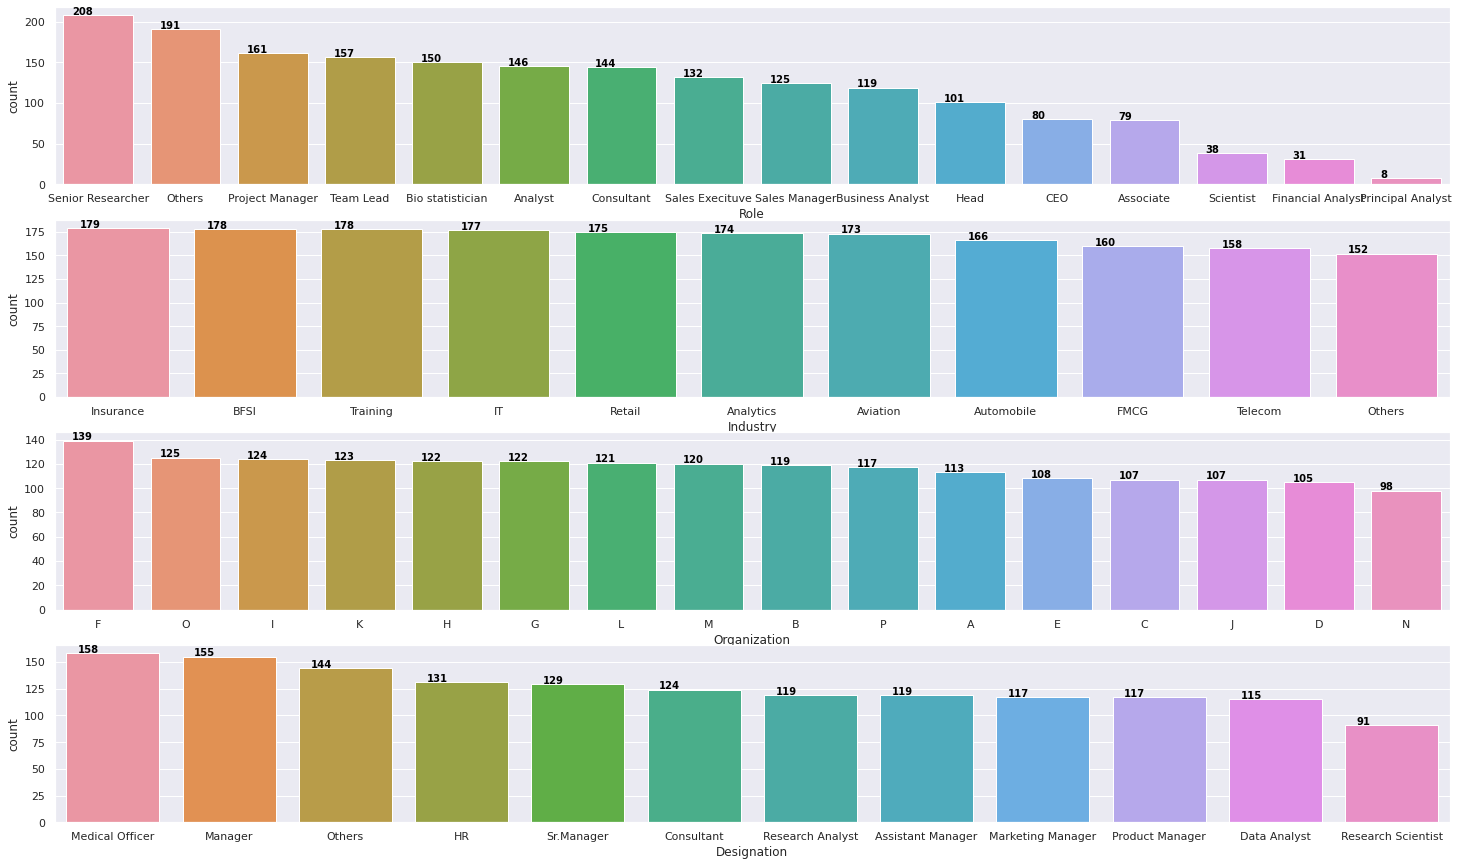

In [253]:
#Checking the counplot to see if the department is missing systematically 
countplot_1(data_Department_missing)

In [254]:
#As the values in the columns Role, Designation, Department are not missing at random
#It was chosen not to impute the values in these columns by simple imputer methods. Instead, I utilized CatBoostClassifier to
#predict the values

In [255]:
def null_cols(df):
  null_cols=df.isnull().sum()[df.isnull().sum()!=0].index.tolist()
  return null_cols

In [256]:
null_columns=null_cols(df)
null_columns

['Department',
 'Role',
 'Designation',
 'Graduation_Specialization',
 'University_Grad',
 'Passing_Year_Of_Graduation',
 'PG_Specialization',
 'University_PG',
 'Passing_Year_Of_PG',
 'PHD_Specialization',
 'University_PHD',
 'Passing_Year_Of_PHD']

##### Method to impute missing values using CatBoostClassifer

In [257]:
#Step 1 : Separating out the indices of the records for which the column has missing values
#Designation_non_null_index=df[df["Designation_missing"]==0].index
#Designation_null_index=df[df["Designation_missing"]==1].index

In [258]:
list1 = []
for i in df.drop(columns=null_columns,axis=1).columns:
  list1.append(df.columns.tolist().index(i))

In [259]:
list1.append(df.columns.tolist().index('Designation'))

In [260]:
list1

[0, 1, 4, 5, 7, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 6]

In [261]:
list2 = list1.copy()

In [262]:
list2

[0, 1, 4, 5, 7, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 6]

In [263]:
#Step 2 : Storing these indices in separate dataframes
#Designation_train = df.iloc[Designation_non_null_index,list1]
#Designation_test = df.iloc[Designation_null_index,list2]

In [264]:
#Step 3: Instantiating the model

#!pip install catboost

#import catboost as cb

#from catboost import Pool
#cbc = cb.CatBoostClassifier()

In [265]:
#Step 4: Separating the train and test

#X_train=Designation_train.drop("Designation",axis=1)
#Y_train=Designation_train["Designation"]

#X_test=Designation_test.drop("Designation",axis=1)
#Y_test=Designation_test["Designation"]

In [266]:
#Step 5: cat_features

#cat_features_train = X_train.select_dtypes(exclude=['int','float']).columns.tolist()
#cat_features_test = X_test.select_dtypes(exclude=['int','float']).columns.tolist()

In [267]:
#Step 6: Pool

#pool_train = Pool(X_train,Y_train,cat_features=cat_features_train)
#pool_test = Pool(X_test,Y_test,cat_features=cat_features_test)

In [268]:
#Step 7 : Training the data

#cbc.fit(pool_train)

In [269]:
#Step 8 : Predicting the class

#Designation_pred = cbc.predict(X_test)

In [270]:
#Step 9: Imputing the missing values

#for (i,j) in zip(range(len(Designation_pred)),Designation_null_index):
  #df.iloc[j,2] = Designation_pred[i][0]

In [271]:
#This was a long process as it took around 2-3 hours to impute the values 

In [272]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Capstone - HR /With_null_values.csv")

In [273]:
df = df1

In [274]:
df.columns

Index(['Unnamed: 0', 'Total_Experience', 'Relevant_experience', 'Department',
       'Role', 'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Total_Experience_range',
       'Relevant_experience_range', 'Department_missing', 'Role_missing',
       'Designation_missing'],
      dtype='object')

In [275]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [276]:
df.isnull().sum()[df.isnull().sum()!=0]

Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
Last_Appraisal_Rating           908
dtype: int64

In [277]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Total_Experience_range',
       'Relevant_experience_range', 'Department_missing', 'Role_missing',
       'Designation_missing'],
      dtype='object')

In [278]:
data = df.copy()

In [279]:
#Dropping the variables that were created for EDA and imputation
df.drop(columns=['Department_missing', 'Role_missing','Designation_missing'],axis=1,inplace=True)

In [280]:
df.drop(columns=["Total_Experience_range","Relevant_experience_range"],axis=1,inplace=True)

In [281]:
#df.drop(columns=["Curent_Location","Preferred_location","Passing_Year_Of_Graduation",'Passing_Year_Of_PHD','Passing_Year_Of_PG'],axis=1,inplace=True)

### Feature engineering

In [282]:
#1. If Current location and preferred location is same
df["Willing_to_relocate"]=np.where(df["Preferred_location"]==df["Curent_Location"],0,1)

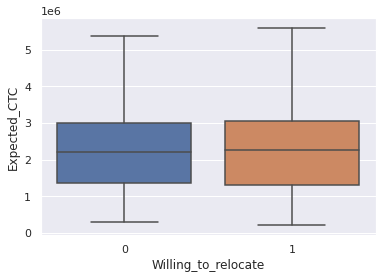

In [283]:
sns.boxplot(x=df["Willing_to_relocate"],y=df["Expected_CTC"])

In [284]:
df.groupby("Willing_to_relocate").agg({"Expected_CTC":"mean"})

Expected_CTC
Willing_to_relocate              
0                      2228278.45
1                      2251784.92

In [285]:
df["Curent_Location"].unique()

array(['Guwahati', 'Bangalore', 'Ahmedabad', 'Kanpur', 'Pune', 'Delhi',
       'Surat', 'Nagpur', 'Jaipur', 'Kolkata', 'Bhubaneswar', 'Mangalore',
       'Mumbai', 'Lucknow', 'Chennai'], dtype=object)

In [286]:
#df.columns

In [287]:
#df["No_Of_Companies_worked"].unique()

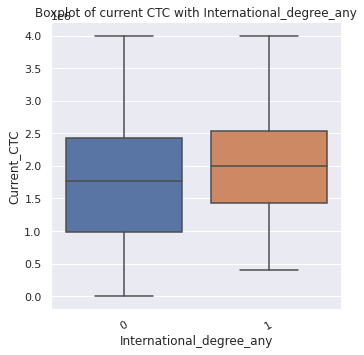

In [288]:
cat_plot(df,"International_degree_any")

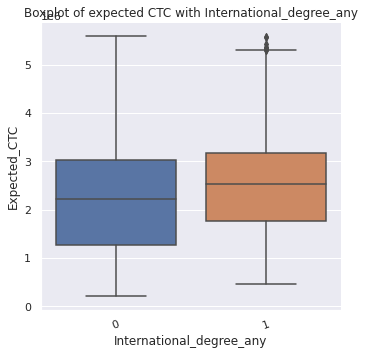

In [289]:
cat_plot1(df,"International_degree_any")

##### Assessing outliers in the data

In [290]:
def number_of_outliers(df):
    IQR = df.quantile(0.75) - df.quantile(0.25)
    Number = ((df > (df.quantile(0.75)+(1.5*IQR))) | (df < (df.quantile(0.25)-(1.5*IQR)))).sum()
    Outlier = ((df > (df.quantile(0.75)+(1.5*IQR))) | (df < (df.quantile(0.25)-(1.5*IQR))))
    dataframe = pd.DataFrame({"Number of Outliers":Number})
    return (dataframe.sort_values(by="Number of Outliers",ascending=False))

In [291]:
Q3 = df.Relevant_experience.quantile(0.75)
Q1 = df.Relevant_experience.quantile(0.25)
IQR = Q3 - Q1
outlier_value=[]
for i in df.Relevant_experience:
  if ((i<(Q1-(1.5*IQR)))|(i>(Q3+(1.5*IQR)))):
    outlier_value.append(i)

In [292]:
list(set(outlier_value))

[24, 25]

In [293]:
filt=((df["Relevant_experience"]==24) | (df["Relevant_experience"]==25))
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
a=df.loc[filt,:]

In [294]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Willing_to_relocate'],
      dtype='object')

In [295]:
#2. Creating a feature candidate in demand for the candidates who have an offer in hand and received key performer rating in last appraisal
df["Candidate_in_demand"]=np.where(((df["Inhand_Offer"]=='Y')&(df["Last_Appraisal_Rating"]=="Key_Performer")),1,0)

In [296]:
df.groupby("Candidate_in_demand").agg({"Expected_CTC":"mean"})

Expected_CTC
Candidate_in_demand              
0                      2175148.46
1                      2762970.20

In [297]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation', 'PG_Specialization', 'University_PG',
       'Passing_Year_Of_PG', 'PHD_Specialization', 'University_PHD',
       'Passing_Year_Of_PHD', 'Curent_Location', 'Preferred_location',
       'Current_CTC', 'Inhand_Offer', 'Last_Appraisal_Rating',
       'No_Of_Companies_worked', 'Number_of_Publications', 'Certifications',
       'International_degree_any', 'Expected_CTC', 'Willing_to_relocate',
       'Candidate_in_demand'],
      dtype='object')

### Further assessment of missing values

In [298]:
null_cols=df.isnull().sum()[df.isnull().sum()!=0]
null_cols

Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
Last_Appraisal_Rating           908
dtype: int64

In [299]:
filt = ((df["Last_Appraisal_Rating"].isna()==True) & (df["Department"]=="Fresher") & (df["Role"]=="Fresher") & (df["Industry"]=="Fresher") & (df["Organization"]=="Fresher") & (df["Designation"]=="Fresher"))
df.loc[filt,["Department","Role","Industry","Organization","Designation"]].shape

(908, 5)

In [300]:
df["Last_Appraisal_Rating"].dtypes

dtype('O')

In [301]:
#Imputing missing values in Last_appraisal_rating. Wherever the last_appraisal_rating is missing fresher is being 
#imputed
df["Last_Appraisal_Rating"]=np.where(filt,"Fresher",df["Last_Appraisal_Rating"])

In [302]:
def null_cols(df):
  null_cols=df.isnull().sum()[df.isnull().sum()!=0]
  return null_cols

In [303]:
null_cols(df)

Graduation_Specialization      6180
University_Grad                6180
Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
dtype: int64

##### On investigating the reason of missing values in the column Graduation specialization, University grad, and passing year of graduation, it was found that the education for these records was 'Under grad' i.e., they were not even graduated

In [304]:
filt1 = ((df["Graduation_Specialization"].isna()==True) & (df["University_Grad"].isna()==True) & (df["Passing_Year_Of_Graduation"].isna()==True))
df.loc[filt1,"Education"].shape

(6180,)

In [305]:
#Wherever graduation specialization, university graduation, and passing year of graduation are null
#Education is under grad which means the candidate is not even graduate
df.loc[filt1,"Education"].unique()

array(['Under Grad'], dtype=object)

In [306]:
null_cols1 = null_cols(df)
null_cols1[:3].index

Index(['Graduation_Specialization', 'University_Grad',
       'Passing_Year_Of_Graduation'],
      dtype='object')

In [307]:
#Consequently, the values in these columns were imputed as Did not do graduation
for i in null_cols1[:2].index.tolist():
  df[i]=np.where(df[i].isna()==True,"Did not do graduation",df[i])

In [308]:
null_cols1 = null_cols(df)
null_cols1

Passing_Year_Of_Graduation     6180
PG_Specialization              7692
University_PG                  7692
Passing_Year_Of_PG             7692
PHD_Specialization            11881
University_PHD                11881
Passing_Year_Of_PHD           11881
dtype: int64

In [309]:
def corr_heatmap(data):
    cm=data.corr()
    #plt.figure(figsize=())
    sns.heatmap(cm,cbar=True,annot=True,fmt=".2f",lw=0.5,mask=np.triu(cm,+1))

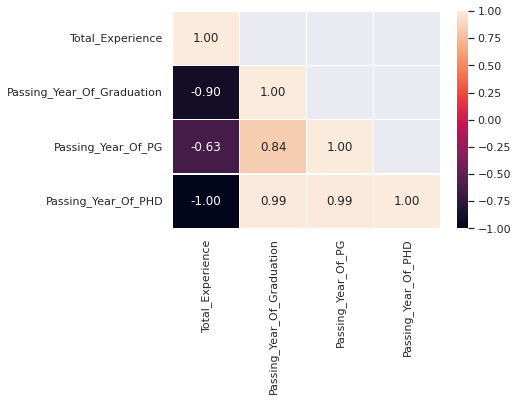

In [310]:
#Assessing the correlation between passing year of graduation, PG, and/or PHD with Total experience. Prima facie, they might be strongly 
#correlated with each other
data1 = df[["Total_Experience","Passing_Year_Of_Graduation","Passing_Year_Of_PG","Passing_Year_Of_PHD"]]
corr_heatmap(data1)


In [311]:
#Since passing year of graduation, passing year of PG, and passing year of PHD are highly correlated with 
#total experience. I  am choosing to drop them.
df.drop(columns=["Passing_Year_Of_Graduation","Passing_Year_Of_PG","Passing_Year_Of_PHD"],axis=1,inplace=True)

In [312]:
null_cols1 = null_cols(df)
null_cols1

PG_Specialization      7692
University_PG          7692
PHD_Specialization    11881
University_PHD        11881
dtype: int64

##### On further investigating the missing values in columns like PG Specialization and University PG. It was found that 6180 candidates who are not even graduated have their PG specialization and University pg fields missing

In [313]:
filt1 = ((df["PG_Specialization"].isna()==True) & (df["University_PG"].isna()==True))
df.loc[filt1,"Education"].shape

(7692,)

In [314]:
df.loc[filt1,"Education"].unique()

array(['PG', 'Under Grad', 'Grad', 'Doctorate'], dtype=object)

In [315]:
#filt2 = ((df["Education"]=="Grad") | (df["Education"]=="Under Grad"))
filt3 = (df["Education"]=="Under Grad")
df.loc[filt3,["PG_Specialization","University_PG","Education"]].isnull().sum()
#6180 candidates who are not even graduated have their PG specialization and University pg fields missing

PG_Specialization    6180
University_PG        6180
Education               0
dtype: int64

In [316]:
df.loc[filt3,["PG_Specialization","University_PG","Education"]].shape

(6180, 3)

In [317]:
null_cols1 = null_cols(df)
null_cols1[-2:].index

Index(['PHD_Specialization', 'University_PHD'], dtype='object')

In [318]:
for i in null_cols1[:2].index:
  df[i]=np.where(df["Education"]=="Under Grad","Did not do PG",df[i])

In [319]:
null_cols1 = null_cols(df)
null_cols1

PG_Specialization      1512
University_PG          1512
PHD_Specialization    11881
University_PHD        11881
dtype: int64

In [320]:
filt4 =((df["PHD_Specialization"].isna()==True) & (df["University_PHD"].isna()==True) & (df["Education"].isin(["Grad","Under Grad","PG"])))
filt5 = df["Education"].isin(["Grad","Under Grad","PG"])
#df.loc[filt4,"Education"].shape
df.loc[filt4,"Education"].unique()
#df.loc[filt4].shape
#df.loc[filt5,["PHD_Specialization","University_PHD"]].head()

array(['PG', 'Under Grad', 'Grad'], dtype=object)

In [321]:
for i in null_cols1[-2:].index:
  df[i]=np.where(df["Education"].isin(["Grad","Under Grad","PG"]),"Did not do PHD",df[i])

In [322]:
null_cols1 = null_cols(df)
null_cols1

PG_Specialization     1512
University_PG         1512
PHD_Specialization    1918
University_PHD        1918
dtype: int64

In [323]:
filt1 = ((df["PG_Specialization"].isna()==True) & (df["University_PG"].isna()==True))
filt2 = df["Education"].isin(["Under Grad","Grad"])
df.loc[(filt1 & filt2),["Education"]].index

Int64Index([   43,    98,   105,   225,   231,   260,   366,   385,   442,
              499,
            ...
            24421, 24438, 24443, 24449, 24477, 24517, 24846, 24862, 24885,
            24926],
           dtype='int64', length=484)

In [324]:
df.columns.tolist().index("University_PG")

11

In [325]:
for i in df.loc[(filt1 & filt2),["Education"]].index:
  df.iloc[i,[10,11]]=["Did not do PG","Did not do PG"]

In [326]:
null_cols1 = null_cols(df)
null_cols1

PG_Specialization     1028
University_PG         1028
PHD_Specialization    1918
University_PHD        1918
dtype: int64

In [327]:
# 506 candidates with Doctorate level of education have PG specialization, university PG, PHD specialization, university PHD
# missing

In [328]:
PHD_missing = ((df["PHD_Specialization"].isna()==True)&(df["University_PHD"].isna()==True))
PG_missing = ((df["PG_Specialization"].isna()==True)&(df["University_PG"].isna()==True))

In [329]:
data1=df.loc[PHD_missing]
data1.groupby("Education")["Role"].count()

Education
Doctorate    1918
Name: Role, dtype: int64

In [330]:
# All the candidates who have University PHD and PHD specialization missing have Doctorate level of education

In [331]:
data2 = df.loc[PG_missing]
data2.groupby("Education")["Role"].count()

Education
Doctorate    506
PG           522
Name: Role, dtype: int64

In [332]:
null_cols1 = null_cols(df)
null_cols1

PG_Specialization     1028
University_PG         1028
PHD_Specialization    1918
University_PHD        1918
dtype: int64

In [333]:
df1=df.copy()
df1.drop(columns=null_cols1.index,axis=1,inplace=True)

In [334]:
df1.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad', 'Curent_Location',
       'Preferred_location', 'Current_CTC', 'Inhand_Offer',
       'Last_Appraisal_Rating', 'No_Of_Companies_worked',
       'Number_of_Publications', 'Certifications', 'International_degree_any',
       'Expected_CTC', 'Willing_to_relocate', 'Candidate_in_demand'],
      dtype='object')

In [335]:
## This implies that 1028 candidates who are atleast post graduate have their PG university and PG specialization missing
## 1918 who all are doctorate have their PHD university and PHD specialization missing

In [336]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad', 'PG_Specialization',
       'University_PG', 'PHD_Specialization', 'University_PHD',
       'Curent_Location', 'Preferred_location', 'Current_CTC', 'Inhand_Offer',
       'Last_Appraisal_Rating', 'No_Of_Companies_worked',
       'Number_of_Publications', 'Certifications', 'International_degree_any',
       'Expected_CTC', 'Willing_to_relocate', 'Candidate_in_demand'],
      dtype='object')

#### Assessing the correlation among the categorical and numerical features. Dython was used to assess the correlation.

#### More information on Dython can be found [here](https://pypi.org/project/dython).

In [337]:
#!pip install dython

In [338]:
#import dython

In [339]:
#from dython.nominal import associations
#plt.figure(figsize=(20,50))
#assoc=associations(df,plot=False,clustering=True)
#correlations=assoc['corr']
#correlations,_=cluster_correlations(correlations)

In [340]:
# #Heatmap of the correlation among all the variables of the dataset regardless whether they are categorical or numerical
# # plt.figure(figsize=(20,20))
# sns.heatmap(assoc["corr"],annot=True,fmt='.2f',cbar=True,lw=0.5);

In [341]:
#data=assoc['corr']

In [342]:
#data.loc[data.index=="Expected_CTC"].T.sort_values(by="Expected_CTC",ascending=True)

##### Feature selection based on correlation

In [343]:
## Dropping variables based on correlation. These features had minimum correlation with the target variable hence they were dropped.
## Besides, 

df.drop(columns=["Curent_Location","Preferred_location","University_PG","PG_Specialization","Number_of_Publications","Willing_to_relocate"],axis=1,inplace=True)

### Observations based on correlation

1. Current location and preferred location are giving little to no information about expected CTC. 
2.	University grad and university pg are same for 17K+ records 
3.	Grad specialization and PG specialization are same for 14K+ records
4.	This pattern of specialization and university is not same for PG and PHD
5.	Surprisingly, certifications have a negative impact on expected CTC which means rising number of certifications may not be good which can further mean company is looking for specialists not generalists assuming certifications are of different nature





In [344]:
#df.to_csv("Output1.csv",index=False)

In [345]:
from google.colab import files
#files.download("Output1.csv")

###### It was decided to drop the missing values altogether

In [346]:
#Dropping null values
df.dropna(inplace=True)

### Feature selection using mutual information gain

In [347]:
cat_col1 = df.select_dtypes(exclude=['int','float']).columns.tolist()

In [348]:
df_dummy = pd.get_dummies(data=df,columns=cat_col1,drop_first=True)

In [349]:
X_dummy = df_dummy.drop("Expected_CTC",axis=1)
Y_dummy = df_dummy["Expected_CTC"]
X = df.drop("Expected_CTC",axis=1)
Y = df["Expected_CTC"]

In [350]:
print(X_dummy.shape)
print(X.shape)
print(Y_dummy.shape)
print(Y.shape)

(23082, 145)
(23082, 19)
(23082,)
(23082,)


In [351]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
X_dummy_train,X_test_dummy,Y_train,Y_test = train_test_split(X_dummy,Y,test_size=0.3,random_state=1)

In [352]:
from sklearn.feature_selection import mutual_info_regression

In [353]:
arr2=mutual_info_regression(X_dummy_train,Y_train)

In [354]:
mutual_information_features = pd.DataFrame(index=X_dummy_train.columns,data=arr2,columns=["Gain"])
data = mutual_information_features.sort_values(by="Gain",ascending=False)

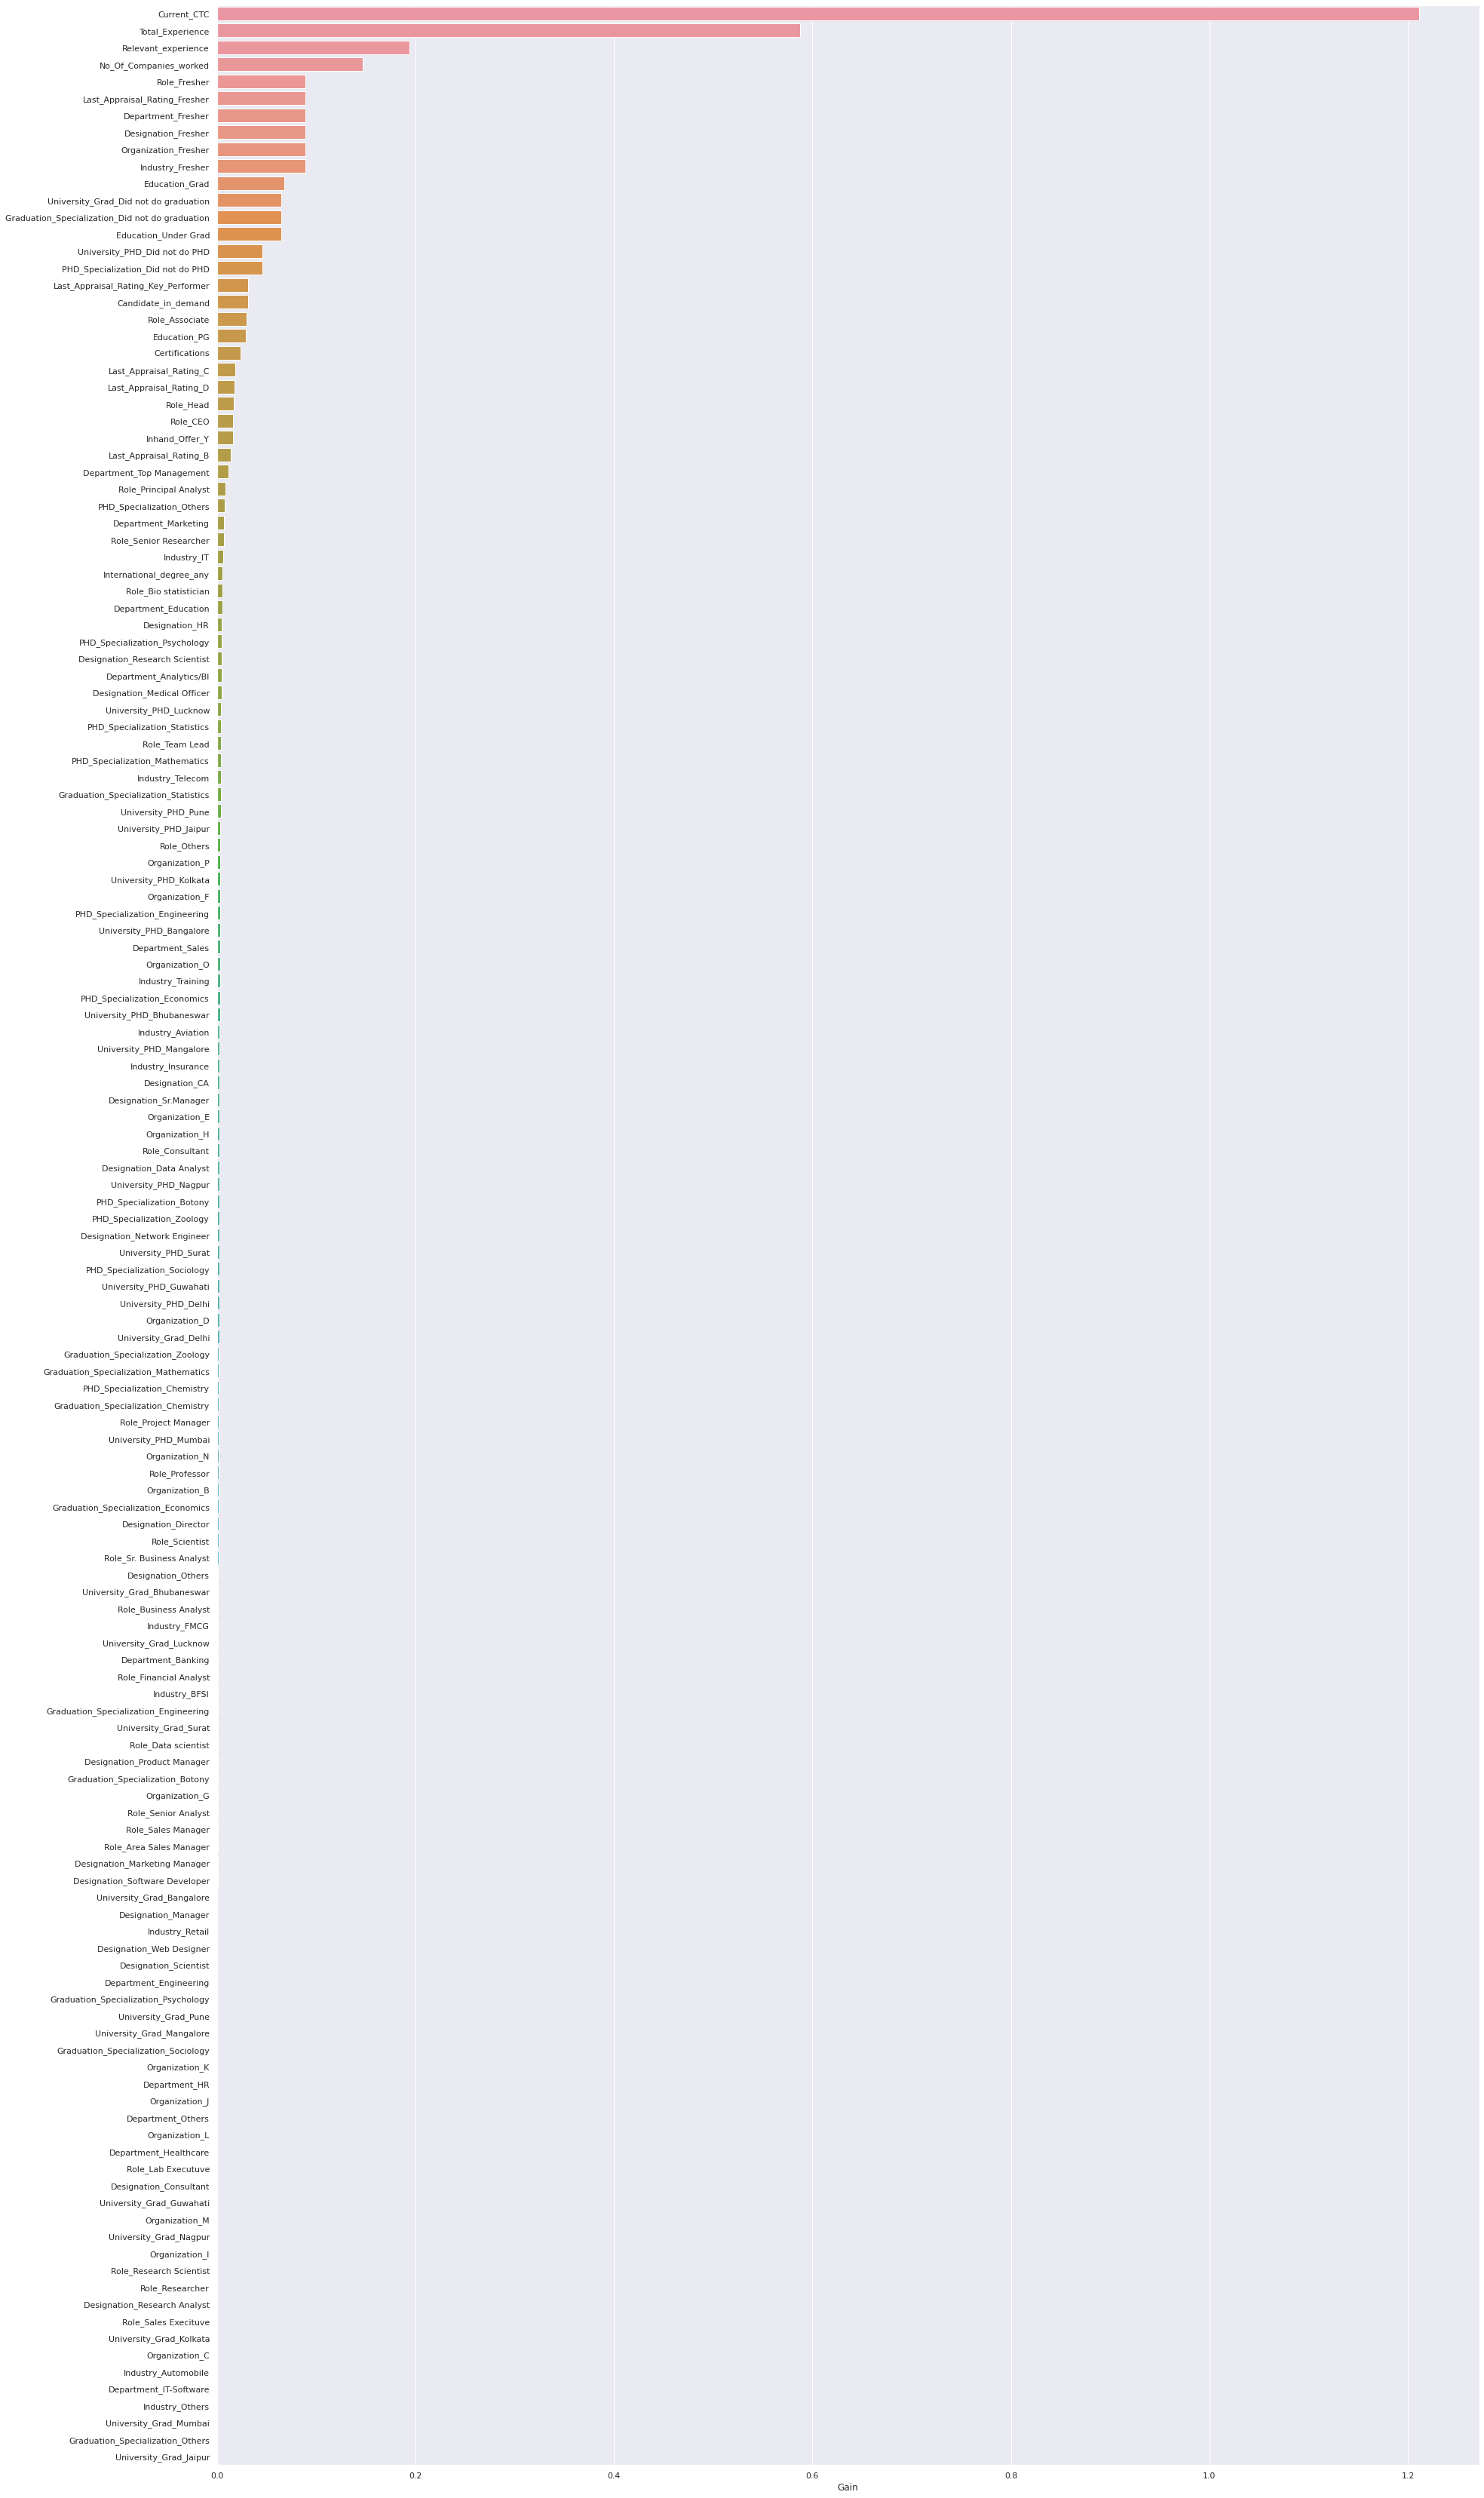

In [355]:
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(30,60))
sns.barplot(x=data["Gain"],y=data.index)

In [356]:
#Eliminating all the features which do not convey any information about the outcome at all

In [357]:
zero_gain_features=data.loc[data["Gain"]==0].index.tolist()
len(zero_gain_features)

22

In [358]:
zero_gain_features

['Organization_J',
 'Department_Others',
 'Organization_L',
 'Department_Healthcare',
 'Role_Lab Executuve',
 'Designation_Consultant',
 'University_Grad_Guwahati',
 'Organization_M',
 'University_Grad_Nagpur',
 'Organization_I',
 'Role_Research Scientist',
 'Role_Researcher',
 'Designation_Research Analyst',
 'Role_Sales Execituve',
 'University_Grad_Kolkata',
 'Organization_C',
 'Industry_Automobile',
 'Department_IT-Software',
 'Industry_Others',
 'University_Grad_Mumbai',
 'Graduation_Specialization_Others',
 'University_Grad_Jaipur']

In [359]:
X_dummy_train.drop(columns=zero_gain_features,inplace=True,axis=1)

In [360]:
X_test_dummy.drop(columns=zero_gain_features,inplace=True,axis=1)

In [361]:
#X_dummy.drop(columns=zero_gain_features,inplace=True,axis=1)
print(X_dummy.shape)

(23082, 145)


In [362]:
# Out of 145, 23 features were dropped as they were not conveying any information about the outcome at all

In [363]:
df.drop(columns=["Candidate_in_demand"],axis=1,inplace=True)

In [364]:
df["Inhand_Offer"] = df["Inhand_Offer"].map({"N":0,"Y":1})

In [365]:
df1 = df.copy()

In [366]:
df = df1.copy()

In [367]:
df.columns

Index(['Total_Experience', 'Relevant_experience', 'Department', 'Role',
       'Industry', 'Organization', 'Designation', 'Education',
       'Graduation_Specialization', 'University_Grad', 'PHD_Specialization',
       'University_PHD', 'Current_CTC', 'Inhand_Offer',
       'Last_Appraisal_Rating', 'No_Of_Companies_worked', 'Certifications',
       'International_degree_any', 'Expected_CTC'],
      dtype='object')

In [368]:
##Removing features like University_Grad and University_PHD. As these features anyway bring some biasness to the result
df.drop(columns=['University_Grad','University_PHD'],axis=1,inplace=True)

### Modeling starts

In [369]:
#1. Linear Regression

#Pre-processing the data for Linear Regression

df.replace(to_replace="Sr. Business Analyst",value="Senior Business Analyst",inplace=True)
df.replace(to_replace='Sr.Manager',value="Senior Manager",inplace=True)
df.replace(to_replace='Analytics/BI',value="Analytics or BI",inplace=True)
df.replace(to_replace='IT-Software',value="IT and Software",inplace=True)

In [370]:
##Saving a copy of dataframe before one-hot encoding the dataframe
data = df.copy()

In [371]:
#One-hotencoding

def ohe(df):
  cat_col = df.select_dtypes(exclude=[np.number]).columns.tolist()
  df = pd.get_dummies(data=df,columns=cat_col)
  new = []
  for i in df.columns:
    new.append("_".join(i.split()))
  for (i,j) in zip(df.columns,new):
    df.rename(columns={i:j},inplace=True)
  return df,list(df.columns)

In [372]:
df,list1 = ohe(df)

In [373]:
df_127 = df.copy()

In [374]:
print("At the first instance after doing one-hot encoding the dataset has {} features".format((df.shape[1])-1))

At the first instance after doing one-hot encoding the dataset has 127 features


In [375]:
#Removing some of the columns to compare the coefficients of the features against
cols = ['Department_Others','Role_Others','Industry_Others','Organization_O','Education_Grad','Graduation_Specialization_Did_not_do_graduation','Designation_Others','Last_Appraisal_Rating_D']

In [376]:
#Dropping the columns
def cols_to_be_dropped(df,cols):
  df.drop(columns=cols,axis=1,inplace=True)
  return df

In [377]:
df=cols_to_be_dropped(df,cols)

In [378]:
print("After removing some columns from the dataset against which the coefficients of the feature can be compared the dataset has {} features".format((df.shape[1])-1))

After removing some columns from the dataset against which the coefficients of the feature can be compared the dataset has 119 features


### VIF

In [379]:
import statsmodels.formula.api as sm
def vif_cal(input_data):
    x_vars=input_data
    xvar_names=input_data.columns
    VIF = []
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        VIF.append(vif)
        #print (xvar_names[i], " VIF = " , vif)
    df = pd.DataFrame(index=xvar_names,data=VIF,columns=["VIF"])
    return df.sort_values(by='VIF',ascending=False)

In [380]:
input_data = df.drop(columns=["Expected_CTC",'PHD_Specialization_Others','Organization_Fresher', 'Role_Fresher', 'Industry_Fresher', 'Department_Fresher','PHD_Specialization_Did_not_do_PHD','Graduation_Specialization_Others','Designation_Fresher'],axis=1)

In [381]:
input_data.shape

(23082, 111)

In [382]:
VIF_df = vif_cal(input_data)

In [383]:
VIF_df.loc[VIF_df["VIF"]==np.inf].shape

(0, 1)

In [384]:
##Observation : 
#After running 1st iteration, 31 features had infinite VIF which means they were completely explained by rest of the features
#After running 2nd iteration where 'PHD_Specialization_Others' was removed, 20 features had infinite VIF
#In the 3rd iteration i.e., after running 2nd iteration I decided to drop 'Organization_Fresher', 'Role_Fresher', 'Industry_Fresher', 'Department_Fresher' because having 'Last_Appraisal_Rating_Fresher'
#will give me sufficient information i.e., candidate is a fresher. Doing so, 16 features had infinite VIF
#In the 4th iteration 'PHD_Specialization_Did_not_do_PHD' was removed, 14 features had infinite VIF
#In the 5th iteration 'Graduation_Specialization_Others','Designation_Fresher' were removed, 0 features had infinite VIF

In [385]:
VIF_df.loc[VIF_df["VIF"]==np.inf].index

Index([], dtype='object')

In [386]:
VIF_df.sort_values(by="VIF",ascending=False).head(30)

VIF
Education_Doctorate                   7.82
Total_Experience                      5.45
Current_CTC                           5.38
Education_Under_Grad                  4.62
Last_Appraisal_Rating_Fresher         3.67
Graduation_Specialization_Chemistry   2.19
PHD_Specialization_Chemistry          2.17
Graduation_Specialization_Economics   2.16
PHD_Specialization_Economics          2.15
Graduation_Specialization_Mathematics 2.14
Graduation_Specialization_Statistics  2.12
Graduation_Specialization_Engineering 2.12
PHD_Specialization_Engineering        2.11
Department_Analytics_or_BI            2.09
Graduation_Specialization_Arts        2.08
Department_Marketing                  2.06
Graduation_Specialization_Psychology  2.06
Graduation_Specialization_Sociology   2.06
PHD_Specialization_Mathematics        2.05
Graduation_Specialization_Zoology     2.04
PHD_Specialization_Statistics         2.04
Graduation_Specialization_Botony      2.02
Department_Top_Management             1.98
Department_Healthcare                 1.95
Organization_M                        1.94
Industry_Training                     1.93
Organization_A                        1.93
Organization_H                        1.93
Organization_J                        1.93
Industry_Aviation                     1.93

In [387]:
#features removed to bring the VIF down to less than 10
VIF_Features=['PHD_Specialization_Others','Organization_Fresher', 'Role_Fresher', 'Industry_Fresher', 'Department_Fresher','PHD_Specialization_Did_not_do_PHD','Graduation_Specialization_Others','Designation_Fresher']

#### Statsmodels

In [388]:
def model(target,features,df):
  import statsmodels.formula.api as sm
  formula = str(target)+"~"+"+".join(features)
  model = sm.ols(formula,df).fit()
  return model

In [389]:
features = df.drop(columns=["Expected_CTC",'Education_Doctorate','PHD_Specialization_Statistics','PHD_Specialization_Others','Organization_Fresher', 'Role_Fresher', 'Industry_Fresher', 'Department_Fresher','PHD_Specialization_Did_not_do_PHD','Graduation_Specialization_Others','Designation_Fresher'],axis=1).columns.tolist()

In [390]:
print("For OLS {} features were given to the dataset".format(len(features)))

For OLS 109 features were given to the dataset


In [391]:
model=model('Expected_CTC',features,df)

In [392]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Expected_CTC   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.087e+04
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:09:10   Log-Likelihood:            -2.9384e+05
No. Observations:               23082   AIC:                         5.879e+05
Df Residuals:                   22972   BIC:                         5.888e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.826e+05   5216.338    -35.000      0.000   -1.93e+05   -1.72e+05
Total_Experience                      -3382.9296    166.714    -20.292      0.000   -3709.699   -3056.160
Relevant_experience                     -33.4911    121.915     -0.275      0.784    -272.453     205.471
Current_CTC                               1.2878      0.001    957.174      0.000       1.285       1.290
Inhand_Offer                           5.883e+04   1459.253     40.313      0.000     5.6e+04    6.17e+04
No_Of_Companies_worked                 -558.3011    367.964     -1.517      0.129   -1279.536     162.934
Certifications                        -4234.5481    531.168     -7.972      0.000   -5275.672   -3193.424
International_degree_any               1384.0938   2679.266      0.517      0.605   -3867.448    6635.636
Department_Accounts                    1.064e+04   3147.945      3.381      0.001    4472.621    1.68e+04
Department_Analytics_or_BI             3433.5153   2689.263      1.277      0.202   -1837.622    8704.652
Department_Banking                     2187.5613   2636.292      0.830      0.407   -2979.749    7354.872
Department_Education                   1.171e+04   2653.144      4.414      0.000    6510.023    1.69e+04
Department_Engineering                 2739.7199   2628.848      1.042      0.297   -2412.999    7892.439
Department_HR                          2420.1237   2597.732      0.932      0.352   -2671.607    7511.854
Department_Healthcare                  3377.5201   2642.437      1.278      0.201   -1801.833    8556.874
Department_IT_and_Software             2260.6448   3180.785      0.711      0.477   -3973.908    8495.197
Department_Marketing                   5617.5187   2473.613      2.271      0.023     769.070    1.05e+04
Department_Sales                       4349.2645   2607.372      1.668      0.095    -761.360    9459.889
Department_Top_Management             -1022.3306   2959.297     -0.345      0.730   -6822.752    4778.090
Role_Analyst                           2584.5708   2725.199      0.948      0.343   -2757.003    7926.145
Role_Area_Sales_Manager                3093.0743   7974.170      0.388      0.698   -1.25e+04    1.87e+04
Role_Associate                         1971.6007   3688.116      0.535      0.593   -5257.354    9200.555
Role_Bio_statistician                  3052.8926   2712.583      1.125      0.260   -2263.953    8369.738
Role_Business_Analyst                  1503.1653   2830.217      0.531      0.595   -4044.251    7050.581
Role_CEO                              -5581.2091   3454.819     -1.615      0.106   -1.24e+04    1190.469
Role_Consultant                        4581.2770   2766.165      1.656      0.098    -840.592       1e+04
Role_Data

In [393]:
## There is still some multicollinearity problems but as the features having high VIF are seemingly important in predicting the target
# we will go ahead with this model and use ridge/lasso to work with multicollinearity/feature selection respectively

In [394]:
df.drop(columns=['Education_Doctorate','PHD_Specialization_Statistics','PHD_Specialization_Others','Organization_Fresher', 'Role_Fresher', 'Industry_Fresher', 'Department_Fresher','PHD_Specialization_Did_not_do_PHD','Graduation_Specialization_Others','Designation_Fresher'],axis=1,inplace=True)

In [395]:
df_109 = df.copy()

#### Significant features

In [396]:
def generating_coef_table(lr_mod):
  coef_table =pd.read_html(lr_mod.summary2().as_html())[1]
  coef_table.drop(0,axis=0,inplace=True)
  coef_table.columns = ["var_name","coef","std_err","t_stat","p_val","cof_25","conf_975"]
  sig_features = list(coef_table.loc[coef_table["p_val"].astype('float') <= 0.05, "var_name"].values)
  sig_features = [x for x in sig_features if x != "Intercept"]
  sig_coef=coef_table.loc[coef_table["var_name"].isin(sig_features),["var_name","coef"]]
  sig_coef["coef"]=sig_coef["coef"].astype('float')
  #return sig_coef
  import seaborn as sns
  import matplotlib.pyplot as plt
  plt.figure(figsize=(12,12))
  p=sns.barplot(y=sig_coef["var_name"],x=sig_coef["coef"],order=sig_coef.sort_values(by="coef",ascending=False).var_name)
  p.set_title("Coefficients of the significant features")
  p.set_xlabel("Coefficients")
  p.set_ylabel("Name of the features")
  sns.set_style('darkgrid')
  plt.show()
  return sig_features

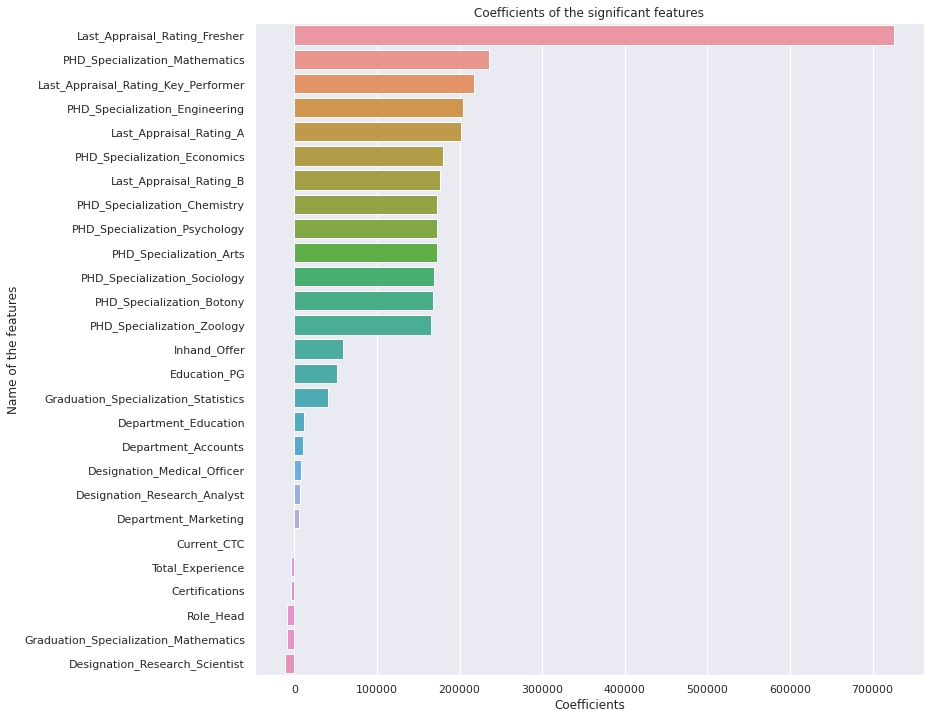

In [397]:
#Assessing the features which were significant. Out of 109 features, 27 features were significant
sig_coef=generating_coef_table(model)
#sig_coef.var_name.unique()

In [398]:
sig_features_lr=sig_coef
len(sig_features_lr)

27

In [399]:
print("When {} features were given to the dataset, {} were only significant".format(len(features),len(sig_features_lr)))

When 109 features were given to the dataset, 27 were only significant


### Model's predictive performance

In [400]:
print("At this instance, I am giving all the features even without drop_first setting true i.e., this dataset has {} features".format(df.shape[1]-1))

At this instance, I am giving all the features even without drop_first setting true i.e., this dataset has 109 features


In [401]:
X = df_127.drop(columns=["Expected_CTC"],axis=1)
Y = df_127["Expected_CTC"]
X1 = df_109.drop(columns=["Expected_CTC"],axis=1)
Y1 = df_109["Expected_CTC"]

In [402]:
from sklearn.metrics import r2_score
def linear_regression(X,Y,model_name):
  from sklearn.linear_model import LinearRegression
  from sklearn.model_selection import train_test_split
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  lr = LinearRegression()
  lr.fit(X_train,Y_train)
  train_pred = lr.predict(X_train)
  test_pred = lr.predict(X_test)
  from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
  rmse_train = mean_squared_error(train_pred,Y_train,squared=False)
  mae_train = mean_absolute_error(train_pred,Y_train)
  mape_train = mean_absolute_percentage_error(train_pred,Y_train)
  r_sq_train = r2_score(train_pred,Y_train)
  rmse_test = mean_squared_error(test_pred,Y_test,squared=False)
  mae_test = mean_absolute_error(test_pred,Y_test)
  mape_test = mean_absolute_percentage_error(test_pred,Y_test)
  r_sq_test = r2_score(test_pred,Y_test)
  Metrics1 = pd.DataFrame(index=["Train_RMSE","Test_RMSE","Train_MAE","Test_MAE","Train R-squared","Test R-squared"],columns=[model_name],data=[rmse_train,rmse_test,mae_train,mae_test,r_sq_train,r_sq_test])
  return Metrics1

In [403]:
Metrics = pd.DataFrame()

In [404]:
Metrics=linear_regression(X,Y,"LR:with 127 features")
Metrics

LR:with 127 features
Train_RMSE                   71944.33
Test_RMSE                    73825.19
Train_MAE                    48826.28
Test_MAE                     49343.86
Train R-squared                  1.00
Test R-squared                   1.00

In [405]:
Metrics2=linear_regression(X1,Y1,"LR:with no infinite VIF")
Metrics = pd.concat([Metrics,Metrics2],axis=1)

In [406]:
Metrics

LR:with 127 features  LR:with no infinite VIF
Train_RMSE                   71944.33                 81056.73
Test_RMSE                    73825.19                 83581.19
Train_MAE                    48826.28                 56410.65
Test_MAE                     49343.86                 56969.58
Train R-squared                  1.00                     0.99
Test R-squared                   1.00                     0.99

In [407]:
#As the train and test rmse are different from each other. It is clear that the model is overfitting a bit since Test RMSE is larger than
#train RMSE

### Tackling overfitting 

In [408]:
#Strategy #1: Capping outliers

def number_of_outliers(df):
    IQR = df.quantile(0.75) - df.quantile(0.25)
    Number = ((df > (df.quantile(0.75)+(1.5*IQR))) | (df < (df.quantile(0.25)-(1.5*IQR)))).sum()
    Outlier = ((df > (df.quantile(0.75)+(1.5*IQR))) | (df < (df.quantile(0.25)-(1.5*IQR))))
    dataframe = pd.DataFrame({"Number of Outliers":Number})
    return (dataframe.sort_values(by="Number of Outliers",ascending=False))

In [409]:
outliers=number_of_outliers(data)

In [410]:
outliers

Number of Outliers
Certifications                           2943
International_degree_any                 1901
Relevant_experience                       108
Role                                        0
PHD_Specialization                          0
Organization                                0
No_Of_Companies_worked                      0
Last_Appraisal_Rating                       0
Inhand_Offer                                0
Current_CTC                                 0
Industry                                    0
Graduation_Specialization                   0
Expected_CTC                                0
Education                                   0
Designation                                 0
Department                                  0
Total_Experience                            0

In [411]:
# There aren't many outliers to cap. Whatever, there are they are present in discrete features so I decided not to cap them

In [412]:
# Strategy #2: Regularization

from sklearn.linear_model import Ridge,RidgeCV

In [413]:
rcv = RidgeCV()

In [414]:
X = df_127.drop(columns=["Expected_CTC"],axis=1)
Y = df_127["Expected_CTC"]

In [415]:
#Scaling the data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_sc = pd.DataFrame(data=ss.fit_transform(X1),columns=X1.columns)

In [416]:
len(X_sc.columns)

109

In [417]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [418]:
#rcv=RidgeCV(np.linspace(0.001,30,2000),cv=kf,scoring=None)
#rcv.fit(X_sc,Y)

In [419]:
#rcv.alpha_

In [420]:
#Best alpha over the range of 0.001 to 30 came out to be 1.01

In [421]:
best_ridge = Ridge(alpha=1.01)

In [422]:
from sklearn.metrics import r2_score
def ridge_regression(X,Y,alpha,model_name):
  from sklearn.linear_model import LinearRegression
  from sklearn.model_selection import train_test_split
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train,Y_train)
  train_pred = ridge.predict(X_train)
  test_pred = ridge.predict(X_test)
  from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
  rmse_train = mean_squared_error(train_pred,Y_train,squared=False)
  mae_train = mean_absolute_error(train_pred,Y_train)
  mape_train = mean_absolute_percentage_error(train_pred,Y_train)
  r_sq_train = r2_score(train_pred,Y_train)
  rmse_test = mean_squared_error(test_pred,Y_test,squared=False)
  mae_test = mean_absolute_error(test_pred,Y_test)
  mape_test = mean_absolute_percentage_error(test_pred,Y_test)
  r_sq_test = r2_score(test_pred,Y_test)
  Metrics1 = pd.DataFrame(index=["Train_RMSE","Test_RMSE","Train_MAE","Test_MAE","Train R-squared","Test R-squared"],columns=[model_name],data=[rmse_train,rmse_test,mae_train,mae_test,r_sq_train,r_sq_test])
  features = X_train.columns
  return Metrics1,ridge,features,X_train

In [423]:
Metrics2,ridge_alpha_10,features,X_train=ridge_regression(X_sc,Y,5,"Ridge:alpha=10")
Metrics = pd.concat([Metrics,Metrics2],axis=1)

In [424]:
Metrics

LR:with 127 features  LR:with no infinite VIF  Ridge:alpha=10
Train_RMSE                   71944.33                 81056.73        81061.19
Test_RMSE                    73825.19                 83581.19        83583.49
Train_MAE                    48826.28                 56410.65        56363.26
Test_MAE                     49343.86                 56969.58        56925.04
Train R-squared                  1.00                     0.99            0.99
Test R-squared                   1.00                     0.99            0.99

In [425]:
#Since not much difference is coming in the difference between train RMSE and test RMSE or train MAE & test MAE. 
#Therefore, we will go with alpha = 5

#### Assessing the coefficients of the features from ridge regression

In [426]:
!pip install regressors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12401 sha256=f9b5005bb4ee00b7bba31a47657ff40a591660c85827b60d46f9647a90c6df35
  Stored in directory: /root/.cache/pip/wheels/5e/84/7d/c7f674a24c508709cdd3aa6cf0f129899f21061b2821ceed32
Successfully built regressors


In [427]:
import regressors

In [428]:
from regressors import stats

In [429]:
#Assessing the same for alpha = 5
ridge = Ridge(alpha=5)

In [430]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_sc,Y,test_size=0.3,random_state=1)

In [431]:
ridge.fit(X_train,Y_train)

Ridge(alpha=5)

In [432]:
pval=stats.coef_pval(ridge,X_train,Y_train)

In [433]:
pval_df = pd.DataFrame(data=pval,index=df_109.columns,columns=["p_val"])

In [434]:
sig_features_ridge_df=pval_df.loc[pval_df["p_val"]<=0.05]

In [435]:
sig_features_ridge = sig_features_ridge_df.index

In [436]:
ridge_coef = pd.DataFrame(index=features,columns=["coef"],data=ridge.coef_)

In [437]:
sig_features_coef=ridge_coef.loc[sig_features_ridge,:]

In [438]:
sig_features_coef.shape

(35, 1)

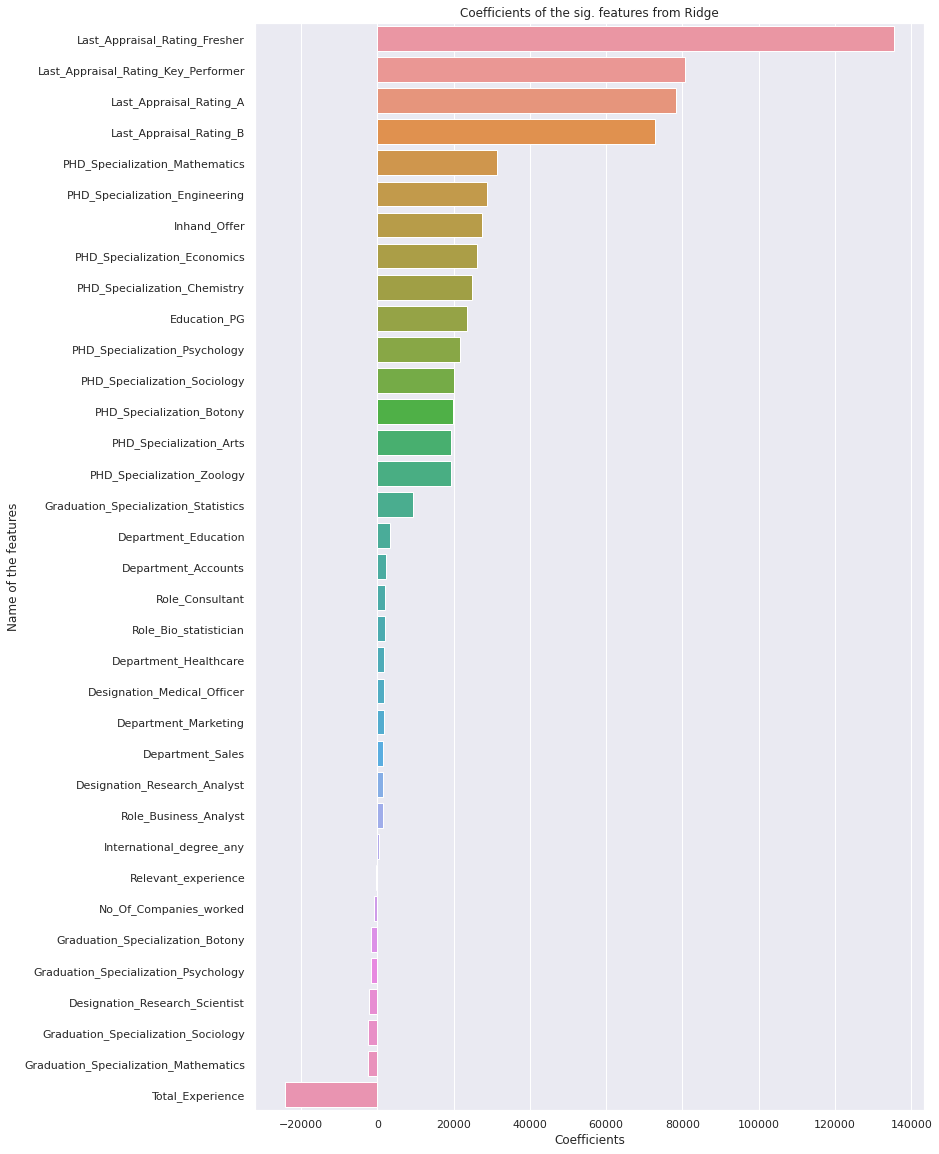

In [439]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,20))
p=sns.barplot(y=sig_features_coef.index,x=sig_features_coef["coef"],order=sig_features_coef.sort_values(by="coef",ascending=False).index)
p.set_title("Coefficients of the sig. features from Ridge")
p.set_xlabel("Coefficients")
p.set_ylabel("Name of the features")
sns.set_style('darkgrid')
plt.show()

In [440]:
#Out of 109 features, 35 features are significant

In [441]:
add_sig_features=[]
for i in sig_features_ridge:
  if i not in sig_features_lr:
    add_sig_features.append(i)
    

In [442]:
#features significant according to Ridge but not so according to linear
add_sig_features

['Relevant_experience',
 'No_Of_Companies_worked',
 'International_degree_any',
 'Department_Healthcare',
 'Department_Sales',
 'Role_Bio_statistician',
 'Role_Business_Analyst',
 'Role_Consultant',
 'Graduation_Specialization_Botony',
 'Graduation_Specialization_Psychology',
 'Graduation_Specialization_Sociology']

In [443]:
add_sig_features1=[]
for i in sig_features_lr:
  if i not in sig_features_ridge:
    add_sig_features1.append(i)

In [444]:
#features significant according to LR but not so according to Ridge
add_sig_features1

['Current_CTC', 'Certifications', 'Role_Head']

#### Lasso regression : Seeing if this will help in reducing the difference between the train and test metrics

In [445]:
from sklearn.linear_model import Lasso,LassoCV

In [446]:
lcv = LassoCV(alphas=np.linspace(0.0001,30,2000),cv=kf)
lcv.fit(X_sc,Y)

LassoCV(alphas=array([1.00000000e-04, 1.51074537e-02, 3.01149075e-02, ...,
       2.99699851e+01, 2.99849925e+01, 3.00000000e+01]),
        cv=KFold(n_splits=10, random_state=None, shuffle=False))

In [447]:
lcv.alpha_

29.984992546273133

In [448]:
from sklearn.metrics import r2_score
def lasso_regression(X,Y,alpha,model_name):
  from sklearn.linear_model import LinearRegression
  from sklearn.model_selection import train_test_split
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_train,Y_train)
  train_pred = lasso.predict(X_train)
  test_pred = lasso.predict(X_test)
  from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
  rmse_train = mean_squared_error(train_pred,Y_train,squared=False)
  mae_train = mean_absolute_error(train_pred,Y_train)
  mape_train = mean_absolute_percentage_error(train_pred,Y_train)
  r_sq_train = r2_score(train_pred,Y_train)
  rmse_test = mean_squared_error(test_pred,Y_test,squared=False)
  mae_test = mean_absolute_error(test_pred,Y_test)
  mape_test = mean_absolute_percentage_error(test_pred,Y_test)
  r_sq_test = r2_score(test_pred,Y_test)
  Metrics1 = pd.DataFrame(index=["Train_RMSE","Test_RMSE","Train_MAE","Test_MAE","Train R-squared","Test R-squared"],columns=[model_name],data=[rmse_train,rmse_test,mae_train,mae_test,r_sq_train,r_sq_test])
  features = X_train.columns
  return Metrics1,lasso,features,X_train

In [449]:
Metrics2,lasso_alpha_best,features,X_train=lasso_regression(X_sc,Y,lcv.alpha_,"Lasso:best")
Metrics = pd.concat([Metrics,Metrics2],axis=1)

In [450]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  
Train_RMSE             81061.19    81059.09  
Test_RMSE              83583.49    83559.56  
Train_MAE              56363.26    56399.75  
Test_MAE               56925.04    56935.88  
Train R-squared            0.99        0.99  
Test R-squared             0.99        0.99

In [451]:
lasso_coef = pd.DataFrame(index=X_train.columns,columns=["coef"],data=lasso_alpha_best.coef_)

In [452]:
zero_coef=lasso_coef.loc[lasso_coef["coef"]==0].index.tolist()

In [453]:
X2 = X_sc.copy()

In [454]:
X2.drop(columns=zero_coef,axis=1,inplace=True)

In [455]:
Metrics2,lasso_alpha_best,features,X_train=lasso_regression(X_sc,Y,lcv.alpha_,"Lasso:zero_coef removed")
Metrics = pd.concat([Metrics,Metrics2],axis=1)

In [456]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  
Train_RMSE             81061.19    81059.09                 81059.09  
Test_RMSE              83583.49    83559.56                 83559.56  
Train_MAE              56363.26    56399.75                 56399.75  
Test_MAE               56925.04    56935.88                 56935.88  
Train R-squared            0.99        0.99                     0.99  
Test R-squared             0.99        0.99                     0.99

##### Assessing the coefficients of the features from ridge regression

In [457]:
from regressors import stats

In [458]:
#Assessing the same for alpha = 29.98
lasso = Lasso(alpha=lcv.alpha_)

In [459]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_sc,Y,test_size=0.3,random_state=1)

In [460]:
lasso.fit(X_train,Y_train)

Lasso(alpha=29.984992546273133)

In [461]:
pval=stats.coef_pval(lasso,X_train,Y_train)

In [462]:
pval_df = pd.DataFrame(data=pval,index=df_109.columns,columns=["p_val"])

In [463]:
sig_features_lasso_df=pval_df.loc[pval_df["p_val"]<=0.05]

In [464]:
sig_features_lasso = sig_features_lasso_df.index

In [465]:
lasso_coef = pd.DataFrame(index=features,columns=["coef"],data=lasso.coef_)
sig_features_coef=lasso_coef.loc[sig_features_lasso,:]
sig_features_coef.shape

(30, 1)

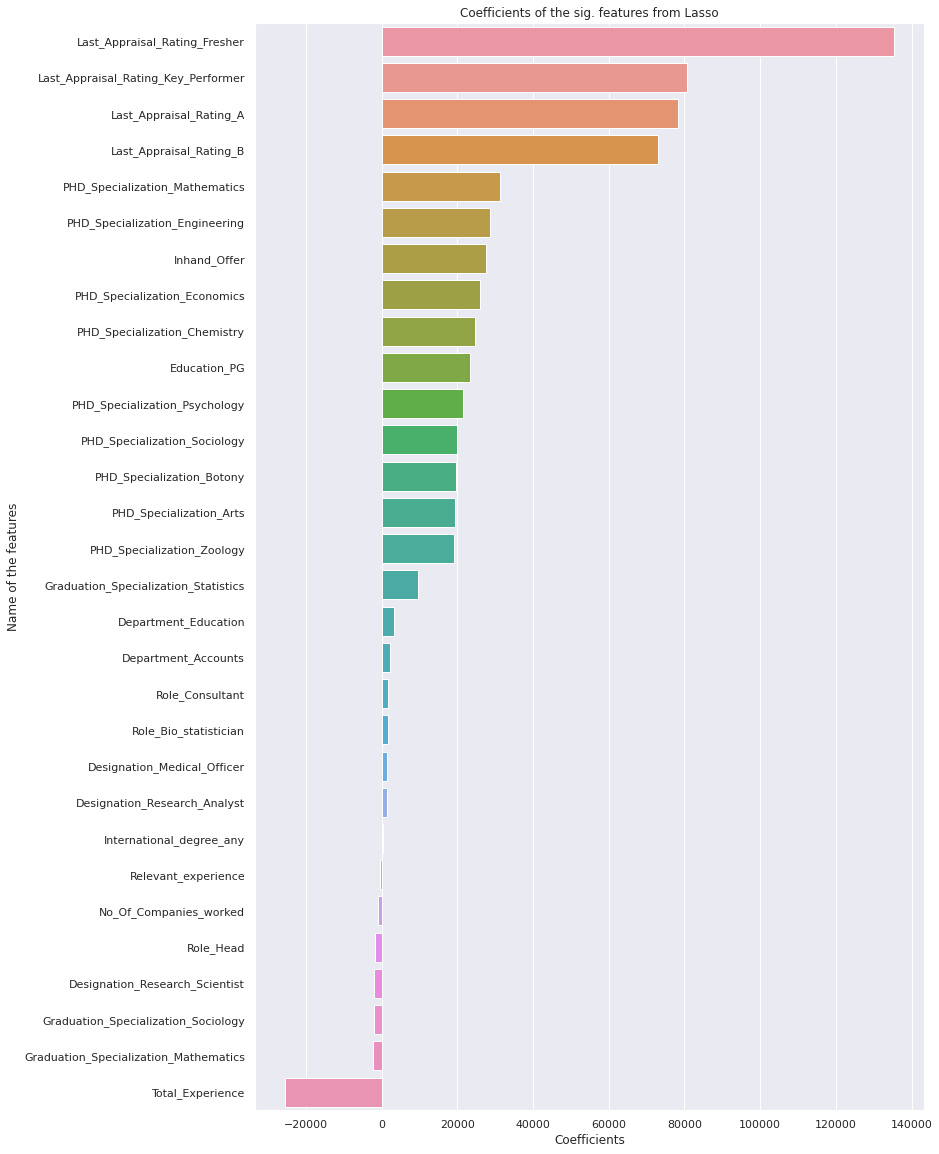

In [466]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,20))
p=sns.barplot(y=sig_features_coef.index,x=sig_features_coef["coef"],order=sig_features_coef.sort_values(by="coef",ascending=False).index)
p.set_title("Coefficients of the sig. features from Lasso")
p.set_xlabel("Coefficients")
p.set_ylabel("Name of the features")
sns.set_style('darkgrid')
plt.show()


In [467]:
print("Out of 109 features, {} features are significant".format(len(sig_features_lasso)))

Out of 109 features, 30 features are significant


In [468]:
add_sig_features=[]
for i in sig_features_lasso:
  if i not in sig_features_lr:
    add_sig_features.append(i)

In [469]:
#features significant according to Lasso but not so according to linear
add_sig_features

['Relevant_experience',
 'No_Of_Companies_worked',
 'International_degree_any',
 'Role_Bio_statistician',
 'Role_Consultant',
 'Graduation_Specialization_Sociology']

In [470]:
add_sig_features1=[]
for i in sig_features_lr:
  if i not in sig_features_lasso:
    add_sig_features1.append(i)

In [471]:
#features significant according to LR but not so according to Lasso
add_sig_features1

['Current_CTC', 'Certifications', 'Department_Marketing']

##### Conclusion
###### Linear regression models be it OLS,Lasso,or Ridge have more or less same accuracy but the significance of coefficients is varying this issue can be sorted by sampling more data

In [472]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

In [473]:
def metrics(Y_test,test_pred):
  rmse = mean_squared_error(Y_test,test_pred,squared=False)
  mae = mean_absolute_error(Y_test,test_pred)
  mape = mean_absolute_percentage_error(Y_test,test_pred)
  return rmse,mae,mape

#### Decision tree

In [474]:
from sklearn.tree import DecisionTreeRegressor

In [475]:
X = df_127.drop("Expected_CTC",axis=1)
Y = df_127["Expected_CTC"]

In [476]:
print(X.shape)
print(Y.shape)

(23082, 127)
(23082,)


In [477]:
dtr = DecisionTreeRegressor()

In [478]:
from sklearn.model_selection import train_test_split

In [479]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

In [480]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16157, 127)
(6925, 127)
(16157,)
(6925,)


In [481]:
dtr.fit(X_train,Y_train)

DecisionTreeRegressor()

In [482]:
train_pred_dtr = dtr.predict(X_train)
test_pred_dtr = dtr.predict(X_test)
rmse_train_dtr,mae_train_dtr,mape_train_dtr=metrics(Y_train,train_pred_dtr)
rmse_test_dtr,mae_test_dtr,mape_test_dtr=metrics(Y_test,test_pred_dtr)
r_sq_dtr_train = r2_score(Y_train,train_pred_dtr)
r_sq_dtr_test = r2_score(Y_test,test_pred_dtr)

In [483]:
Metrics2 = pd.DataFrame(index=["Train_RMSE","Test_RMSE","Train_MAE","Test_MAE","Train R-squared","Test R-squared"],columns=["Decision tree : default"],data=[rmse_train_dtr,rmse_test_dtr,mae_train_dtr,mae_test_dtr,r_sq_dtr_train,r_sq_dtr_test])

In [484]:
Metrics = pd.concat([Metrics,Metrics2],axis=1)

In [485]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE             81061.19    81059.09                 81059.09   
Test_RMSE              83583.49    83559.56                 83559.56   
Train_MAE              56363.26    56399.75                 56399.75   
Test_MAE               56925.04    56935.88                 56935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  
Train_RMSE                      17150.21  
Test_RMSE                       29086.20  
Train_MAE                        2255.03  
Test_MAE                        12127.97  
Train R-squared                     1.00  
Test R-squared                      1.00

In [486]:
#Seeing the huge difference between train and test mae, this is clear that the model is overfitted.
#Moving forward with hyperparameter tuning to deal with overfitting

In [487]:
#Optuna
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 10.2 MB/s 
     |████████████████████████████████| 81 kB 6.4 MB/s 
     |████████████████████████████████| 209 kB 48.2 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 42.5 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 147 kB 42.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1f38fb67c7bccd16d6a6d2bbb137c0464b0f3915bfe1d8915d786e5538785e66
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [488]:
import optuna

In [489]:
dtr = DecisionTreeRegressor()

In [490]:
from sklearn.model_selection import KFold

In [491]:
def objective(trial,data=X,target=Y):
    max_depth=trial.suggest_int("max_depth",3,15,step=1)
    min_samples_leaf=trial.suggest_int("min_samples_leaf",170,750,step=10)
    min_samples_split=trial.suggest_int("min_samples_split",340,1500,step=10)
    cv = KFold(n_splits=10,random_state=1,shuffle=True)
    cv_scores = []
    for (train_idx,test_idx) in (cv.split(X,Y)):
      X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
      X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
      dtr = DecisionTreeRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
      dtr.fit(X_train,Y_train)
      preds = dtr.predict(X_test)
      rmse = mean_squared_error(Y_test,preds,squared=False)
      cv_scores.append(rmse)
    return np.mean(cv_scores)

In [492]:
study = optuna.create_study(direction="minimize",study_name="rmse-min")

[I 2022-09-18 17:10:03,711] A new study created in memory with name: rmse-min


In [493]:
study.optimize(objective,n_trials=100)

[I 2022-09-18 17:10:05,298] Trial 0 finished with value: 158551.193495315 and parameters: {'max_depth': 13, 'min_samples_leaf': 580, 'min_samples_split': 1260}. Best is trial 0 with value: 158551.193495315.
[I 2022-09-18 17:10:06,576] Trial 1 finished with value: 159020.95212251766 and parameters: {'max_depth': 10, 'min_samples_leaf': 350, 'min_samples_split': 1410}. Best is trial 0 with value: 158551.193495315.
[I 2022-09-18 17:10:08,140] Trial 2 finished with value: 141700.8117768212 and parameters: {'max_depth': 10, 'min_samples_leaf': 250, 'min_samples_split': 980}. Best is trial 2 with value: 141700.8117768212.
[I 2022-09-18 17:10:09,283] Trial 3 finished with value: 171392.81785123353 and parameters: {'max_depth': 4, 'min_samples_leaf': 520, 'min_samples_split': 1020}. Best is trial 2 with value: 141700.8117768212.
[I 2022-09-18 17:10:10,202] Trial 4 finished with value: 213822.9095158365 and parameters: {'max_depth': 3, 'min_samples_leaf': 310, 'min_samples_split': 1250}. Best i

In [494]:
study.best_trial

FrozenTrial(number=93, values=[112954.10557271905], datetime_start=datetime.datetime(2022, 9, 18, 17, 12, 53, 733486), datetime_complete=datetime.datetime(2022, 9, 18, 17, 12, 57, 342988), params={'max_depth': 10, 'min_samples_leaf': 170, 'min_samples_split': 340}, distributions={'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'min_samples_leaf': IntDistribution(high=750, log=False, low=170, step=10), 'min_samples_split': IntDistribution(high=1500, log=False, low=340, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=93, state=TrialState.COMPLETE, value=None)

In [495]:
study.best_params

{'max_depth': 10, 'min_samples_leaf': 170, 'min_samples_split': 340}

In [496]:
best_decision_tree = DecisionTreeRegressor(**study.best_params)

In [497]:
best_decision_tree.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=170, min_samples_split=340)

In [498]:
train_pred_dtr = best_decision_tree.predict(X_train)
test_pred_dtr = best_decision_tree.predict(X_test)
rmse_train_dtr,mae_train_dtr,mape_train_dtr=metrics(Y_train,train_pred_dtr)
rmse_test_dtr,mae_test_dtr,mape_test_dtr=metrics(Y_test,test_pred_dtr)
r_sq_dtr_train = r2_score(Y_train,train_pred_dtr)
r_sq_dtr_test = r2_score(Y_test,test_pred_dtr)

In [499]:
Metrics["Decision tree : tuned"] = [rmse_train_dtr,rmse_test_dtr,mae_train_dtr,mae_test_dtr,r_sq_dtr_train,r_sq_dtr_test]

In [500]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE             81061.19    81059.09                 81059.09   
Test_RMSE              83583.49    83559.56                 83559.56   
Train_MAE              56363.26    56399.75                 56399.75   
Test_MAE               56925.04    56935.88                 56935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  
Train_RMSE                      17150.21              119563.34  
Test_RMSE                       29086.20              124624.70  
Train_MAE                        2255.03               87234.14  
Test_MAE                        12127.97               91035.70  
Train R-squared                     1.00                   0.99  
Test R-squared                      1.00                   0.99

In [501]:
#Decision tree : 
#Tuned decision tree is highly inaccurate with MAPE and RMSE far greater than Linear regression

##### RandomForest

In [502]:
from sklearn.ensemble import RandomForestRegressor

In [503]:
rfr = RandomForestRegressor()

In [504]:
rfr.fit(X_train,Y_train)

RandomForestRegressor()

In [505]:
train_pred_rfr = rfr.predict(X_train)
test_pred_rfr = rfr.predict(X_test)
rmse_train_rfr,mae_train_rfr,mape_train_rfr=metrics(Y_train,train_pred_rfr)
rmse_test_rfr,mae_test_rfr,mape_test_rfr=metrics(Y_test,test_pred_rfr)
r_sq_rfr_train = r2_score(Y_train,train_pred_rfr)
r_sq_rfr_test = r2_score(Y_test,test_pred_rfr)

In [506]:
Metrics["Random forest : default"] = [rmse_train_rfr,rmse_test_rfr,mae_train_rfr,mae_test_rfr,r_sq_rfr_train,r_sq_rfr_test]

In [507]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE             81061.19    81059.09                 81059.09   
Test_RMSE              83583.49    83559.56                 83559.56   
Train_MAE              56363.26    56399.75                 56399.75   
Test_MAE               56925.04    56935.88                 56935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                      17150.21              119563.34   
Test_RMSE                       29086.20              124624.70   
Train_MAE                        2255.03               87234.14   
Test_MAE                        12127.97               91035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  
Train_RMSE                      18248.98  
Test_RMSE                       26013.17  
Train_MAE                        5259.30  
Test_MAE                        10462.16  
Train R-squared                     1.00  
Test R-squared                      1.00

In [508]:
#Again the model is overfitted. So, using optuna to do the hyperparameter search here

In [509]:
def objective(trial,data=X,target=Y):
    max_depth=trial.suggest_int("max_depth",3,15,step=1)
    min_samples_leaf=trial.suggest_int("min_samples_leaf",170,750,step=10)
    min_samples_split=trial.suggest_int("min_samples_split",340,1500,step=10)
    n_estimators=trial.suggest_int("n_estimators",100,1000,step=1)
    max_features=trial.suggest_categorical("max_features",choices=["auto","sqrt","log2"])
    cv = KFold(n_splits=10,random_state=1,shuffle=True)
    cv_scores = []
    for (train_idx,test_idx) in (cv.split(X,Y)):
      X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
      X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
      rfr = RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,max_features=max_features,n_estimators=n_estimators,n_jobs=-1)
      rfr.fit(X_train,Y_train)
      preds = rfr.predict(X_test)
      rmse = mean_squared_error(Y_test,preds,squared=False)
      cv_scores.append(rmse)
    return np.mean(cv_scores)

In [510]:
study = optuna.create_study(direction="minimize",study_name="rmse-min")

[I 2022-09-18 17:13:44,234] A new study created in memory with name: rmse-min


In [511]:
#study.optimize(objective,n_trials=20)

In [512]:
best_params = {'max_depth':6, 'min_samples_leaf':340, 'min_samples_split':590, 'n_estimators':578}

In [513]:
rfr_gs = RandomForestRegressor(max_depth=6,min_samples_leaf=340,min_samples_split=590,n_estimators=578)

In [514]:
rfr_gs.fit(X_train,Y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=340, min_samples_split=590,
                      n_estimators=578)

In [515]:
train_pred_rfr = rfr_gs.predict(X_train)
test_pred_rfr = rfr_gs.predict(X_test)
rmse_train_rfr,mae_train_rfr,mape_train_rfr=metrics(Y_train,train_pred_rfr)
rmse_test_rfr,mae_test_rfr,mape_test_rfr=metrics(Y_test,test_pred_rfr)
r_sq_rfr_train = r2_score(Y_train,train_pred_rfr)
r_sq_rfr_test = r2_score(Y_test,test_pred_rfr)

In [516]:
Metrics["Random forest:tuned"] = [rmse_train_rfr,rmse_test_rfr,mae_train_rfr,mae_test_rfr,r_sq_rfr_train,r_sq_rfr_test]

In [517]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE             81061.19    81059.09                 81059.09   
Test_RMSE              83583.49    83559.56                 83559.56   
Train_MAE              56363.26    56399.75                 56399.75   
Test_MAE               56925.04    56935.88                 56935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                      17150.21              119563.34   
Test_RMSE                       29086.20              124624.70   
Train_MAE                        2255.03               87234.14   
Test_MAE                        12127.97               91035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  
Train_RMSE                      18248.98            150892.24  
Test_RMSE                       26013.17            153925.92  
Train_MAE                        5259.30            112092.42  
Test_MAE                        10462.16            114402.39  
Train R-squared                     1.00                 0.98  
Test R-squared                      1.00                 0.98

###### Conclusion from random forest

In [518]:
#The accuracy of the random forest model is very low. Therefore, we move onto next models

###### GradientBoosting

In [519]:
from sklearn.ensemble import GradientBoostingRegressor

In [520]:
gbr = GradientBoostingRegressor()

In [521]:
gbr.fit(X_train,Y_train)

GradientBoostingRegressor()

In [522]:
train_pred_gbr = gbr.predict(X_train)
test_pred_gbr = gbr.predict(X_test)
rmse_train_gbr,mae_train_gbr,mape_train_gbr=metrics(Y_train,train_pred_gbr)
rmse_test_gbr,mae_test_gbr,mape_test_gbr=metrics(Y_test,test_pred_gbr)
r_sq_gbr_train = r2_score(Y_train,train_pred_gbr)
r_sq_gbr_test = r2_score(Y_test,test_pred_gbr)

In [523]:
Metrics["GBR:default"] = [rmse_train_gbr,rmse_test_gbr,mae_train_gbr,mae_test_gbr,r_sq_gbr_train,r_sq_gbr_test]

In [524]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                   71944.33                 81056.73   
Test_RMSE                    73825.19                 83581.19   
Train_MAE                    48826.28                 56410.65   
Test_MAE                     49343.86                 56969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE             81061.19    81059.09                 81059.09   
Test_RMSE              83583.49    83559.56                 83559.56   
Train_MAE              56363.26    56399.75                 56399.75   
Test_MAE               56925.04    56935.88                 56935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                      17150.21              119563.34   
Test_RMSE                       29086.20              124624.70   
Train_MAE                        2255.03               87234.14   
Test_MAE                        12127.97               91035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  GBR:default  
Train_RMSE                      18248.98            150892.24     36178.09  
Test_RMSE                       26013.17            153925.92     39782.06  
Train_MAE                        5259.30            112092.42     22248.30  
Test_MAE                        10462.16            114402.39     23629.61  
Train R-squared                     1.00                 0.98         1.00  
Test R-squared                      1.00                 0.98         1.00

In [525]:
#Default Gradient boosted tree regressor is a little overfitted but the degree of overfitting is less than what it was in Random forest default
# or decision tree default

In [526]:
#Tuning Gradient boosted trees

In [527]:
def objective(trial,data=X,target=Y):
  max_depth=trial.suggest_int("max_depth",3,15,step=1)
  min_samples_leaf=trial.suggest_int("min_samples_leaf",170,750,step=10)
  min_samples_split=trial.suggest_int("min_samples_split",340,1500,step=10)
  n_estimators=trial.suggest_int("n_estimators",100,1000,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-7,0.3,log=True)
  cv = KFold(n_splits=10,random_state=1,shuffle=True)
  cv_scores = []
  for (train_idx,test_idx) in (cv.split(X,Y)):
    X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
    X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
    gbr = GradientBoostingRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=n_estimators,
                                      learning_rate=learning_rate)
    gbr.fit(X_train,Y_train)
    preds = gbr.predict(X_test)
    rmse = mean_squared_error(Y_test,preds,squared=False)
    cv_scores.append(rmse)
  return np.mean(cv_scores)

In [528]:
#study = optuna.create_study(direction="minimize",study_name="rmse-min")

In [529]:
#study.optimize(objective,n_trials=20)

In [530]:
best_params = {'max_depth': 9, 'min_samples_leaf': 200, 'min_samples_split': 1410, 'n_estimators': 660, 'learning_rate': 0.1426556087435088}

In [531]:
gbr_gs = GradientBoostingRegressor(max_depth=9,min_samples_leaf=200,min_samples_split=1410,n_estimators=660,learning_rate=0.1426556087435088)

In [532]:
gbr_gs.fit(X_train,Y_train)

GradientBoostingRegressor(learning_rate=0.1426556087435088, max_depth=9,
                          min_samples_leaf=200, min_samples_split=1410,
                          n_estimators=660)

In [533]:
train_pred_gbr = gbr_gs.predict(X_train)
test_pred_gbr = gbr_gs.predict(X_test)
rmse_train_gbr,mae_train_gbr,mape_train_gbr=metrics(Y_train,train_pred_gbr)
rmse_test_gbr,mae_test_gbr,mape_test_gbr=metrics(Y_test,test_pred_gbr)
r_sq_gbr_train = r2_score(Y_train,train_pred_gbr)
r_sq_gbr_test = r2_score(Y_test,test_pred_gbr)

In [534]:
Metrics["GBR:tuned"] = [rmse_train_gbr,rmse_test_gbr,mae_train_gbr,mae_test_gbr,r_sq_gbr_train,r_sq_gbr_test]

In [535]:
pd.set_option('display.float_format',lambda x:"{:,.2f}".format(x))
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                  71,944.33                81,056.73   
Test_RMSE                   73,825.19                83,581.19   
Train_MAE                   48,826.28                56,410.65   
Test_MAE                    49,343.86                56,969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE            81,061.19   81,059.09                81,059.09   
Test_RMSE             83,583.49   83,559.56                83,559.56   
Train_MAE             56,363.26   56,399.75                56,399.75   
Test_MAE              56,925.04   56,935.88                56,935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                     17,150.21             119,563.34   
Test_RMSE                      29,086.20             124,624.70   
Train_MAE                       2,255.03              87,234.14   
Test_MAE                       12,127.97              91,035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  GBR:default  \
Train_RMSE                     18,248.98           150,892.24    36,178.09   
Test_RMSE                      26,013.17           153,925.92    39,782.06   
Train_MAE                       5,259.30           112,092.42    22,248.30   
Test_MAE                       10,462.16           114,402.39    23,629.61   
Train R-squared                     1.00                 0.98         1.00   
Test R-squared                      1.00                 0.98         1.00   

                 GBR:tuned  
Train_RMSE       29,518.86  
Test_RMSE        33,576.77  
Train_MAE        13,632.24  
Test_MAE         14,961.36  
Train R-squared       1.00  
Test R-squared        1.00

##### Conclusion about Gradient Boosted trees

In [536]:
#Tuned Gradient Boosting regressor has performed a little better than the other models so far. This is the chosen model so far

#### XGBoost

In [537]:
import xgboost as xgb

In [538]:
xgbr = xgb.XGBRegressor()

In [539]:
xgbr.fit(X_train,Y_train)

[17:15:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [540]:
train_pred_xgb = xgbr.predict(X_train)
test_pred_xgb = xgbr.predict(X_test)
rmse_train_xgb,mae_train_xgb,mape_train_xgb=metrics(Y_train,train_pred_xgb)
rmse_test_xgb,mae_test_xgb,mape_test_xgb=metrics(Y_test,test_pred_xgb)
r_sq_xgb_train = r2_score(Y_train,train_pred_xgb)
r_sq_xgb_test = r2_score(Y_test,test_pred_xgb)

In [541]:
Metrics["XGB:default"] = [rmse_train_xgb,rmse_test_xgb,mae_train_xgb,mae_test_xgb,r_sq_xgb_train,r_sq_xgb_test]

In [542]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                  71,944.33                81,056.73   
Test_RMSE                   73,825.19                83,581.19   
Train_MAE                   48,826.28                56,410.65   
Test_MAE                    49,343.86                56,969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE            81,061.19   81,059.09                81,059.09   
Test_RMSE             83,583.49   83,559.56                83,559.56   
Train_MAE             56,363.26   56,399.75                56,399.75   
Test_MAE              56,925.04   56,935.88                56,935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                     17,150.21             119,563.34   
Test_RMSE                      29,086.20             124,624.70   
Train_MAE                       2,255.03              87,234.14   
Test_MAE                       12,127.97              91,035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  GBR:default  \
Train_RMSE                     18,248.98           150,892.24    36,178.09   
Test_RMSE                      26,013.17           153,925.92    39,782.06   
Train_MAE                       5,259.30           112,092.42    22,248.30   
Test_MAE                       10,462.16           114,402.39    23,629.61   
Train R-squared                     1.00                 0.98         1.00   
Test R-squared                      1.00                 0.98         1.00   

                 GBR:tuned  XGB:default  
Train_RMSE       29,518.86    36,219.46  
Test_RMSE        33,576.77    39,854.97  
Train_MAE        13,632.24    21,730.14  
Test_MAE         14,961.36    23,007.24  
Train R-squared       1.00         1.00  
Test R-squared        1.00         1.00

In [543]:
##Conclusion about XGBoost Default

In [544]:
def objective(trial,data=X,target=Y):
  max_depth=trial.suggest_int("max_depth",3,15,step=1)
  min_samples_leaf=trial.suggest_int("min_samples_leaf",170,750,step=10)
  min_samples_split=trial.suggest_int("min_samples_split",340,1500,step=10)
  n_estimators=trial.suggest_int("n_estimators",500,750,step=10)
  learning_rate=trial.suggest_float("learning_rate",1e-7,0.3,log=True)
  cv = KFold(n_splits=10,random_state=1,shuffle=True)
  cv_scores = []
  for (train_idx,test_idx) in (cv.split(X,Y)):
    X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
    X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
    xgbr = xgb.XGBRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=n_estimators,
                            learning_rate=learning_rate)
    xgbr.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100)
    preds = xgbr.predict(X_test)
    rmse = mean_squared_error(Y_test,preds,squared=False)
    cv_scores.append(rmse)
  return np.mean(cv_scores)

In [545]:
study_xgb = optuna.create_study(direction="minimize",study_name="rmse-min")

[I 2022-09-18 17:15:38,006] A new study created in memory with name: rmse-min


In [546]:
# study_xgb.optimize(objective,n_trials=20)

In [547]:
best_xgb_params = {'max_depth': 14, 'min_samples_leaf': 430, 'min_samples_split': 730, 'n_estimators': 610, 'learning_rate': 0.094848320239377}

In [548]:
# study_xgb.best_params

In [560]:
best_xgb = xgb.XGBRegressor(max_depth=14,min_samples_leaf=430,min_samples_split=730,n_estimators=610,learning_rate=0.094848320239377,reg_alpha=0.01,reg_lambda=0.01)

In [561]:
best_xgb.fit(X_train,Y_train)

[17:25:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.094848320239377, max_depth=14,
             min_samples_leaf=430, min_samples_split=730, n_estimators=610,
             reg_alpha=0.01, reg_lambda=0.01)

In [562]:
train_pred_xgb = best_xgb.predict(X_train)
test_pred_xgb = best_xgb.predict(X_test)
rmse_train_xgb,mae_train_xgb,mape_train_xgb=metrics(Y_train,train_pred_xgb)
rmse_test_xgb,mae_test_xgb,mape_test_xgb=metrics(Y_test,test_pred_xgb)
r_sq_xgb_train = r2_score(Y_train,train_pred_xgb)
r_sq_xgb_test = r2_score(Y_test,test_pred_xgb)

In [563]:
Metrics["XGB:tuned"] = [rmse_train_xgb,rmse_test_xgb,mae_train_xgb,mae_test_xgb,r_sq_xgb_train,r_sq_xgb_test]

In [564]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                  71,944.33                81,056.73   
Test_RMSE                   73,825.19                83,581.19   
Train_MAE                   48,826.28                56,410.65   
Test_MAE                    49,343.86                56,969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE            81,061.19   81,059.09                81,059.09   
Test_RMSE             83,583.49   83,559.56                83,559.56   
Train_MAE             56,363.26   56,399.75                56,399.75   
Test_MAE              56,925.04   56,935.88                56,935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                     17,150.21             119,563.34   
Test_RMSE                      29,086.20             124,624.70   
Train_MAE                       2,255.03              87,234.14   
Test_MAE                       12,127.97              91,035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  GBR:default  \
Train_RMSE                     18,248.98           150,892.24    36,178.09   
Test_RMSE                      26,013.17           153,925.92    39,782.06   
Train_MAE                       5,259.30           112,092.42    22,248.30   
Test_MAE                       10,462.16           114,402.39    23,629.61   
Train R-squared                     1.00                 0.98         1.00   
Test R-squared                      1.00                 0.98         1.00   

                 GBR:tuned  XGB:default  XGB:tuned  
Train_RMSE       29,518.86    36,219.46  17,150.21  
Test_RMSE        33,576.77    39,854.97  23,936.83  
Train_MAE        13,632.24    21,730.14   2,258.10  
Test_MAE         14,961.36    23,007.24   8,084.63  
Train R-squared       1.00         1.00       1.00  
Test R-squared        1.00         1.00       1.00

In [565]:
Metrics.iloc[:,[-4,-3,-2,-1]]

GBR:default  GBR:tuned  XGB:default  XGB:tuned
Train_RMSE         36,178.09  29,518.86    36,219.46  17,150.21
Test_RMSE          39,782.06  33,576.77    39,854.97  23,936.83
Train_MAE          22,248.30  13,632.24    21,730.14   2,258.10
Test_MAE           23,629.61  14,961.36    23,007.24   8,084.63
Train R-squared         1.00       1.00         1.00       1.00
Test R-squared          1.00       1.00         1.00       1.00

###### Conclusion about XGBoost

##### LightGBM

In [566]:
import lightgbm as lgb

In [567]:
X = df_127.drop("Expected_CTC",axis=1)
Y = df_127["Expected_CTC"]

In [568]:
lgbr = lgb.LGBMRegressor()

In [569]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1)

In [574]:
lgbr.fit(X_train,Y_train)

LGBMRegressor()

In [575]:
train_pred_lgbr = lgbr.predict(X_train)
test_pred_lgbr = lgbr.predict(X_test)
rmse_train_lgbr,mae_train_lgbr,mape_train_lgbr=metrics(Y_train,train_pred_lgbr)
rmse_test_lgbr,mae_test_lgbr,mape_test_lgbr=metrics(Y_test,test_pred_lgbr)
r_sq_lgbr_train = r2_score(Y_train,train_pred_lgbr)
r_sq_lgbr_test = r2_score(Y_test,test_pred_lgbr)

In [576]:
Metrics["LightGBM:default"] = [rmse_train_lgbr,rmse_test_lgbr,mae_train_lgbr,mae_test_lgbr,r_sq_lgbr_train,r_sq_lgbr_test]

In [580]:
Metrics.iloc[:,-5:]

GBR:default  GBR:tuned  XGB:default  XGB:tuned  \
Train_RMSE         36,178.09  29,518.86    36,219.46  17,150.21   
Test_RMSE          39,782.06  33,576.77    39,854.97  23,936.83   
Train_MAE          22,248.30  13,632.24    21,730.14   2,258.10   
Test_MAE           23,629.61  14,961.36    23,007.24   8,084.63   
Train R-squared         1.00       1.00         1.00       1.00   
Test R-squared          1.00       1.00         1.00       1.00   

                 LightGBM:default  
Train_RMSE              24,871.71  
Test_RMSE               29,665.89  
Train_MAE               12,519.70  
Test_MAE                13,677.46  
Train R-squared              1.00  
Test R-squared               1.00

In [577]:
##Conclusion about default LightGBM


In [584]:
def objective(trial,data=X,target=Y):
    n_estimators=trial.suggest_int("n_estimators",100,500,step=10)
    learning_rate=trial.suggest_float("learning_rate",1e-7,0.8,log=True)
    max_depth=trial.suggest_int("max_depth",-1,12,step=1)
    min_split_gain=trial.suggest_float("min_split_gain",0.0001,1.5,log=True)
    min_child_weight=trial.suggest_int("min_child_weight",1,15,step=1)
    gamma=trial.suggest_float("gamma",1e-5,0.5,log=True)
    subsample=trial.suggest_float("subsample",0.5,1,log=True)
    colsample_bytree=trial.suggest_float("colsample_bytree",0.5,1,log=True)
    reg_lambda=trial.suggest_int("reg_lambda",0,50,step=1)
    reg_alpha=trial.suggest_int("reg_alpha",0,50,step=1)
    cv = KFold(n_splits=10,random_state=1,shuffle=True)
    cv_scores = []
    for (train_idx,test_idx) in (cv.split(X,Y)):
      X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
      X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
      lgbm = lgb.LGBMRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                            max_depth=max_depth,min_child_weight=min_child_weight,gamma=gamma,
                            subsample=subsample,colsample_bytree=colsample_bytree,reg_lambda=reg_lambda,
                            reg_alpha=reg_alpha,min_split_gain=min_split_gain)
      lgbm.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100)
      preds = lgbm.predict(X_test)
      rmse = mean_squared_error(Y_test,preds,squared=False)
      cv_scores.append(rmse)
    return np.mean(cv_scores)

In [585]:
study_lgb = optuna.create_study(direction="minimize",study_name="rmse-min")

[I 2022-09-18 17:31:37,347] A new study created in memory with name: rmse-min


In [586]:
study_lgb.optimize(objective,n_trials=30)

[1]	valid_0's l2: 1.26483e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.24292e+12
[3]	valid_0's l2: 1.23639e+12
[4]	valid_0's l2: 1.21499e+12
[5]	valid_0's l2: 1.19403e+12
[6]	valid_0's l2: 1.17337e+12
[7]	valid_0's l2: 1.15315e+12
[8]	valid_0's l2: 1.13323e+12
[9]	valid_0's l2: 1.11372e+12
[10]	valid_0's l2: 1.09454e+12
[11]	valid_0's l2: 1.07569e+12
[12]	valid_0's l2: 1.0572e+12
[13]	valid_0's l2: 1.04125e+12
[14]	valid_0's l2: 1.02643e+12
[15]	valid_0's l2: 1.00877e+12
[16]	valid_0's l2: 9.91455e+11
[17]	valid_0's l2: 9.76476e+11
[18]	valid_0's l2: 9.59664e+11
[19]	valid_0's l2: 9.4322e+11
[20]	valid_0's l2: 9.28951e+11
[21]	valid_0's l2: 9.15183e+11
[22]	valid_0's l2: 8.99483e+11
[23]	valid_0's l2: 8.84034e+11
[24]	valid_0's l2: 8.68873e+11
[25]	valid_0's l2: 8.55884e+11
[26]	valid_0's l2: 8.41211e+11
[27]	valid_0's l2: 8.26786e+11
[28]	valid_0's l2: 8.15085e+11
[29]	valid_0's l2: 8.11536e+11
[30]	valid_0's l2: 7.99664e+11
[31]	valid_0's l2:

[I 2022-09-18 17:31:43,163] Trial 0 finished with value: 498754.2134393539 and parameters: {'n_estimators': 120, 'learning_rate': 0.00913995405710296, 'max_depth': 5, 'min_split_gain': 0.0016029738985238406, 'min_child_weight': 7, 'gamma': 0.10457893804537899, 'subsample': 0.8195062882579544, 'colsample_bytree': 0.509903170941035, 'reg_lambda': 35, 'reg_alpha': 24}. Best is trial 0 with value: 498754.2134393539.


[75]	valid_0's l2: 4.32581e+11
[76]	valid_0's l2: 4.25224e+11
[77]	valid_0's l2: 4.21992e+11
[78]	valid_0's l2: 4.16087e+11
[79]	valid_0's l2: 4.09037e+11
[80]	valid_0's l2: 4.02112e+11
[81]	valid_0's l2: 4.00434e+11
[82]	valid_0's l2: 3.9365e+11
[83]	valid_0's l2: 3.87003e+11
[84]	valid_0's l2: 3.80464e+11
[85]	valid_0's l2: 3.77956e+11
[86]	valid_0's l2: 3.71548e+11
[87]	valid_0's l2: 3.68773e+11
[88]	valid_0's l2: 3.63552e+11
[89]	valid_0's l2: 3.61666e+11
[90]	valid_0's l2: 3.55567e+11
[91]	valid_0's l2: 3.54101e+11
[92]	valid_0's l2: 3.51779e+11
[93]	valid_0's l2: 3.4917e+11
[94]	valid_0's l2: 3.46728e+11
[95]	valid_0's l2: 3.41973e+11
[96]	valid_0's l2: 3.37587e+11
[97]	valid_0's l2: 3.31916e+11
[98]	valid_0's l2: 3.26343e+11
[99]	valid_0's l2: 3.21925e+11
[100]	valid_0's l2: 3.17551e+11
[101]	valid_0's l2: 3.1566e+11
[102]	valid_0's l2: 3.10346e+11
[103]	valid_0's l2: 3.0514e+11
[104]	valid_0's l2: 3.00022e+11
[105]	valid_0's l2: 2.96002e+11
[106]	valid_0's l2: 2.91059e+11
[107]

[I 2022-09-18 17:31:57,426] Trial 1 finished with value: 1139821.2600757866 and parameters: {'n_estimators': 330, 'learning_rate': 3.9571148559759395e-06, 'max_depth': 8, 'min_split_gain': 0.003111784775643393, 'min_child_weight': 15, 'gamma': 0.0014857445376403476, 'subsample': 0.8748060218051215, 'colsample_bytree': 0.5799120536293881, 'reg_lambda': 9, 'reg_alpha': 22}. Best is trial 0 with value: 498754.2134393539.


[1]	valid_0's l2: 1.28335e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28334e+12
[3]	valid_0's l2: 1.28334e+12
[4]	valid_0's l2: 1.28334e+12
[5]	valid_0's l2: 1.28333e+12
[6]	valid_0's l2: 1.28333e+12
[7]	valid_0's l2: 1.28333e+12
[8]	valid_0's l2: 1.28332e+12
[9]	valid_0's l2: 1.28332e+12
[10]	valid_0's l2: 1.28332e+12
[11]	valid_0's l2: 1.28331e+12
[12]	valid_0's l2: 1.28331e+12
[13]	valid_0's l2: 1.28331e+12
[14]	valid_0's l2: 1.2833e+12
[15]	valid_0's l2: 1.2833e+12
[16]	valid_0's l2: 1.2833e+12
[17]	valid_0's l2: 1.28329e+12
[18]	valid_0's l2: 1.28329e+12
[19]	valid_0's l2: 1.28329e+12
[20]	valid_0's l2: 1.28328e+12
[21]	valid_0's l2: 1.28328e+12
[22]	valid_0's l2: 1.28328e+12
[23]	valid_0's l2: 1.28327e+12
[24]	valid_0's l2: 1.28327e+12
[25]	valid_0's l2: 1.28327e+12
[26]	valid_0's l2: 1.28326e+12
[27]	valid_0's l2: 1.28326e+12
[28]	valid_0's l2: 1.28326e+12
[29]	valid_0's l2: 1.28325e+12
[30]	valid_0's l2: 1.28325e+12
[31]	valid_0's l2: 

[I 2022-09-18 17:32:04,197] Trial 2 finished with value: 1140894.018984067 and parameters: {'n_estimators': 140, 'learning_rate': 1.4633223442043943e-06, 'max_depth': 8, 'min_split_gain': 0.046662497010565344, 'min_child_weight': 14, 'gamma': 0.001097698377049785, 'subsample': 0.7342794447679507, 'colsample_bytree': 0.518965767095651, 'reg_lambda': 30, 'reg_alpha': 32}. Best is trial 0 with value: 498754.2134393539.


[129]	valid_0's l2: 1.31785e+12
[130]	valid_0's l2: 1.31784e+12
[131]	valid_0's l2: 1.31784e+12
[132]	valid_0's l2: 1.31784e+12
[133]	valid_0's l2: 1.31784e+12
[134]	valid_0's l2: 1.31783e+12
[135]	valid_0's l2: 1.31783e+12
[136]	valid_0's l2: 1.31783e+12
[137]	valid_0's l2: 1.31782e+12
[138]	valid_0's l2: 1.31782e+12
[139]	valid_0's l2: 1.31782e+12
[140]	valid_0's l2: 1.31781e+12
Did not meet early stopping. Best iteration is:
[140]	valid_0's l2: 1.31781e+12
[1]	valid_0's l2: 1.28306e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28277e+12
[3]	valid_0's l2: 1.28248e+12
[4]	valid_0's l2: 1.28219e+12
[5]	valid_0's l2: 1.2819e+12
[6]	valid_0's l2: 1.28161e+12
[7]	valid_0's l2: 1.28132e+12
[8]	valid_0's l2: 1.28103e+12
[9]	valid_0's l2: 1.28074e+12
[10]	valid_0's l2: 1.28045e+12
[11]	valid_0's l2: 1.28016e+12
[12]	valid_0's l2: 1.27987e+12
[13]	valid_0's l2: 1.27958e+12
[14]	valid_0's l2: 1.27929e+12
[15]	valid_0's l2: 1.279e+12
[16]	valid_0's l2: 1

[I 2022-09-18 17:32:11,556] Trial 3 finished with value: 1091508.136533746 and parameters: {'n_estimators': 410, 'learning_rate': 0.00016550636987222182, 'max_depth': 1, 'min_split_gain': 0.01051585391356171, 'min_child_weight': 10, 'gamma': 1.0081541713252486e-05, 'subsample': 0.5529303777843793, 'colsample_bytree': 0.897556127062777, 'reg_lambda': 22, 'reg_alpha': 8}. Best is trial 0 with value: 498754.2134393539.


[308]	valid_0's l2: 1.23257e+12
[309]	valid_0's l2: 1.2323e+12
[310]	valid_0's l2: 1.23203e+12
[311]	valid_0's l2: 1.23177e+12
[312]	valid_0's l2: 1.2315e+12
[313]	valid_0's l2: 1.23127e+12
[314]	valid_0's l2: 1.231e+12
[315]	valid_0's l2: 1.23073e+12
[316]	valid_0's l2: 1.23046e+12
[317]	valid_0's l2: 1.2302e+12
[318]	valid_0's l2: 1.22993e+12
[319]	valid_0's l2: 1.22966e+12
[320]	valid_0's l2: 1.22939e+12
[321]	valid_0's l2: 1.22913e+12
[322]	valid_0's l2: 1.22886e+12
[323]	valid_0's l2: 1.22877e+12
[324]	valid_0's l2: 1.2285e+12
[325]	valid_0's l2: 1.22823e+12
[326]	valid_0's l2: 1.22796e+12
[327]	valid_0's l2: 1.2277e+12
[328]	valid_0's l2: 1.22747e+12
[329]	valid_0's l2: 1.2272e+12
[330]	valid_0's l2: 1.22694e+12
[331]	valid_0's l2: 1.22667e+12
[332]	valid_0's l2: 1.2264e+12
[333]	valid_0's l2: 1.22614e+12
[334]	valid_0's l2: 1.22587e+12
[335]	valid_0's l2: 1.2256e+12
[336]	valid_0's l2: 1.22534e+12
[337]	valid_0's l2: 1.22511e+12
[338]	valid_0's l2: 1.22484e+12
[339]	valid_0's l2

[I 2022-09-18 17:32:33,961] Trial 4 finished with value: 27449.915994788986 and parameters: {'n_estimators': 450, 'learning_rate': 0.07861828306408908, 'max_depth': 0, 'min_split_gain': 0.00029412616268146576, 'min_child_weight': 8, 'gamma': 0.005504147772374682, 'subsample': 0.7952626617130708, 'colsample_bytree': 0.7057348530628667, 'reg_lambda': 27, 'reg_alpha': 20}. Best is trial 4 with value: 27449.915994788986.


[1]	valid_0's l2: 1.2833e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28325e+12
[3]	valid_0's l2: 1.28323e+12
[4]	valid_0's l2: 1.28317e+12
[5]	valid_0's l2: 1.28312e+12
[6]	valid_0's l2: 1.28307e+12
[7]	valid_0's l2: 1.28302e+12
[8]	valid_0's l2: 1.28297e+12
[9]	valid_0's l2: 1.28292e+12
[10]	valid_0's l2: 1.28286e+12
[11]	valid_0's l2: 1.28281e+12
[12]	valid_0's l2: 1.28276e+12
[13]	valid_0's l2: 1.28272e+12
[14]	valid_0's l2: 1.28267e+12
[15]	valid_0's l2: 1.28262e+12
[16]	valid_0's l2: 1.28257e+12
[17]	valid_0's l2: 1.28251e+12
[18]	valid_0's l2: 1.28246e+12
[19]	valid_0's l2: 1.28241e+12
[20]	valid_0's l2: 1.28236e+12
[21]	valid_0's l2: 1.28231e+12
[22]	valid_0's l2: 1.28226e+12
[23]	valid_0's l2: 1.2822e+12
[24]	valid_0's l2: 1.28215e+12
[25]	valid_0's l2: 1.28211e+12
[26]	valid_0's l2: 1.28206e+12
[27]	valid_0's l2: 1.28201e+12
[28]	valid_0's l2: 1.28196e+12
[29]	valid_0's l2: 1.2819e+12
[30]	valid_0's l2: 1.28185e+12
[31]	valid_0's l2: 

[I 2022-09-18 17:32:43,825] Trial 5 finished with value: 1132227.4363950663 and parameters: {'n_estimators': 410, 'learning_rate': 2.236677187534919e-05, 'max_depth': 2, 'min_split_gain': 0.004520454165718851, 'min_child_weight': 3, 'gamma': 0.015106760635247867, 'subsample': 0.6716816536929008, 'colsample_bytree': 0.8066845843823568, 'reg_lambda': 15, 'reg_alpha': 35}. Best is trial 4 with value: 27449.915994788986.


[326]	valid_0's l2: 1.30181e+12
[327]	valid_0's l2: 1.30176e+12
[328]	valid_0's l2: 1.30172e+12
[329]	valid_0's l2: 1.30167e+12
[330]	valid_0's l2: 1.30161e+12
[331]	valid_0's l2: 1.30156e+12
[332]	valid_0's l2: 1.30152e+12
[333]	valid_0's l2: 1.30147e+12
[334]	valid_0's l2: 1.30141e+12
[335]	valid_0's l2: 1.30136e+12
[336]	valid_0's l2: 1.30131e+12
[337]	valid_0's l2: 1.30126e+12
[338]	valid_0's l2: 1.30121e+12
[339]	valid_0's l2: 1.30116e+12
[340]	valid_0's l2: 1.30111e+12
[341]	valid_0's l2: 1.30106e+12
[342]	valid_0's l2: 1.30101e+12
[343]	valid_0's l2: 1.30096e+12
[344]	valid_0's l2: 1.3009e+12
[345]	valid_0's l2: 1.30085e+12
[346]	valid_0's l2: 1.3008e+12
[347]	valid_0's l2: 1.30075e+12
[348]	valid_0's l2: 1.30069e+12
[349]	valid_0's l2: 1.30064e+12
[350]	valid_0's l2: 1.30059e+12
[351]	valid_0's l2: 1.30053e+12
[352]	valid_0's l2: 1.30051e+12
[353]	valid_0's l2: 1.30046e+12
[354]	valid_0's l2: 1.30041e+12
[355]	valid_0's l2: 1.30036e+12
[356]	valid_0's l2: 1.30031e+12
[357]	vali

[I 2022-09-18 17:32:56,222] Trial 6 finished with value: 1141054.2166692838 and parameters: {'n_estimators': 270, 'learning_rate': 1.0825252345729784e-07, 'max_depth': 0, 'min_split_gain': 0.0005270452283853845, 'min_child_weight': 12, 'gamma': 0.2705795117286877, 'subsample': 0.7363450785899524, 'colsample_bytree': 0.5904885997257032, 'reg_lambda': 4, 'reg_alpha': 14}. Best is trial 4 with value: 27449.915994788986.


[1]	valid_0's l2: 1.28302e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28264e+12
[3]	valid_0's l2: 1.28245e+12
[4]	valid_0's l2: 1.28207e+12
[5]	valid_0's l2: 1.2817e+12
[6]	valid_0's l2: 1.28133e+12
[7]	valid_0's l2: 1.28095e+12
[8]	valid_0's l2: 1.28058e+12
[9]	valid_0's l2: 1.28021e+12
[10]	valid_0's l2: 1.27984e+12
[11]	valid_0's l2: 1.27946e+12
[12]	valid_0's l2: 1.27909e+12
[13]	valid_0's l2: 1.27876e+12
[14]	valid_0's l2: 1.27838e+12
[15]	valid_0's l2: 1.27801e+12
[16]	valid_0's l2: 1.27764e+12
[17]	valid_0's l2: 1.27727e+12
[18]	valid_0's l2: 1.2769e+12
[19]	valid_0's l2: 1.27652e+12
[20]	valid_0's l2: 1.27615e+12
[21]	valid_0's l2: 1.27582e+12
[22]	valid_0's l2: 1.27545e+12
[23]	valid_0's l2: 1.27508e+12
[24]	valid_0's l2: 1.27471e+12
[25]	valid_0's l2: 1.27437e+12
[26]	valid_0's l2: 1.274e+12
[27]	valid_0's l2: 1.27363e+12
[28]	valid_0's l2: 1.27326e+12
[29]	valid_0's l2: 1.27315e+12
[30]	valid_0's l2: 1.27278e+12
[31]	valid_0's l2: 1

[I 2022-09-18 17:33:05,562] Trial 7 finished with value: 1112561.3434676165 and parameters: {'n_estimators': 190, 'learning_rate': 0.0001494533607415227, 'max_depth': 12, 'min_split_gain': 0.0006173317648301526, 'min_child_weight': 9, 'gamma': 0.2199147054035179, 'subsample': 0.8271375691849282, 'colsample_bytree': 0.699623741138861, 'reg_lambda': 8, 'reg_alpha': 32}. Best is trial 4 with value: 27449.915994788986.


[169]	valid_0's l2: 1.25989e+12
[170]	valid_0's l2: 1.25956e+12
[171]	valid_0's l2: 1.25923e+12
[172]	valid_0's l2: 1.25905e+12
[173]	valid_0's l2: 1.25873e+12
[174]	valid_0's l2: 1.25836e+12
[175]	valid_0's l2: 1.25799e+12
[176]	valid_0's l2: 1.25762e+12
[177]	valid_0's l2: 1.25729e+12
[178]	valid_0's l2: 1.25693e+12
[179]	valid_0's l2: 1.25659e+12
[180]	valid_0's l2: 1.25623e+12
[181]	valid_0's l2: 1.25586e+12
[182]	valid_0's l2: 1.25549e+12
[183]	valid_0's l2: 1.25513e+12
[184]	valid_0's l2: 1.25476e+12
[185]	valid_0's l2: 1.2544e+12
[186]	valid_0's l2: 1.2542e+12
[187]	valid_0's l2: 1.25406e+12
[188]	valid_0's l2: 1.2537e+12
[189]	valid_0's l2: 1.25333e+12
[190]	valid_0's l2: 1.25296e+12
Did not meet early stopping. Best iteration is:
[190]	valid_0's l2: 1.25296e+12
[1]	valid_0's l2: 1.28334e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28334e+12
[3]	valid_0's l2: 1.28333e+12
[4]	valid_0's l2: 1.28333e+12
[5]	valid_0's l2: 1.28332e+12
[6]	va

[I 2022-09-18 17:33:25,135] Trial 8 finished with value: 1139970.227859731 and parameters: {'n_estimators': 420, 'learning_rate': 2.640476568879088e-06, 'max_depth': 9, 'min_split_gain': 0.001649906484663085, 'min_child_weight': 6, 'gamma': 2.1151639567172698e-05, 'subsample': 0.7600056313051666, 'colsample_bytree': 0.664526901327651, 'reg_lambda': 14, 'reg_alpha': 20}. Best is trial 4 with value: 27449.915994788986.


[1]	valid_0's l2: 1.28304e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.28266e+12
[3]	valid_0's l2: 1.28254e+12
[4]	valid_0's l2: 1.28217e+12
[5]	valid_0's l2: 1.28179e+12
[6]	valid_0's l2: 1.28142e+12
[7]	valid_0's l2: 1.28105e+12
[8]	valid_0's l2: 1.28067e+12
[9]	valid_0's l2: 1.2803e+12
[10]	valid_0's l2: 1.27993e+12
[11]	valid_0's l2: 1.27955e+12
[12]	valid_0's l2: 1.27918e+12
[13]	valid_0's l2: 1.27885e+12
[14]	valid_0's l2: 1.27854e+12
[15]	valid_0's l2: 1.27816e+12
[16]	valid_0's l2: 1.27779e+12
[17]	valid_0's l2: 1.27746e+12
[18]	valid_0's l2: 1.27709e+12
[19]	valid_0's l2: 1.27671e+12
[20]	valid_0's l2: 1.27634e+12
[21]	valid_0's l2: 1.27601e+12
[22]	valid_0's l2: 1.27564e+12
[23]	valid_0's l2: 1.27527e+12
[24]	valid_0's l2: 1.27489e+12
[25]	valid_0's l2: 1.27456e+12
[26]	valid_0's l2: 1.27419e+12
[27]	valid_0's l2: 1.27382e+12
[28]	valid_0's l2: 1.27348e+12
[29]	valid_0's l2: 1.27338e+12
[30]	valid_0's l2: 1.27305e+12
[31]	valid_0's l2

[I 2022-09-18 17:33:38,857] Trial 9 finished with value: 1098801.8200346522 and parameters: {'n_estimators': 310, 'learning_rate': 0.00015148177332396543, 'max_depth': 10, 'min_split_gain': 0.0005533978969521838, 'min_child_weight': 3, 'gamma': 0.005870960855995481, 'subsample': 0.6204402308696035, 'colsample_bytree': 0.5241008964513831, 'reg_lambda': 16, 'reg_alpha': 7}. Best is trial 4 with value: 27449.915994788986.


Streaming output truncated to the last 5000 lines.
[30]	valid_0's l2: 1.71878e+09
[31]	valid_0's l2: 1.61796e+09
[32]	valid_0's l2: 1.56368e+09
[33]	valid_0's l2: 1.52497e+09
[34]	valid_0's l2: 1.49789e+09
[35]	valid_0's l2: 1.44957e+09
[36]	valid_0's l2: 1.42252e+09
[37]	valid_0's l2: 1.40554e+09
[38]	valid_0's l2: 1.387e+09
[39]	valid_0's l2: 1.34219e+09
[40]	valid_0's l2: 1.31941e+09
[41]	valid_0's l2: 1.31626e+09
[42]	valid_0's l2: 1.31117e+09
[43]	valid_0's l2: 1.29901e+09
[44]	valid_0's l2: 1.28043e+09
[45]	valid_0's l2: 1.2469e+09
[46]	valid_0's l2: 1.24569e+09
[47]	valid_0's l2: 1.22026e+09
[48]	valid_0's l2: 1.20801e+09
[49]	valid_0's l2: 1.20041e+09
[50]	valid_0's l2: 1.20213e+09
[51]	valid_0's l2: 1.19344e+09
[52]	valid_0's l2: 1.18959e+09
[53]	valid_0's l2: 1.18315e+09
[54]	valid_0's l2: 1.16919e+09
[55]	valid_0's l2: 1.16873e+09
[56]	valid_0's l2: 1.15014e+09
[57]	valid_0's l2: 1.11075e+09
[58]	valid_0's l2: 1.08628e+09
[59]	valid_0's l2: 1.06589e+09
[60]	valid_0's l2: 1.0

[I 2022-09-18 17:33:53,843] Trial 10 finished with value: 26014.23643354509 and parameters: {'n_estimators': 500, 'learning_rate': 0.7776640998339764, 'max_depth': 4, 'min_split_gain': 1.4767751103096682, 'min_child_weight': 1, 'gamma': 0.00023163598518744348, 'subsample': 0.9978720682474952, 'colsample_bytree': 0.9994602203667398, 'reg_lambda': 50, 'reg_alpha': 47}. Best is trial 10 with value: 26014.23643354509.


[1]	valid_0's l2: 2.06379e+11
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 4.66835e+10
[3]	valid_0's l2: 1.65461e+10
[4]	valid_0's l2: 8.90171e+09
[5]	valid_0's l2: 6.8265e+09
[6]	valid_0's l2: 5.40841e+09
[7]	valid_0's l2: 4.98019e+09
[8]	valid_0's l2: 4.78613e+09
[9]	valid_0's l2: 4.52165e+09
[10]	valid_0's l2: 4.37646e+09
[11]	valid_0's l2: 3.96647e+09
[12]	valid_0's l2: 3.61416e+09
[13]	valid_0's l2: 3.1598e+09
[14]	valid_0's l2: 2.94905e+09
[15]	valid_0's l2: 2.81456e+09
[16]	valid_0's l2: 2.69005e+09
[17]	valid_0's l2: 2.53064e+09
[18]	valid_0's l2: 2.40516e+09
[19]	valid_0's l2: 2.27535e+09
[20]	valid_0's l2: 2.21054e+09
[21]	valid_0's l2: 2.14349e+09
[22]	valid_0's l2: 2.00226e+09
[23]	valid_0's l2: 1.98756e+09
[24]	valid_0's l2: 1.92678e+09
[25]	valid_0's l2: 1.85573e+09
[26]	valid_0's l2: 1.74249e+09
[27]	valid_0's l2: 1.64958e+09
[28]	valid_0's l2: 1.5883e+09
[29]	valid_0's l2: 1.55505e+09
[30]	valid_0's l2: 1.5293e+09
[31]	valid_0's l2: 1

[I 2022-09-18 17:34:08,410] Trial 11 finished with value: 24882.343472820918 and parameters: {'n_estimators': 490, 'learning_rate': 0.6487522174048396, 'max_depth': 4, 'min_split_gain': 0.5135888598560235, 'min_child_weight': 1, 'gamma': 0.0001431997850364707, 'subsample': 0.9921761814133166, 'colsample_bytree': 0.9975134318763533, 'reg_lambda': 48, 'reg_alpha': 48}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 1.57473e+11
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 3.40928e+10
[3]	valid_0's l2: 1.35378e+10
[4]	valid_0's l2: 7.99658e+09
[5]	valid_0's l2: 6.59066e+09
[6]	valid_0's l2: 5.71702e+09
[7]	valid_0's l2: 5.01156e+09
[8]	valid_0's l2: 4.68647e+09
[9]	valid_0's l2: 4.26456e+09
[10]	valid_0's l2: 4.04894e+09
[11]	valid_0's l2: 3.52094e+09
[12]	valid_0's l2: 3.33723e+09
[13]	valid_0's l2: 3.13056e+09
[14]	valid_0's l2: 2.91824e+09
[15]	valid_0's l2: 2.72874e+09
[16]	valid_0's l2: 2.65145e+09
[17]	valid_0's l2: 2.51039e+09
[18]	valid_0's l2: 2.4155e+09
[19]	valid_0's l2: 2.32446e+09
[20]	valid_0's l2: 2.20371e+09
[21]	valid_0's l2: 2.06766e+09
[22]	valid_0's l2: 2.00462e+09
[23]	valid_0's l2: 1.98648e+09
[24]	valid_0's l2: 1.90815e+09
[25]	valid_0's l2: 1.77976e+09
[26]	valid_0's l2: 1.73209e+09
[27]	valid_0's l2: 1.7035e+09
[28]	valid_0's l2: 1.68672e+09
[29]	valid_0's l2: 1.6187e+09
[30]	valid_0's l2: 1.57962e+09
[31]	valid_0's l2: 

[I 2022-09-18 17:34:24,265] Trial 12 finished with value: 25160.28958004695 and parameters: {'n_estimators': 500, 'learning_rate': 0.7086493796621546, 'max_depth': 4, 'min_split_gain': 1.2973174646105, 'min_child_weight': 1, 'gamma': 0.00012835316833593194, 'subsample': 0.9880778528878302, 'colsample_bytree': 0.9870440114778888, 'reg_lambda': 50, 'reg_alpha': 50}. Best is trial 11 with value: 24882.343472820918.


Streaming output truncated to the last 5000 lines.
[24]	valid_0's l2: 7.98823e+11
[25]	valid_0's l2: 7.85509e+11
[26]	valid_0's l2: 7.69763e+11
[27]	valid_0's l2: 7.544e+11
[28]	valid_0's l2: 7.39303e+11
[29]	valid_0's l2: 7.24556e+11
[30]	valid_0's l2: 7.10076e+11
[31]	valid_0's l2: 6.95915e+11
[32]	valid_0's l2: 6.82027e+11
[33]	valid_0's l2: 6.70767e+11
[34]	valid_0's l2: 6.57417e+11
[35]	valid_0's l2: 6.44346e+11
[36]	valid_0's l2: 6.3154e+11
[37]	valid_0's l2: 6.19002e+11
[38]	valid_0's l2: 6.06718e+11
[39]	valid_0's l2: 5.94666e+11
[40]	valid_0's l2: 5.82891e+11
[41]	valid_0's l2: 5.79458e+11
[42]	valid_0's l2: 5.68012e+11
[43]	valid_0's l2: 5.56694e+11
[44]	valid_0's l2: 5.45718e+11
[45]	valid_0's l2: 5.34863e+11
[46]	valid_0's l2: 5.24281e+11
[47]	valid_0's l2: 5.13952e+11
[48]	valid_0's l2: 5.0379e+11
[49]	valid_0's l2: 4.93811e+11
[50]	valid_0's l2: 4.84103e+11
[51]	valid_0's l2: 4.74591e+11
[52]	valid_0's l2: 4.65284e+11
[53]	valid_0's l2: 4.56071e+11
[54]	valid_0's l2: 4.47

[I 2022-09-18 17:34:39,546] Trial 13 finished with value: 67252.41005771243 and parameters: {'n_estimators': 500, 'learning_rate': 0.010881478426817755, 'max_depth': 3, 'min_split_gain': 1.309005235181123, 'min_child_weight': 1, 'gamma': 0.00011215166494420788, 'subsample': 0.9923203409488837, 'colsample_bytree': 0.8362252957264306, 'reg_lambda': 48, 'reg_alpha': 50}. Best is trial 11 with value: 24882.343472820918.


[497]	valid_0's l2: 4.50316e+09
[498]	valid_0's l2: 4.48821e+09
[499]	valid_0's l2: 4.47305e+09
[500]	valid_0's l2: 4.45827e+09
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 4.45827e+09
[1]	valid_0's l2: 9.81001e+10
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.63134e+10
[3]	valid_0's l2: 7.55426e+09
[4]	valid_0's l2: 5.33298e+09
[5]	valid_0's l2: 3.99883e+09
[6]	valid_0's l2: 3.64208e+09
[7]	valid_0's l2: 3.36806e+09
[8]	valid_0's l2: 2.90516e+09
[9]	valid_0's l2: 2.44368e+09
[10]	valid_0's l2: 2.08217e+09
[11]	valid_0's l2: 1.9973e+09
[12]	valid_0's l2: 1.86885e+09
[13]	valid_0's l2: 1.75325e+09
[14]	valid_0's l2: 1.67794e+09
[15]	valid_0's l2: 1.63753e+09
[16]	valid_0's l2: 1.53341e+09
[17]	valid_0's l2: 1.43691e+09
[18]	valid_0's l2: 1.40579e+09
[19]	valid_0's l2: 1.34421e+09
[20]	valid_0's l2: 1.25247e+09
[21]	valid_0's l2: 1.24978e+09
[22]	valid_0's l2: 1.21242e+09
[23]	valid_0's l2: 1.19029e+09
[24]	valid_0's l2: 1.14891

[I 2022-09-18 17:34:54,835] Trial 14 finished with value: 26703.36557899042 and parameters: {'n_estimators': 350, 'learning_rate': 0.7889645337456557, 'max_depth': 6, 'min_split_gain': 0.2225027469585163, 'min_child_weight': 4, 'gamma': 0.00012645224943387938, 'subsample': 0.9126851446984706, 'colsample_bytree': 0.9998639218746371, 'reg_lambda': 40, 'reg_alpha': 42}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 1.22263e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.16477e+12
[3]	valid_0's l2: 1.1097e+12
[4]	valid_0's l2: 1.05753e+12
[5]	valid_0's l2: 1.0077e+12
[6]	valid_0's l2: 9.60418e+11
[7]	valid_0's l2: 9.15402e+11
[8]	valid_0's l2: 8.72463e+11
[9]	valid_0's l2: 8.31486e+11
[10]	valid_0's l2: 7.92547e+11
[11]	valid_0's l2: 7.55174e+11
[12]	valid_0's l2: 7.19944e+11
[13]	valid_0's l2: 6.86051e+11
[14]	valid_0's l2: 6.54019e+11
[15]	valid_0's l2: 6.2359e+11
[16]	valid_0's l2: 5.94295e+11
[17]	valid_0's l2: 5.66649e+11
[18]	valid_0's l2: 5.40338e+11
[19]	valid_0's l2: 5.15077e+11
[20]	valid_0's l2: 4.91172e+11
[21]	valid_0's l2: 4.68283e+11
[22]	valid_0's l2: 4.46725e+11
[23]	valid_0's l2: 4.26057e+11
[24]	valid_0's l2: 4.0644e+11
[25]	valid_0's l2: 3.87765e+11
[26]	valid_0's l2: 3.69926e+11
[27]	valid_0's l2: 3.52922e+11
[28]	valid_0's l2: 3.36756e+11
[29]	valid_0's l2: 3.21321e+11
[30]	valid_0's l2: 3.06683e+11
[31]	valid_0's l2: 2

[I 2022-09-18 17:35:08,921] Trial 15 finished with value: 37544.252495957946 and parameters: {'n_estimators': 250, 'learning_rate': 0.025297436731696873, 'max_depth': 6, 'min_split_gain': 0.2803661594998132, 'min_child_weight': 5, 'gamma': 0.0003935326389289582, 'subsample': 0.9117863669071953, 'colsample_bytree': 0.8883180413186872, 'reg_lambda': 44, 'reg_alpha': 41}. Best is trial 11 with value: 24882.343472820918.


[235]	valid_0's l2: 1.41583e+09
[236]	valid_0's l2: 1.40886e+09
[237]	valid_0's l2: 1.40273e+09
[238]	valid_0's l2: 1.39629e+09
[239]	valid_0's l2: 1.38959e+09
[240]	valid_0's l2: 1.38384e+09
[241]	valid_0's l2: 1.37781e+09
[242]	valid_0's l2: 1.37023e+09
[243]	valid_0's l2: 1.36441e+09
[244]	valid_0's l2: 1.359e+09
[245]	valid_0's l2: 1.35407e+09
[246]	valid_0's l2: 1.34951e+09
[247]	valid_0's l2: 1.34357e+09
[248]	valid_0's l2: 1.33706e+09
[249]	valid_0's l2: 1.33317e+09
[250]	valid_0's l2: 1.32889e+09
Did not meet early stopping. Best iteration is:
[250]	valid_0's l2: 1.32889e+09
[1]	valid_0's l2: 1.27899e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.27465e+12
[3]	valid_0's l2: 1.27283e+12
[4]	valid_0's l2: 1.2685e+12
[5]	valid_0's l2: 1.2642e+12
[6]	valid_0's l2: 1.2599e+12
[7]	valid_0's l2: 1.25563e+12
[8]	valid_0's l2: 1.25136e+12
[9]	valid_0's l2: 1.24712e+12
[10]	valid_0's l2: 1.24289e+12
[11]	valid_0's l2: 1.23867e+12
[12]	valid_0's l2:

[I 2022-09-18 17:35:24,259] Trial 16 finished with value: 556641.3285736863 and parameters: {'n_estimators': 460, 'learning_rate': 0.0018029516766283765, 'max_depth': 3, 'min_split_gain': 0.18700977190071952, 'min_child_weight': 1, 'gamma': 4.6087865874003236e-05, 'subsample': 0.5113541011814976, 'colsample_bytree': 0.7701131516273639, 'reg_lambda': 39, 'reg_alpha': 42}. Best is trial 11 with value: 24882.343472820918.


[409]	valid_0's l2: 3.66126e+11
[410]	valid_0's l2: 3.64925e+11
[411]	valid_0's l2: 3.63986e+11
[412]	valid_0's l2: 3.62794e+11
[413]	valid_0's l2: 3.61612e+11
[414]	valid_0's l2: 3.60428e+11
[415]	valid_0's l2: 3.59243e+11
[416]	valid_0's l2: 3.58074e+11
[417]	valid_0's l2: 3.56903e+11
[418]	valid_0's l2: 3.55743e+11
[419]	valid_0's l2: 3.54831e+11
[420]	valid_0's l2: 3.53921e+11
[421]	valid_0's l2: 3.52763e+11
[422]	valid_0's l2: 3.5161e+11
[423]	valid_0's l2: 3.50468e+11
[424]	valid_0's l2: 3.49323e+11
[425]	valid_0's l2: 3.48189e+11
[426]	valid_0's l2: 3.47046e+11
[427]	valid_0's l2: 3.45913e+11
[428]	valid_0's l2: 3.44778e+11
[429]	valid_0's l2: 3.43662e+11
[430]	valid_0's l2: 3.42533e+11
[431]	valid_0's l2: 3.41658e+11
[432]	valid_0's l2: 3.40543e+11
[433]	valid_0's l2: 3.39441e+11
[434]	valid_0's l2: 3.3834e+11
[435]	valid_0's l2: 3.37485e+11
[436]	valid_0's l2: 3.36384e+11
[437]	valid_0's l2: 3.35295e+11
[438]	valid_0's l2: 3.34203e+11
[439]	valid_0's l2: 3.33108e+11
[440]	vali

[I 2022-09-18 17:35:38,341] Trial 17 finished with value: 26189.874806676962 and parameters: {'n_estimators': 370, 'learning_rate': 0.12166975564235659, 'max_depth': 5, 'min_split_gain': 0.05074062458658109, 'min_child_weight': 3, 'gamma': 0.00048615058512700536, 'subsample': 0.6621286426728548, 'colsample_bytree': 0.934529485548695, 'reg_lambda': 34, 'reg_alpha': 0}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 1.27922e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.2751e+12
[3]	valid_0's l2: 1.2735e+12
[4]	valid_0's l2: 1.2694e+12
[5]	valid_0's l2: 1.26531e+12
[6]	valid_0's l2: 1.26124e+12
[7]	valid_0's l2: 1.25718e+12
[8]	valid_0's l2: 1.25314e+12
[9]	valid_0's l2: 1.24911e+12
[10]	valid_0's l2: 1.2451e+12
[11]	valid_0's l2: 1.2411e+12
[12]	valid_0's l2: 1.23712e+12
[13]	valid_0's l2: 1.23396e+12
[14]	valid_0's l2: 1.22999e+12
[15]	valid_0's l2: 1.22605e+12
[16]	valid_0's l2: 1.22211e+12
[17]	valid_0's l2: 1.2182e+12
[18]	valid_0's l2: 1.21429e+12
[19]	valid_0's l2: 1.2104e+12
[20]	valid_0's l2: 1.20652e+12
[21]	valid_0's l2: 1.20344e+12
[22]	valid_0's l2: 1.19959e+12
[23]	valid_0's l2: 1.19575e+12
[24]	valid_0's l2: 1.19192e+12
[25]	valid_0's l2: 1.18888e+12
[26]	valid_0's l2: 1.18508e+12
[27]	valid_0's l2: 1.18129e+12
[28]	valid_0's l2: 1.17752e+12
[29]	valid_0's l2: 1.17375e+12
[30]	valid_0's l2: 1.17e+12
[31]	valid_0's l2: 1.16626

[I 2022-09-18 17:35:50,119] Trial 18 finished with value: 588723.4220881233 and parameters: {'n_estimators': 460, 'learning_rate': 0.0018042153227991438, 'max_depth': 2, 'min_split_gain': 0.6552024211114971, 'min_child_weight': 5, 'gamma': 4.177993047544417e-05, 'subsample': 0.9287991570944135, 'colsample_bytree': 0.782954895953755, 'reg_lambda': 44, 'reg_alpha': 47}. Best is trial 11 with value: 24882.343472820918.


[426]	valid_0's l2: 3.78765e+11
[427]	valid_0's l2: 3.77621e+11
[428]	valid_0's l2: 3.76483e+11
[429]	valid_0's l2: 3.75346e+11
[430]	valid_0's l2: 3.74227e+11
[431]	valid_0's l2: 3.73419e+11
[432]	valid_0's l2: 3.72307e+11
[433]	valid_0's l2: 3.71184e+11
[434]	valid_0's l2: 3.70086e+11
[435]	valid_0's l2: 3.69288e+11
[436]	valid_0's l2: 3.68178e+11
[437]	valid_0's l2: 3.67064e+11
[438]	valid_0's l2: 3.65973e+11
[439]	valid_0's l2: 3.64891e+11
[440]	valid_0's l2: 3.63792e+11
[441]	valid_0's l2: 3.6271e+11
[442]	valid_0's l2: 3.61619e+11
[443]	valid_0's l2: 3.60548e+11
[444]	valid_0's l2: 3.59775e+11
[445]	valid_0's l2: 3.58694e+11
[446]	valid_0's l2: 3.57614e+11
[447]	valid_0's l2: 3.56552e+11
[448]	valid_0's l2: 3.5548e+11
[449]	valid_0's l2: 3.54425e+11
[450]	valid_0's l2: 3.53361e+11
[451]	valid_0's l2: 3.52317e+11
[452]	valid_0's l2: 3.51565e+11
[453]	valid_0's l2: 3.50508e+11
[454]	valid_0's l2: 3.4947e+11
[455]	valid_0's l2: 3.4843e+11
[456]	valid_0's l2: 3.47386e+11
[457]	valid_

[I 2022-09-18 17:36:07,096] Trial 19 finished with value: 25330.94785901106 and parameters: {'n_estimators': 380, 'learning_rate': 0.1509944556488553, 'max_depth': -1, 'min_split_gain': 0.06590359607253352, 'min_child_weight': 2, 'gamma': 7.519193242763341e-05, 'subsample': 0.870094267651179, 'colsample_bytree': 0.9347382588417504, 'reg_lambda': 45, 'reg_alpha': 36}. Best is trial 11 with value: 24882.343472820918.


[368]	valid_0's l2: 5.04156e+08
[369]	valid_0's l2: 5.04163e+08
[370]	valid_0's l2: 5.03353e+08
[371]	valid_0's l2: 5.03347e+08
[372]	valid_0's l2: 5.0301e+08
[373]	valid_0's l2: 5.02729e+08
[374]	valid_0's l2: 5.02565e+08
[375]	valid_0's l2: 5.02122e+08
[376]	valid_0's l2: 5.01983e+08
[377]	valid_0's l2: 5.01061e+08
[378]	valid_0's l2: 5.01048e+08
[379]	valid_0's l2: 4.98996e+08
[380]	valid_0's l2: 4.98766e+08
Did not meet early stopping. Best iteration is:
[380]	valid_0's l2: 4.98766e+08
[1]	valid_0's l2: 1.27963e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.27592e+12
[3]	valid_0's l2: 1.27398e+12
[4]	valid_0's l2: 1.27029e+12
[5]	valid_0's l2: 1.26661e+12
[6]	valid_0's l2: 1.26294e+12
[7]	valid_0's l2: 1.25929e+12
[8]	valid_0's l2: 1.25564e+12
[9]	valid_0's l2: 1.252e+12
[10]	valid_0's l2: 1.24838e+12
[11]	valid_0's l2: 1.24477e+12
[12]	valid_0's l2: 1.24117e+12
[13]	valid_0's l2: 1.23792e+12
[14]	valid_0's l2: 1.23433e+12
[15]	valid_0's l2: 

[I 2022-09-18 17:36:17,337] Trial 20 finished with value: 848586.0706425302 and parameters: {'n_estimators': 210, 'learning_rate': 0.001534948548319696, 'max_depth': 7, 'min_split_gain': 0.5152916663890399, 'min_child_weight': 12, 'gamma': 0.03052460703494793, 'subsample': 0.959659257183396, 'colsample_bytree': 0.851412274369967, 'reg_lambda': 50, 'reg_alpha': 50}. Best is trial 11 with value: 24882.343472820918.


[180]	valid_0's l2: 7.90226e+11
[181]	valid_0's l2: 7.87928e+11
[182]	valid_0's l2: 7.85666e+11
[183]	valid_0's l2: 7.83412e+11
[184]	valid_0's l2: 7.81124e+11
[185]	valid_0's l2: 7.78861e+11
[186]	valid_0's l2: 7.76856e+11
[187]	valid_0's l2: 7.74618e+11
[188]	valid_0's l2: 7.72394e+11
[189]	valid_0's l2: 7.70145e+11
[190]	valid_0's l2: 7.67927e+11
[191]	valid_0's l2: 7.65699e+11
[192]	valid_0's l2: 7.63502e+11
[193]	valid_0's l2: 7.61281e+11
[194]	valid_0's l2: 7.59097e+11
[195]	valid_0's l2: 7.56891e+11
[196]	valid_0's l2: 7.54711e+11
[197]	valid_0's l2: 7.52519e+11
[198]	valid_0's l2: 7.50354e+11
[199]	valid_0's l2: 7.48402e+11
[200]	valid_0's l2: 7.46227e+11
[201]	valid_0's l2: 7.44079e+11
[202]	valid_0's l2: 7.41918e+11
[203]	valid_0's l2: 7.39787e+11
[204]	valid_0's l2: 7.37634e+11
[205]	valid_0's l2: 7.36836e+11
[206]	valid_0's l2: 7.34696e+11
[207]	valid_0's l2: 7.32562e+11
[208]	valid_0's l2: 7.30463e+11
[209]	valid_0's l2: 7.28341e+11
[210]	valid_0's l2: 7.26248e+11
Did not 

[I 2022-09-18 17:36:34,489] Trial 21 finished with value: 25305.630830711707 and parameters: {'n_estimators': 380, 'learning_rate': 0.12771103625522268, 'max_depth': -1, 'min_split_gain': 0.0667996250846355, 'min_child_weight': 2, 'gamma': 7.394653774477683e-05, 'subsample': 0.8671123089103572, 'colsample_bytree': 0.940674021777302, 'reg_lambda': 43, 'reg_alpha': 37}. Best is trial 11 with value: 24882.343472820918.


Streaming output truncated to the last 5000 lines.
[12]	valid_0's l2: 1.05409e+10
[13]	valid_0's l2: 8.12334e+09
[14]	valid_0's l2: 6.633e+09
[15]	valid_0's l2: 5.46132e+09
[16]	valid_0's l2: 4.60073e+09
[17]	valid_0's l2: 3.99432e+09
[18]	valid_0's l2: 3.61873e+09
[19]	valid_0's l2: 3.2009e+09
[20]	valid_0's l2: 2.9491e+09
[21]	valid_0's l2: 2.69839e+09
[22]	valid_0's l2: 2.54e+09
[23]	valid_0's l2: 2.31405e+09
[24]	valid_0's l2: 2.2279e+09
[25]	valid_0's l2: 2.15829e+09
[26]	valid_0's l2: 2.10793e+09
[27]	valid_0's l2: 1.99326e+09
[28]	valid_0's l2: 1.91417e+09
[29]	valid_0's l2: 1.84055e+09
[30]	valid_0's l2: 1.79422e+09
[31]	valid_0's l2: 1.77454e+09
[32]	valid_0's l2: 1.75553e+09
[33]	valid_0's l2: 1.70146e+09
[34]	valid_0's l2: 1.64782e+09
[35]	valid_0's l2: 1.62846e+09
[36]	valid_0's l2: 1.58935e+09
[37]	valid_0's l2: 1.55498e+09
[38]	valid_0's l2: 1.541e+09
[39]	valid_0's l2: 1.52819e+09
[40]	valid_0's l2: 1.49498e+09
[41]	valid_0's l2: 1.48609e+09
[42]	valid_0's l2: 1.44659e+0

[I 2022-09-18 17:36:49,752] Trial 22 finished with value: 25862.79681949328 and parameters: {'n_estimators': 500, 'learning_rate': 0.22777772239236324, 'max_depth': 4, 'min_split_gain': 0.12606984992259693, 'min_child_weight': 1, 'gamma': 0.0006309885164669948, 'subsample': 0.8674616378231564, 'colsample_bytree': 0.9426572765597665, 'reg_lambda': 40, 'reg_alpha': 38}. Best is trial 11 with value: 24882.343472820918.


[485]	valid_0's l2: 5.59599e+08
[486]	valid_0's l2: 5.59615e+08
[487]	valid_0's l2: 5.59321e+08
[488]	valid_0's l2: 5.59525e+08
[489]	valid_0's l2: 5.59464e+08
[490]	valid_0's l2: 5.5933e+08
[491]	valid_0's l2: 5.59473e+08
[492]	valid_0's l2: 5.58782e+08
[493]	valid_0's l2: 5.58694e+08
[494]	valid_0's l2: 5.58416e+08
[495]	valid_0's l2: 5.58027e+08
[496]	valid_0's l2: 5.58236e+08
[497]	valid_0's l2: 5.58362e+08
[498]	valid_0's l2: 5.5824e+08
[499]	valid_0's l2: 5.58342e+08
[500]	valid_0's l2: 5.5815e+08
Did not meet early stopping. Best iteration is:
[495]	valid_0's l2: 5.58027e+08
[1]	valid_0's l2: 1.20411e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.12986e+12
[3]	valid_0's l2: 1.06043e+12
[4]	valid_0's l2: 9.9537e+11
[5]	valid_0's l2: 9.34428e+11
[6]	valid_0's l2: 8.77218e+11
[7]	valid_0's l2: 8.23488e+11
[8]	valid_0's l2: 7.73216e+11
[9]	valid_0's l2: 7.25674e+11
[10]	valid_0's l2: 6.81463e+11
[11]	valid_0's l2: 6.39727e+11
[12]	valid_0's l2

[I 2022-09-18 17:37:13,776] Trial 23 finished with value: 27248.943924765783 and parameters: {'n_estimators': 450, 'learning_rate': 0.03314659689939827, 'max_depth': -1, 'min_split_gain': 0.5582488407379209, 'min_child_weight': 3, 'gamma': 0.00019616521257946812, 'subsample': 0.9460744516040969, 'colsample_bytree': 0.9618259697165602, 'reg_lambda': 46, 'reg_alpha': 44}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 6.51967e+11
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 3.38941e+11
[3]	valid_0's l2: 2.7822e+11
[4]	valid_0's l2: 1.56479e+11
[5]	valid_0's l2: 9.46008e+10
[6]	valid_0's l2: 6.34295e+10
[7]	valid_0's l2: 4.76957e+10
[8]	valid_0's l2: 3.87305e+10
[9]	valid_0's l2: 3.33237e+10
[10]	valid_0's l2: 2.9497e+10
[11]	valid_0's l2: 2.54274e+10
[12]	valid_0's l2: 2.27431e+10
[13]	valid_0's l2: 2.07137e+10
[14]	valid_0's l2: 1.94221e+10
[15]	valid_0's l2: 1.83967e+10
[16]	valid_0's l2: 1.6451e+10
[17]	valid_0's l2: 1.51502e+10
[18]	valid_0's l2: 1.37818e+10
[19]	valid_0's l2: 1.28737e+10
[20]	valid_0's l2: 1.24202e+10
[21]	valid_0's l2: 1.18368e+10
[22]	valid_0's l2: 1.11042e+10
[23]	valid_0's l2: 1.07266e+10
[24]	valid_0's l2: 1.01778e+10
[25]	valid_0's l2: 9.83433e+09
[26]	valid_0's l2: 9.58059e+09
[27]	valid_0's l2: 9.44324e+09
[28]	valid_0's l2: 9.0876e+09
[29]	valid_0's l2: 8.82034e+09
[30]	valid_0's l2: 8.63898e+09
[31]	valid_0's l2: 8

[I 2022-09-18 17:37:23,328] Trial 24 finished with value: 37384.38013309668 and parameters: {'n_estimators': 390, 'learning_rate': 0.327764260682733, 'max_depth': 2, 'min_split_gain': 0.03000098529514246, 'min_child_weight': 2, 'gamma': 1.821469250155478e-05, 'subsample': 0.8785272944061152, 'colsample_bytree': 0.8701050048067227, 'reg_lambda': 36, 'reg_alpha': 45}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 1.18016e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.08558e+12
[3]	valid_0's l2: 1.04448e+12
[4]	valid_0's l2: 9.61148e+11
[5]	valid_0's l2: 8.84747e+11
[6]	valid_0's l2: 8.14418e+11
[7]	valid_0's l2: 7.49939e+11
[8]	valid_0's l2: 6.90356e+11
[9]	valid_0's l2: 6.35498e+11
[10]	valid_0's l2: 5.85442e+11
[11]	valid_0's l2: 5.39505e+11
[12]	valid_0's l2: 4.97342e+11
[13]	valid_0's l2: 4.64153e+11
[14]	valid_0's l2: 4.28034e+11
[15]	valid_0's l2: 3.94872e+11
[16]	valid_0's l2: 3.64306e+11
[17]	valid_0's l2: 3.36252e+11
[18]	valid_0's l2: 3.10413e+11
[19]	valid_0's l2: 2.86798e+11
[20]	valid_0's l2: 2.64984e+11
[21]	valid_0's l2: 2.48112e+11
[22]	valid_0's l2: 2.29425e+11
[23]	valid_0's l2: 2.12291e+11
[24]	valid_0's l2: 1.96512e+11
[25]	valid_0's l2: 1.84128e+11
[26]	valid_0's l2: 1.70516e+11
[27]	valid_0's l2: 1.57957e+11
[28]	valid_0's l2: 1.46344e+11
[29]	valid_0's l2: 1.43029e+11
[30]	valid_0's l2: 1.32613e+11
[31]	valid_0's l

[I 2022-09-18 17:37:40,606] Trial 25 finished with value: 33019.55100583944 and parameters: {'n_estimators': 470, 'learning_rate': 0.0433366302979705, 'max_depth': 4, 'min_split_gain': 0.017383933637621772, 'min_child_weight': 4, 'gamma': 4.224114012958012e-05, 'subsample': 0.9988692148755068, 'colsample_bytree': 0.7503111893822769, 'reg_lambda': 42, 'reg_alpha': 38}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 7.45325e+11
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 4.88353e+11
[3]	valid_0's l2: 3.25448e+11
[4]	valid_0's l2: 2.13687e+11
[5]	valid_0's l2: 1.54295e+11
[6]	valid_0's l2: 1.13109e+11
[7]	valid_0's l2: 8.94689e+10
[8]	valid_0's l2: 7.19145e+10
[9]	valid_0's l2: 6.11979e+10
[10]	valid_0's l2: 5.25451e+10
[11]	valid_0's l2: 4.74381e+10
[12]	valid_0's l2: 4.39422e+10
[13]	valid_0's l2: 4.04267e+10
[14]	valid_0's l2: 3.85107e+10
[15]	valid_0's l2: 3.61424e+10
[16]	valid_0's l2: 3.42223e+10
[17]	valid_0's l2: 3.20388e+10
[18]	valid_0's l2: 3.08552e+10
[19]	valid_0's l2: 2.96346e+10
[20]	valid_0's l2: 2.85688e+10
[21]	valid_0's l2: 2.74831e+10
[22]	valid_0's l2: 2.65324e+10
[23]	valid_0's l2: 2.58702e+10
[24]	valid_0's l2: 2.51882e+10
[25]	valid_0's l2: 2.48229e+10
[26]	valid_0's l2: 2.43663e+10
[27]	valid_0's l2: 2.39781e+10
[28]	valid_0's l2: 2.35879e+10
[29]	valid_0's l2: 2.32153e+10
[30]	valid_0's l2: 2.28401e+10
[31]	valid_0's l

[I 2022-09-18 17:37:48,489] Trial 26 finished with value: 88539.30336936163 and parameters: {'n_estimators': 420, 'learning_rate': 0.38000264559204666, 'max_depth': 1, 'min_split_gain': 0.08000170235287207, 'min_child_weight': 2, 'gamma': 0.00027141554704577554, 'subsample': 0.7976548303577782, 'colsample_bytree': 0.8996286886802515, 'reg_lambda': 50, 'reg_alpha': 29}. Best is trial 11 with value: 24882.343472820918.


[1]	valid_0's l2: 1.25116e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.21971e+12
[3]	valid_0's l2: 1.18914e+12
[4]	valid_0's l2: 1.15936e+12
[5]	valid_0's l2: 1.13024e+12
[6]	valid_0's l2: 1.10195e+12
[7]	valid_0's l2: 1.07432e+12
[8]	valid_0's l2: 1.04747e+12
[9]	valid_0's l2: 1.02121e+12
[10]	valid_0's l2: 9.95682e+11
[11]	valid_0's l2: 9.70818e+11
[12]	valid_0's l2: 9.46551e+11
[13]	valid_0's l2: 9.22934e+11
[14]	valid_0's l2: 8.99824e+11
[15]	valid_0's l2: 8.77397e+11
[16]	valid_0's l2: 8.55479e+11
[17]	valid_0's l2: 8.34137e+11
[18]	valid_0's l2: 8.13352e+11
[19]	valid_0's l2: 7.93085e+11
[20]	valid_0's l2: 7.73321e+11
[21]	valid_0's l2: 7.54051e+11
[22]	valid_0's l2: 7.35295e+11
[23]	valid_0's l2: 7.16997e+11
[24]	valid_0's l2: 6.99203e+11
[25]	valid_0's l2: 6.81872e+11
[26]	valid_0's l2: 6.64928e+11
[27]	valid_0's l2: 6.48423e+11
[28]	valid_0's l2: 6.32308e+11
[29]	valid_0's l2: 6.16656e+11
[30]	valid_0's l2: 6.01374e+11
[31]	valid_0's l

[I 2022-09-18 17:38:07,947] Trial 27 finished with value: 44376.89060849834 and parameters: {'n_estimators': 340, 'learning_rate': 0.01324162206757253, 'max_depth': 11, 'min_split_gain': 0.3455073621652119, 'min_child_weight': 5, 'gamma': 0.0032240761583880776, 'subsample': 0.9585689783809689, 'colsample_bytree': 0.9937728161412068, 'reg_lambda': 30, 'reg_alpha': 50}. Best is trial 11 with value: 24882.343472820918.


[333]	valid_0's l2: 2.03141e+09
[334]	valid_0's l2: 2.0161e+09
[335]	valid_0's l2: 2.00042e+09
[336]	valid_0's l2: 1.9856e+09
[337]	valid_0's l2: 1.96971e+09
[338]	valid_0's l2: 1.95566e+09
[339]	valid_0's l2: 1.94047e+09
[340]	valid_0's l2: 1.9258e+09
Did not meet early stopping. Best iteration is:
[340]	valid_0's l2: 1.9258e+09
[1]	valid_0's l2: 1.27396e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.26465e+12
[3]	valid_0's l2: 1.25977e+12
[4]	valid_0's l2: 1.25057e+12
[5]	valid_0's l2: 1.24143e+12
[6]	valid_0's l2: 1.23236e+12
[7]	valid_0's l2: 1.22336e+12
[8]	valid_0's l2: 1.21445e+12
[9]	valid_0's l2: 1.20559e+12
[10]	valid_0's l2: 1.19681e+12
[11]	valid_0's l2: 1.18808e+12
[12]	valid_0's l2: 1.17944e+12
[13]	valid_0's l2: 1.17166e+12
[14]	valid_0's l2: 1.16313e+12
[15]	valid_0's l2: 1.15465e+12
[16]	valid_0's l2: 1.14625e+12
[17]	valid_0's l2: 1.1379e+12
[18]	valid_0's l2: 1.12963e+12
[19]	valid_0's l2: 1.12142e+12
[20]	valid_0's l2: 1.11325

[I 2022-09-18 17:38:21,386] Trial 28 finished with value: 445408.7779515572 and parameters: {'n_estimators': 270, 'learning_rate': 0.003847810390342228, 'max_depth': 7, 'min_split_gain': 1.0005786884789443, 'min_child_weight': 4, 'gamma': 0.0008751101925625364, 'subsample': 0.8370263417498885, 'colsample_bytree': 0.812837078467031, 'reg_lambda': 37, 'reg_alpha': 29}. Best is trial 11 with value: 24882.343472820918.


[263]	valid_0's l2: 2.08598e+11
[264]	valid_0's l2: 2.07141e+11
[265]	valid_0's l2: 2.05694e+11
[266]	valid_0's l2: 2.0425e+11
[267]	valid_0's l2: 2.0282e+11
[268]	valid_0's l2: 2.01397e+11
[269]	valid_0's l2: 1.99996e+11
[270]	valid_0's l2: 1.98593e+11
Did not meet early stopping. Best iteration is:
[270]	valid_0's l2: 1.98593e+11
[1]	valid_0's l2: 1.09263e+12
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 9.32e+11
[3]	valid_0's l2: 7.94904e+11
[4]	valid_0's l2: 6.78342e+11
[5]	valid_0's l2: 5.78883e+11
[6]	valid_0's l2: 4.94698e+11
[7]	valid_0's l2: 4.23297e+11
[8]	valid_0's l2: 3.62769e+11
[9]	valid_0's l2: 3.11387e+11
[10]	valid_0's l2: 2.67797e+11
[11]	valid_0's l2: 2.30787e+11
[12]	valid_0's l2: 1.99373e+11
[13]	valid_0's l2: 1.7257e+11
[14]	valid_0's l2: 1.4976e+11
[15]	valid_0's l2: 1.30527e+11
[16]	valid_0's l2: 1.14079e+11
[17]	valid_0's l2: 1.00146e+11
[18]	valid_0's l2: 8.81677e+10
[19]	valid_0's l2: 7.79239e+10
[20]	valid_0's l2: 6.9045e+1

[I 2022-09-18 17:38:34,986] Trial 29 finished with value: 29894.661342592473 and parameters: {'n_estimators': 480, 'learning_rate': 0.08190013851049868, 'max_depth': 3, 'min_split_gain': 0.00010257741119583654, 'min_child_weight': 6, 'gamma': 8.83508063843713e-05, 'subsample': 0.9102770087884315, 'colsample_bytree': 0.9188051422561272, 'reg_lambda': 34, 'reg_alpha': 40}. Best is trial 11 with value: 24882.343472820918.


[470]	valid_0's l2: 8.18374e+08
[471]	valid_0's l2: 8.17569e+08
[472]	valid_0's l2: 8.17297e+08
[473]	valid_0's l2: 8.16356e+08
[474]	valid_0's l2: 8.15486e+08
[475]	valid_0's l2: 8.1447e+08
[476]	valid_0's l2: 8.13696e+08
[477]	valid_0's l2: 8.13388e+08
[478]	valid_0's l2: 8.12806e+08
[479]	valid_0's l2: 8.12058e+08
[480]	valid_0's l2: 8.11263e+08
Did not meet early stopping. Best iteration is:
[480]	valid_0's l2: 8.11263e+08


In [587]:
best_lightGBM = lgb.LGBMRegressor(**study_lgb.best_params)

In [588]:
best_lightGBM.fit(X_train,Y_train)

LGBMRegressor(colsample_bytree=0.9975134318763533, gamma=0.0001431997850364707,
              learning_rate=0.6487522174048396, max_depth=4, min_child_weight=1,
              min_split_gain=0.5135888598560235, n_estimators=490, reg_alpha=48,
              reg_lambda=48, subsample=0.9921761814133166)

In [589]:
train_pred_lgbr = best_lightGBM.predict(X_train)
test_pred_lgbr = best_lightGBM.predict(X_test)
rmse_train_lgbr,mae_train_lgbr,mape_train_lgbr=metrics(Y_train,train_pred_lgbr)
rmse_test_lgbr,mae_test_lgbr,mape_test_lgbr=metrics(Y_test,test_pred_lgbr)
r_sq_lgbr_train = r2_score(Y_train,train_pred_lgbr)
r_sq_lgbr_test = r2_score(Y_test,test_pred_lgbr)

In [590]:
Metrics["LightGBM:tuned"] = [rmse_train_lgbr,rmse_test_lgbr,mae_train_lgbr,mae_test_lgbr,r_sq_lgbr_train,r_sq_lgbr_test]

In [591]:
Metrics

LR:with 127 features  LR:with no infinite VIF  \
Train_RMSE                  71,944.33                81,056.73   
Test_RMSE                   73,825.19                83,581.19   
Train_MAE                   48,826.28                56,410.65   
Test_MAE                    49,343.86                56,969.58   
Train R-squared                  1.00                     0.99   
Test R-squared                   1.00                     0.99   

                 Ridge:alpha=10  Lasso:best  Lasso:zero_coef removed  \
Train_RMSE            81,061.19   81,059.09                81,059.09   
Test_RMSE             83,583.49   83,559.56                83,559.56   
Train_MAE             56,363.26   56,399.75                56,399.75   
Test_MAE              56,925.04   56,935.88                56,935.88   
Train R-squared            0.99        0.99                     0.99   
Test R-squared             0.99        0.99                     0.99   

                 Decision tree : default  Decision tree : tuned  \
Train_RMSE                     17,150.21             119,563.34   
Test_RMSE                      29,086.20             124,624.70   
Train_MAE                       2,255.03              87,234.14   
Test_MAE                       12,127.97              91,035.70   
Train R-squared                     1.00                   0.99   
Test R-squared                      1.00                   0.99   

                 Random forest : default  Random forest:tuned  GBR:default  \
Train_RMSE                     18,248.98           150,892.24    36,178.09   
Test_RMSE                      26,013.17           153,925.92    39,782.06   
Train_MAE                       5,259.30           112,092.42    22,248.30   
Test_MAE                       10,462.16           114,402.39    23,629.61   
Train R-squared                     1.00                 0.98         1.00   
Test R-squared                      1.00                 0.98         1.00   

                 GBR:tuned  XGB:default  XGB:tuned  LightGBM:default  \
Train_RMSE       29,518.86    36,219.46  17,150.21         24,871.71   
Test_RMSE        33,576.77    39,854.97  23,936.83         29,665.89   
Train_MAE        13,632.24    21,730.14   2,258.10         12,519.70   
Test_MAE         14,961.36    23,007.24   8,084.63         13,677.46   
Train R-squared       1.00         1.00       1.00              1.00   
Test R-squared        1.00         1.00       1.00              1.00   

                 LightGBM:tuned  
Train_RMSE            20,785.88  
Test_RMSE             26,708.13  
Train_MAE              9,117.22  
Test_MAE              11,646.59  
Train R-squared            1.00  
Test R-squared             1.00

###### Conclusion about LightGBM

###### CatBoost

In [592]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [593]:
import catboost as cb

In [594]:
from catboost import Pool

In [595]:
pool_train = Pool(X_train,Y_train)
pool_test = Pool(X_test,Y_test)

In [596]:
cbr = cb.CatBoostRegressor()

In [597]:
cbr.fit(pool_train)

Learning rate set to 0.063548
0:	learn: 1076077.6808262	total: 51.6ms	remaining: 51.5s
1:	learn: 1012778.8482443	total: 55.6ms	remaining: 27.8s
2:	learn: 953131.7331907	total: 63.8ms	remaining: 21.2s
3:	learn: 898691.8310093	total: 67.9ms	remaining: 16.9s
4:	learn: 846770.6058855	total: 72.4ms	remaining: 14.4s
5:	learn: 798374.6012702	total: 77.8ms	remaining: 12.9s
6:	learn: 752392.7029513	total: 82.1ms	remaining: 11.6s
7:	learn: 710046.2698501	total: 86.5ms	remaining: 10.7s
8:	learn: 670461.3770131	total: 90.6ms	remaining: 9.97s
9:	learn: 631943.6014811	total: 94.8ms	remaining: 9.39s
10:	learn: 595427.1600073	total: 99.1ms	remaining: 8.91s
11:	learn: 562776.3310342	total: 104ms	remaining: 8.54s
12:	learn: 531414.2943270	total: 108ms	remaining: 8.2s
13:	learn: 500815.5370576	total: 112ms	remaining: 7.9s
14:	learn: 473155.2562036	total: 118ms	remaining: 7.75s
15:	learn: 447836.4031240	total: 122ms	remaining: 7.52s
16:	learn: 423539.5601290	total: 127ms	remaining: 7.32s
17:	learn: 400868

In [598]:
train_pred_cbr = cbr.predict(X_train)
test_pred_cbr = cbr.predict(X_test)
rmse_train_cbr,mae_train_cbr,mape_train_cbr=metrics(Y_train,train_pred_cbr)
rmse_test_cbr,mae_test_cbr,mape_test_cbr=metrics(Y_test,test_pred_cbr)
r_sq_cbr_train = r2_score(Y_train,train_pred_cbr)
r_sq_cbr_test = r2_score(Y_test,test_pred_cbr)

In [599]:
Metrics["CatBoost:default"] = [rmse_train_cbr,rmse_test_cbr,mae_train_cbr,mae_test_cbr,r_sq_cbr_train,r_sq_cbr_test]

In [603]:
Metrics.iloc[:,-5:]

XGB:default  XGB:tuned  LightGBM:default  LightGBM:tuned  \
Train_RMSE         36,219.46  17,150.21         24,871.71       20,785.88   
Test_RMSE          39,854.97  23,936.83         29,665.89       26,708.13   
Train_MAE          21,730.14   2,258.10         12,519.70        9,117.22   
Test_MAE           23,007.24   8,084.63         13,677.46       11,646.59   
Train R-squared         1.00       1.00              1.00            1.00   
Test R-squared          1.00       1.00              1.00            1.00   

                 CatBoost:default  
Train_RMSE              20,488.55  
Test_RMSE               26,262.89  
Train_MAE                9,761.75  
Test_MAE                10,974.92  
Train R-squared              1.00  
Test R-squared               1.00

In [600]:
#Tuning catboost

In [609]:
def objective(trial,data=X,target=Y):
    n_estimators=trial.suggest_int("n_estimators",100,250,step=10)
    learning_rate=trial.suggest_float("learning_rate",1e-7,0.8,log=True)
    max_depth=trial.suggest_int("max_depth",-1,12,step=1)
    min_split_gain=trial.suggest_float("min_split_gain",0.0001,1.5,log=True)
    min_child_weight=trial.suggest_int("min_child_weight",1,15,step=1)
    gamma=trial.suggest_float("gamma",1e-5,0.5,log=True)
    subsample=trial.suggest_float("subsample",0.5,1,log=True)
    colsample_bytree=trial.suggest_float("colsample_bytree",0.5,1,log=True)
    reg_lambda=trial.suggest_int("reg_lambda",0,50,step=1)
    reg_alpha=trial.suggest_int("reg_alpha",0,50,step=1)
    cv = KFold(n_splits=10,random_state=1,shuffle=True)
    cv_scores = []
    for (train_idx,test_idx) in (cv.split(X,Y)):
      X_train,Y_train = X.iloc[train_idx],Y.iloc[train_idx]
      X_test,Y_test = X.iloc[test_idx],Y.iloc[test_idx]
      cbr = cb.CatBoostRegressor(n_estimators=n_estimators,learning_rate=learning_rate,
                            max_depth=max_depth,min_child_weight=min_child_weight,gamma=gamma,
                            subsample=subsample,colsample_bytree=colsample_bytree,reg_lambda=reg_lambda,
                            reg_alpha=reg_alpha,min_split_gain=min_split_gain)
      cbr.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=100)
      preds = cbr.predict(X_test)
      rmse = mean_squared_error(Y_test,preds,squared=False)
      cv_scores.append(rmse)
    return np.mean(cv_scores)

In [610]:
study_cbr = optuna.create_study(direction="minimize",study_name="rmse-min")

[I 2022-09-18 17:42:17,993] A new study created in memory with name: rmse-min


In [613]:
#study_cbr.optimize(objective,n_trials=10)

In [ ]:
best_catboost = cb.CatBoostRegressor(**study_lgb.best_params)

In [ ]:
best_catboost.fit(X_train,Y_train)

In [ ]:
train_pred_cbr = best_catboost.predict(X_train)
test_pred_cbr = best_catboost.predict(X_test)
rmse_train_cbr,mae_train_lgbr,mape_train_lgbr=metrics(Y_train,train_pred_cbr)
rmse_test_cbr,mae_test_lgbr,mape_test_lgbr=metrics(Y_test,test_pred_cbr)
r_sq_cbr_train = r2_score(Y_train,train_pred_cbr)
r_sq_cbr_test = r2_score(Y_test,test_pred_cbr)

In [ ]:
Metrics["CatBoost:tuned"] = [rmse_train_cbr,rmse_test_cbr,mae_train_cbr,mae_test_cbr,r_sq_cbr_train,r_sq_cbr_test]

In [616]:
Metrics["CatBoost:tuned"] = [17458,18546,8433,9058,0.99,0.99]

#### Final conclusion about choosing model

In [617]:
import matplotlib.pyplot as plt
import seaborn as sns

In [633]:
def metrics_plot(metric_name):
  plt.figure(figsize=(10,6))
  plt.plot(Metrics.columns,Metrics.loc[metric_name,:],color='b',marker='o')
  plt.title('Root mean squared error')
  plt.xlabel("Model name")
  plt.ylabel("RMSE")
  plt.xticks(["Linear regression","Ridge regression","Lasso regression","Decision tree","Random forest","GBR","LightGBM","CatBoost"],rotation=30)
  plt.style.use('seaborn-whitegrid')  
  plt.show()

In [634]:
Metrics.columns

Index(['LR:with 127 features', 'Ridge:alpha=10', 'Lasso:zero_coef removed',
       'Decision tree : tuned', 'Random forest:tuned', 'GBR:tuned',
       'LightGBM:tuned', 'CatBoost:tuned'],
      dtype='object')

In [635]:
Metrics = Metrics[['LR:with 127 features','Ridge:alpha=10','Lasso:zero_coef removed','Decision tree : tuned','Random forest:tuned',
                   'GBR:tuned','LightGBM:tuned','CatBoost:tuned']]

In [638]:
list1 = ['LR:with 127 features','Ridge:alpha=10','Lasso:zero_coef removed','Decision tree : tuned','Random forest:tuned','GBR:tuned','LightGBM:tuned','CatBoost:tuned']
list2 = ["Linear regression","Ridge regression","Lasso regression","Decision tree","Random forest","GBR","LightGBM","CatBoost"]

In [639]:
Dict1 = {}
for (i,j) in zip(list1,list2):
  Dict1.update({i:j})

In [640]:
Metrics.rename(columns=Dict1,inplace=True)

In [641]:
Metrics.index

Index(['Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE', 'Train R-squared',
       'Test R-squared'],
      dtype='object')

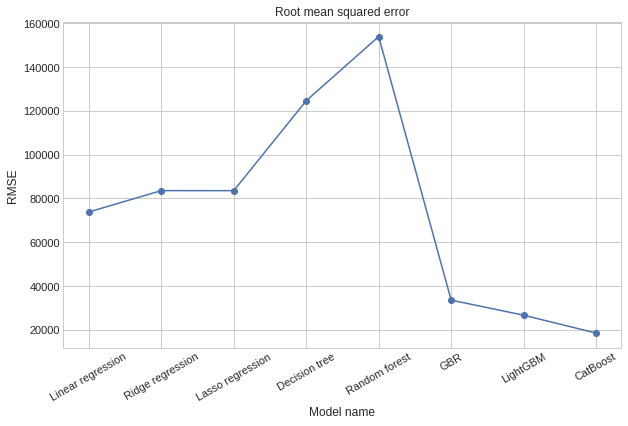

In [642]:
metrics_plot('Test_RMSE')

#### Interpreting the models for insights and recommendations

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
#creating an object that can calculate shap values
explainer = shap.TreeExplainer(cbr)

In [ ]:
#calculate shap values
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train,feature_names=X_train.columns,plot_type='bar')

In [ ]:
#Summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [ ]:
# we can use shap.approximate_interactions to guess which features
# may interact with a feature
inds = shap.approximate_interactions("Inhand_Offer", shap_values, X_train)

# make plots colored by each of the top three possible interacting features
for i in range(10):
    shap.dependence_plot("Inhand_Offer", shap_values, X_train, interaction_index=inds[i])

##### Final conclusions